In [1]:
from sunpy.net import hek
from sunpy.net import hek2vso
import matplotlib.pyplot as plt
%matplotlib inline
#matplotlib qt
import shapely
from shapely.wkt import dumps, loads
import numpy as np
import pandas as pd
from shapely.geometry.polygon import LinearRing, Polygon
from datetime import timedelta
import datetime
from sunpy.time import *
from dateutil.parser import parse
import matplotlib.cm as cm
import matplotlib as mpl
from operator import itemgetter
from itertools import groupby
import itertools
import operator
from datetime import timedelta
import csv
import dateutil

# This file will import eruption data for Oct 2013, the year 2012. It will also read in Dustin's track files for both those times. Then, it was also read in the different CSV files that record the correlated data and attempt to build a large amount of workable metadata

# Getting eruption data

###### the following is the code ashna has written to filter out single filament eruptions recorded at different wavelengths
client = hek.HEKClient()
h2v = hek2vso.H2VClient()
tstart_2012 = '2012/01/01 00:00:00'
tend_2012 = '2012/12/31 23:59:59'
event_type_2012 = 'FE'
eruptions_2012 = client.query(hek.attrs.Time(tstart_2012,tend_2012),hek.attrs.EventType(event_type_2012))
#vso_records = h2v.translate_and_query(eruptions_2012[10])
##############################################################################
tstart_2013_10 = '2013/10/01 00:00:00'
tend_2013_10 = '2013/10/31 23:59:59'
event_type_2013_10 = 'FE'
eruptions_2013_10 = client.query(hek.attrs.Time(tstart_2013_10,tend_2013_10),hek.attrs.EventType(event_type_2013_10))
#vso_records = h2v.translate_and_query(eruptions_2013_10[10])

times_2012=[elem["event_starttime"] for elem in eruptions_2012] 
indices_2012=[]
result_2012=[]
print len(eruptions_2012)
### the following loop will remove identical eruptions that have been recorded at different wavelengths by sorting with time
for element in times_2012:
    if element not in result_2012:
        indices_2012.append((times_2012.index(element)))
        result_2012.append(element)
print indices_2012
filtered_2012=[eruptions_2012[i] for i in indices_2012] #creates a filtered list of objects that are not indentical

times_2013_10=[elem["event_starttime"] for elem in eruptions_2013_10] 
indices_2013_10=[]
result_2013_10=[]
print len(eruptions_2013_10)
### the following loop will remove identical eruptions that have been recorded at different wavelengths by sorting with time
for element in times_2013_10:
    if element not in result_2013_10:
        indices_2013_10.append((times_2013_10.index(element)))
        result_2013_10.append(element)
print indices_2013_10
filtered_2013_10=[eruptions_2013_10[i] for i in indices_2013_10] #creates a filtered list of objects that are not indentical

# Getting filament data for the filaments that were only confirmed to erupt

In [2]:
###opens the csv file, pulls out 2012 track numbers 
tracknumbers_2012=[]
good_track_no_2012=[]
erup_info_2012=[]
with open('2012Track_eruptions_text.csv', 'rb') as f:    ###opens the excel document containing confirmed eruption track information
    reader = csv.reader(f)
    vdata = [row for row in csv.reader(f.read().splitlines())]   #splits the document by line
for row in vdata:
    tracknumbers_2012.append(row[0])      ###appends just the track number  
    erup_info_2012.append((row[0], row[7]))
for i in range(0, 2):
    tracknumbers_2012.pop(i)     #removes heading text for file 
    erup_info_2012.pop(i)
del tracknumbers_2012[0]
del erup_info_2012[0]
for item in tracknumbers_2012:      
    x=float(item)
    good_track_no_2012.append(x)  #appends the track numbers as a float to a new list 

In [3]:
#### opens csv file for non-erupting/transit filaments 2012
tracknumbers_2012_trans=[]
good_track_no_2012_trans=[]
with open('Transit_tracks2012.csv', 'rb') as f:    ###opens the excel document containing confirmed eruption track information
    reader = csv.reader(f)
    vdata = [row for row in csv.reader(f.read().splitlines())]   #splits the document by line
for row in vdata:
    tracknumbers_2012_trans.append(row[0])      ###appends just the track number
for i in range(0, 2):
    tracknumbers_2012_trans.pop(i)     #removes heading text for file 
del tracknumbers_2012_trans[0]
##########
for item in tracknumbers_2012_trans:      
    x=float(item)
    good_track_no_2012_trans.append(x)  #appends the track numbers as a float to a new list 
print good_track_no_2012_trans

[160.0, 407.0, 533.0, 939.0, 1118.0, 1265.0, 1500.0, 1928.0, 1930.0, 2004.0, 2155.0, 2397.0, 2466.0, 2838.0]


In [4]:
###reads in filament track metadata 
fi_tracked2012 = pd.read_csv('FIDustinTracked_2012.txt',delimiter='\t')   ##working with filament data 
fi_tracked2012.head()
good_tracks2012 = fi_tracked2012.groupby('Track No.').filter(lambda x: len(x['Track No.']) >= 3, dropna=False) 

In [5]:
###selects the data of interest by csv track numbers 
inds=[]
inds_trans=[]
for i in range(0, len(good_tracks2012)):
    if good_tracks2012['Track No.'][i] in good_track_no_2012:
        inds.append(i)
    if good_tracks2012['Track No.'][i] in good_track_no_2012_trans:
        inds_trans.append(i)
working_data_2012=good_tracks2012.ix[inds]    #filament data file that only contains information pertaining to tracks confirmed to erupt
working_data_2012_trans=good_tracks2012.ix[inds_trans]

In [6]:
trx=working_data_2012['Track No.']
norm_erup_time_2012=[]
for elem1 in erup_info_2012:
    for elem2 in trx:
        if float(elem1[0]) == elem2:
            norm_erup_time_2012.append(elem1[1])

In [7]:
#the following code finds the maximum length of a filament in a track and normalizes each group by this distance
trx=working_data_2012['Track No.']
size=working_data_2012['fi_length']
track_size=zip(trx, size)  #track number, length
norm_size=[]   #will be refreshed every iteration
all_norm_lengths=[]     #final list
for elem2 in good_track_no_2012:
    for elem3 in track_size:
        if elem3[0] == elem2:
            norm_size.append(elem3[1])
    if len(norm_size) != 0:
        for item in norm_size:
            a=item/max(norm_size)
            all_norm_lengths.append(a)
        norm_size=[]

# 2013!!!

In [8]:
###opens the csv file, pulls out 2013 track numbers 
tracknumbers_oct_2013=[]
good_track_no_oct_2013=[]
erup_info_oct_2013=[]
with open('Oct2013Track_eruptions.csv', 'rb') as f:    ###opens the excel document containing confirmed eruption track information
    reader = csv.reader(f)
    vdata = [row for row in csv.reader(f.read().splitlines())]   #splits the document by line
for row in vdata:
    tracknumbers_oct_2013.append(row[0])      ###appends just the track number
    erup_info_oct_2013.append((row[0], row[7]))
for i in range(0, 2):
    tracknumbers_oct_2013.pop(i)     #removes heading text for file 
    erup_info_oct_2013.pop(i)
######
del tracknumbers_oct_2013[0]
del erup_info_oct_2013[0]
##########
for item in tracknumbers_oct_2013:      
    x=float(item)
    good_track_no_oct_2013.append(x)  #appends the track numbers as a float to a new list 

In [9]:
#### for non-erupting/transit filaments 2013
tracknumbers_oct_2013_trans=[]
good_track_no_oct_2013_trans=[]
with open('Transit_tracks_oct_2013.csv', 'rb') as f:    ###opens the excel document containing confirmed eruption track information
    reader = csv.reader(f)
    vdata = [row for row in csv.reader(f.read().splitlines())]   #splits the document by line
for row in vdata:
    tracknumbers_oct_2013_trans.append(row[0])      ###appends just the track number
for i in range(0, 2):
    tracknumbers_oct_2013_trans.pop(i)     #removes heading text for file 
del tracknumbers_oct_2013_trans[0]
##########
for item in tracknumbers_oct_2013_trans:      
    x=float(item)
    good_track_no_oct_2013_trans.append(x)  #appends the track numbers as a float to a new list 
print good_track_no_oct_2013_trans

[97.0, 154.0, 166.0, 185.0, 72.0]


In [10]:
###reads in filament track metadata
fi_tracked_oct_2013 = pd.read_csv('FIDustinTracked_2013_10.txt',delimiter='\t')   ##working with filament data 
fi_tracked_oct_2013.head()
good_tracks_oct_2013 = fi_tracked_oct_2013.groupby('Track No.').filter(lambda x: len(x['Track No.']) >= 3, dropna=False) 

In [27]:
##selects the data of interest by csv track numbers
inds=[]
inds_trans=[]
for i in range(0, len(good_tracks_oct_2013)):
    if good_tracks_oct_2013['Track No.'][i] in good_track_no_oct_2013:
        inds.append(i)
    if good_tracks_oct_2013['Track No.'][i] in good_track_no_oct_2013_trans:
        inds_trans.append(i)
working_data_oct_2013=good_tracks_oct_2013.ix[inds]    #filament data file that only contains information pertaining to tracks confirmed to erupt
working_data_oct_2013_trans = good_tracks_oct_2013.ix[inds_trans]

In [12]:
trx=working_data_oct_2013['Track No.']
norm_erup_time_2013=[]
for elem1 in erup_info_oct_2013:
    for elem2 in trx:
        if float(elem1[0]) == elem2:
            norm_erup_time_2013.append(elem1[1])

In [13]:
#the following code finds the maximum length of a filament in a track and normalizes each group by this distance
trx_2013=working_data_oct_2013['Track No.']
size_2013=working_data_oct_2013['fi_length']
track_size_2013=zip(trx_2013, size_2013)  #track number, length
norm_size_2013=[]   #will be refreshed every iteration
all_norm_lengths_2013=[]     #final list
for elem2 in good_track_no_oct_2013:
    for elem3 in track_size_2013:
        if elem3[0] == elem2:
            norm_size_2013.append(elem3[1])
    if len(norm_size_2013) != 0:
        for item in norm_size_2013:
            a=item/max(norm_size_2013)
            all_norm_lengths_2013.append(a)
        norm_size_2013=[]

##### All together!

In [24]:
all_tracks=[]

length_2012=working_data_2012['fi_length']
time_2012=working_data_2012['HEK_time']
track_2012=working_data_2012['Track No.']
chiral_2012= working_data_2012['fi_chirality']
plot_length_data_2012=zip(track_2012, time_2012, length_2012, norm_erup_time_2012, all_norm_lengths, chiral_2012)
###############################################
length_2013_10=working_data_oct_2013['fi_length']
time_2013_10=working_data_oct_2013['HEK_time']
track_2013_10=working_data_oct_2013['Track No.']
chiral_2013_10= working_data_oct_2013['fi_chirality']
norm_track_2013=[]
for tr in track_2013_10:
    new = tr + 3000
    norm_track_2013.append(new)
plot_length_data_2013=zip(norm_track_2013, time_2013_10, length_2013_10, norm_erup_time_2013, all_norm_lengths_2013, chiral_2013_10)

all_data=plot_length_data_2012+plot_length_data_2013

for element in all_data:
    all_tracks.append(element[0])

0.0
0.0
-1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
1.0
0.0
0.0
0.0
1.0
0.0
-1.0
-1.0
0.0
-1.0
1.0
0.0
0.0
-1.0
1.0
1.0
1.0
0.0
1.0
-1.0
1.0
0.0
-1.0
0.0
-1.0
1.0
-1.0
-1.0
-1.0
0.0
0.0
-1.0
0.0
0.0
0.0
0.0
-1.0
-1.0
0.0
0.0
1.0
0.0
0.0
1.0
-1.0
0.0
1.0
0.0
-1.0
0.0
1.0
0.0
0.0
0.0
1.0
0.0
0.0
1.0
0.0
0.0
-1.0
-1.0
1.0
0.0
0.0
0.0
-1.0
-1.0
0.0
0.0
0.0
0.0
0.0
-1.0
-1.0
-1.0
0.0
1.0
-1.0
0.0
0.0
1.0
-1.0
0.0
0.0
0.0
-1.0
1.0
0.0
-1.0
0.0
0.0
1.0
1.0
0.0
1.0
0.0
1.0
1.0
0.0
1.0
0.0
1.0
1.0
-1.0
-1.0
-1.0
0.0
-1.0
0.0
0.0
0.0
-1.0
0.0
0.0
-1.0
0.0
0.0
0.0
0.0
-1.0
-1.0
0.0
0.0
-1.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
0.0
0.0
0.0
0.0
1.0
-1.0
0.0
0.0
-1.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.0
1.0
0.0
-1.0
-1.0
0.0
1.0
0.0
-1.0
0.0
-1.0
0.0
-1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.0
1.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.0
1.0
0.0
0.0
1.0
0.0
0.0
1.0
1.0
0.0
1.0
1.0
0.0
1.0
-1.0
0.0
0.0
0.0
1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
0.0
1.0
0.0
1.0
0.0
0.0
-1.0
-1.0
0.0
0.0
0.

# Length analysis

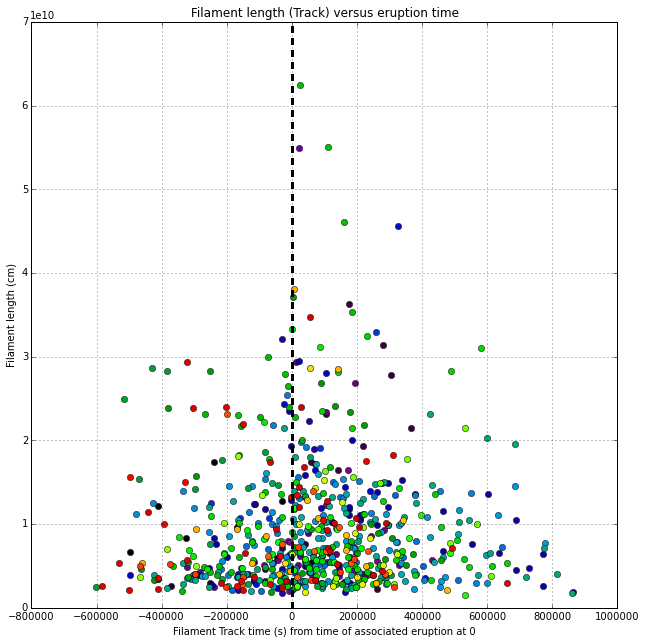

In [15]:
colorscale2=[]
norm = mpl.colors.Normalize(vmin=0, vmax=3500)
cmap = plt.get_cmap('nipy_spectral')
m = cm.ScalarMappable(norm=norm, cmap=cmap)
interest=[]
x=[]
y=[]
t=[]
all_tracks=np.unique(all_tracks)
for track in all_tracks:
    scale3=m.to_rgba(track)
    x=[] ### will be time data
    y=[] ## will be length data 
    r=[]
    t=[]
    interest=[]
    emp=[]
    for r in all_data:      #iterates through the data 
        if r[0] == track:  #finds the correct track
            if r not in interest:
                 interest.append(r)   #appends the data to a new list
    for k in range(0, len(interest)):
        t2= parse(interest[k][3])    ##eruption time
        t1=parse(interest[k][1])    #filament time
        t3=timedelta.total_seconds(t2-t1) #difference between the two in seconds
        t.append(int(t3))
        y.append(interest[k][2])
    plt.plot(t, y, 'o', color=scale3)
    plt.axvline(0, linewidth=3, color='k', linestyle='--', label='Eruption')
    plt.title('Filament length (Track) versus eruption time')
    plt.grid(True)
    fig1 = plt.gcf()
    fig1.set_size_inches(10.5,10.5)
    plt.xlabel('Filament Track time (s) from time of associated eruption at 0')
    plt.ylabel('Filament length (cm)')
plt.show()

bad!


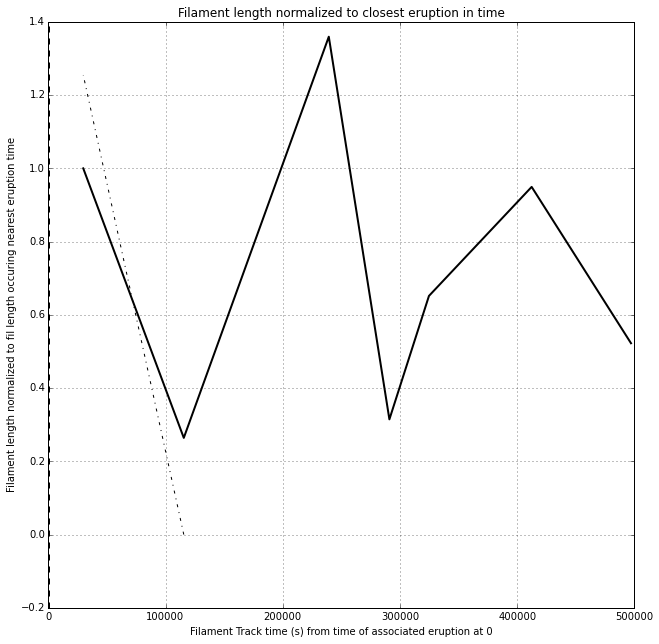

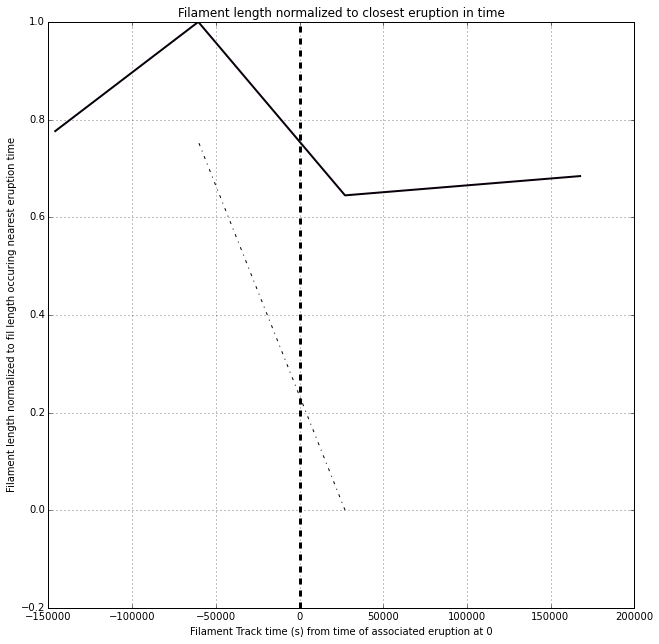

bad!
look at me!


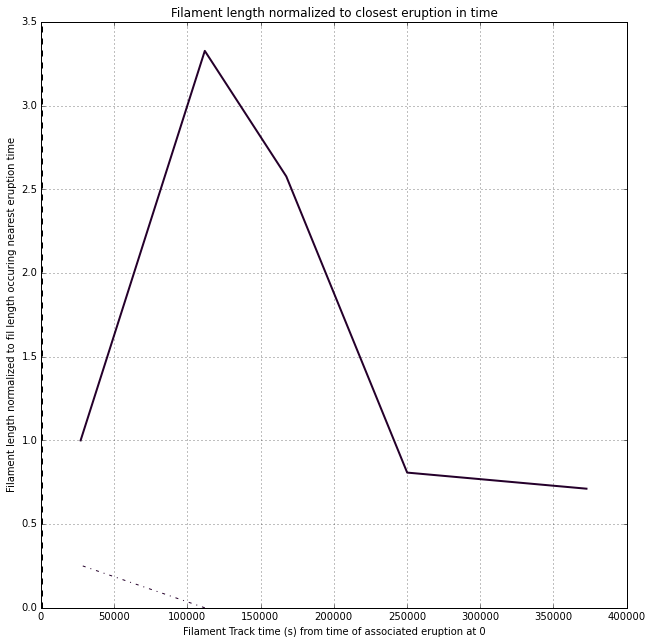

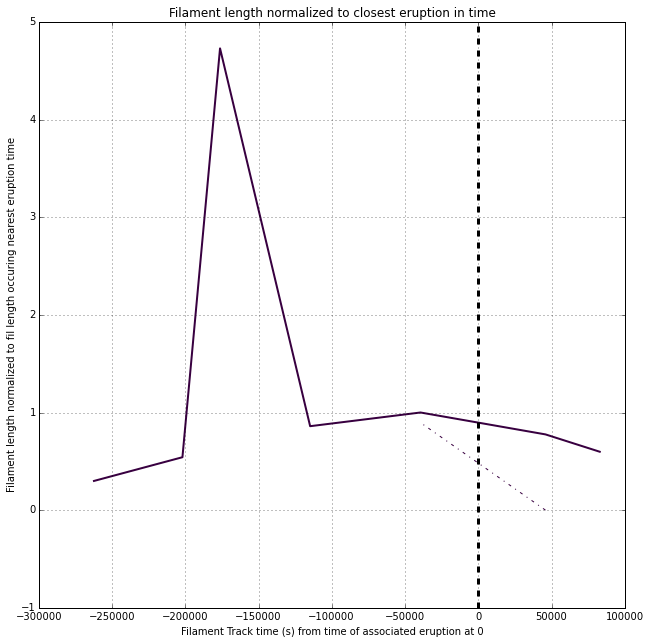

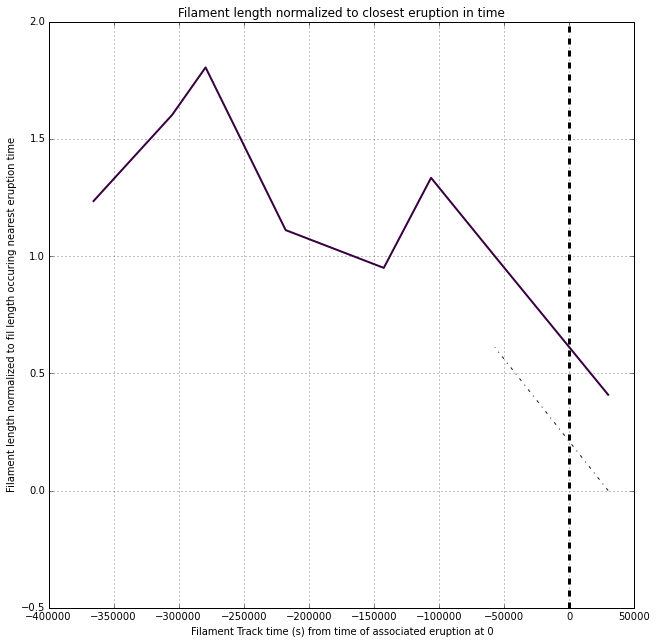

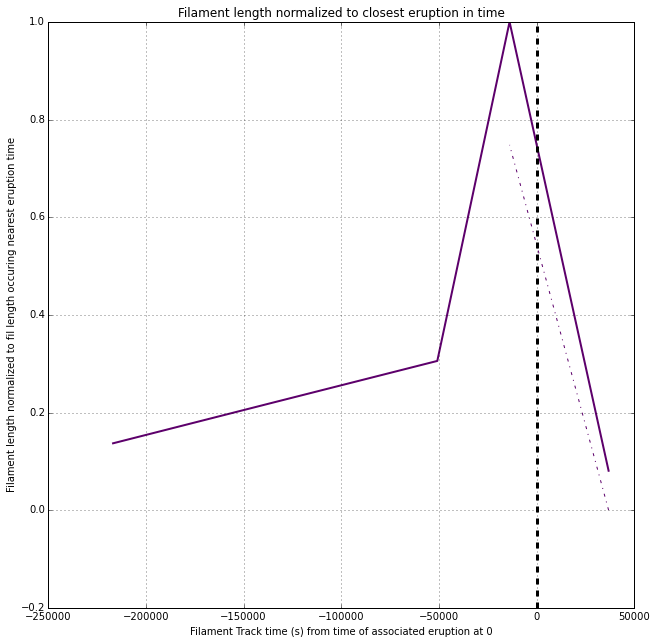

This filament erupted and disappeared


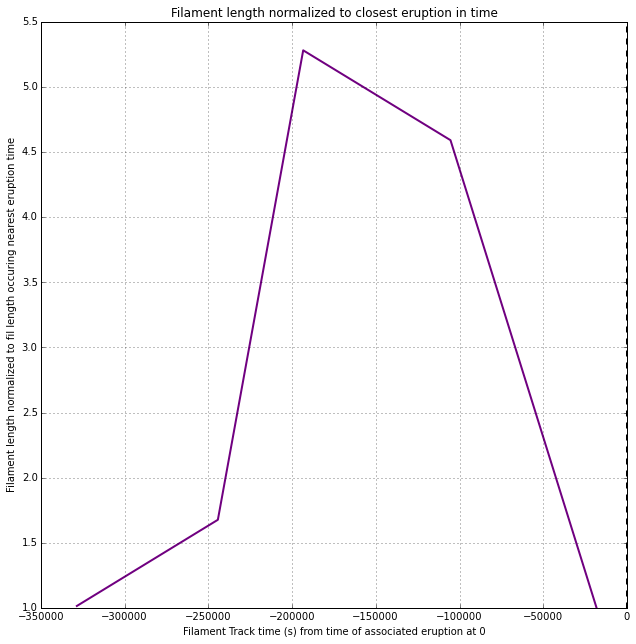

look at me!


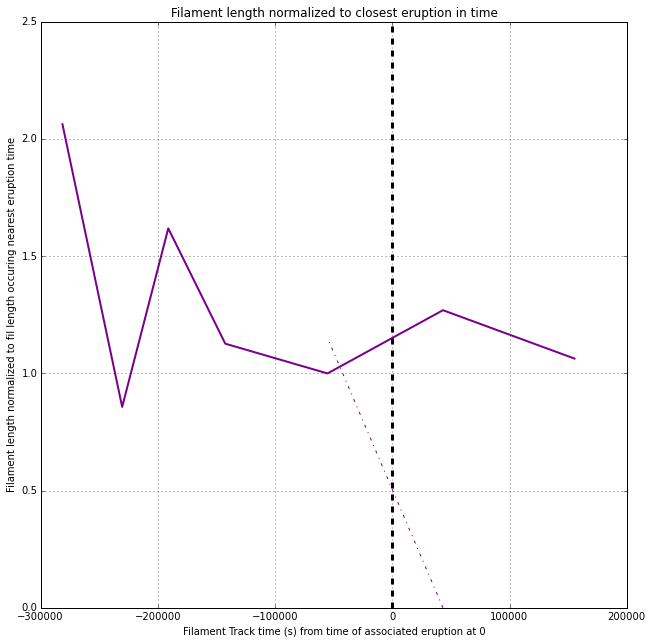

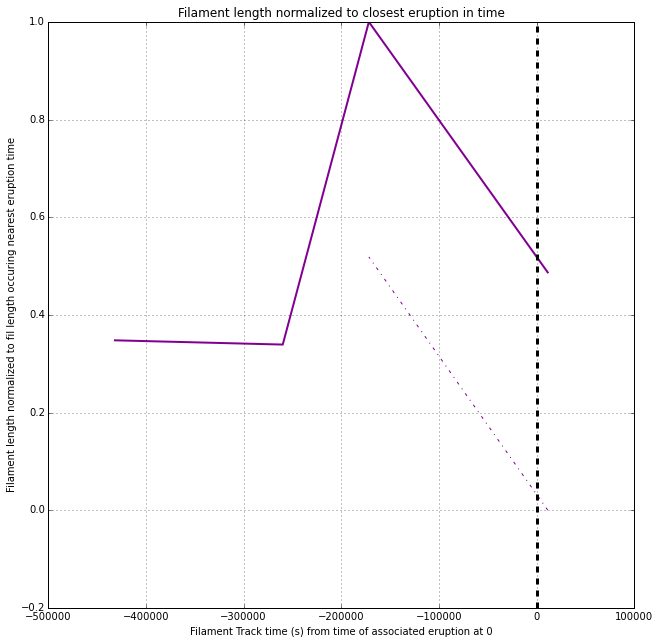

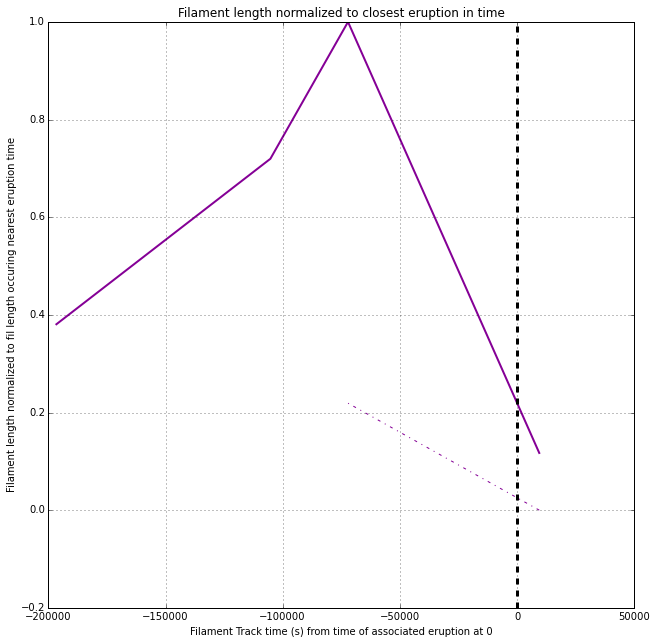

bad!


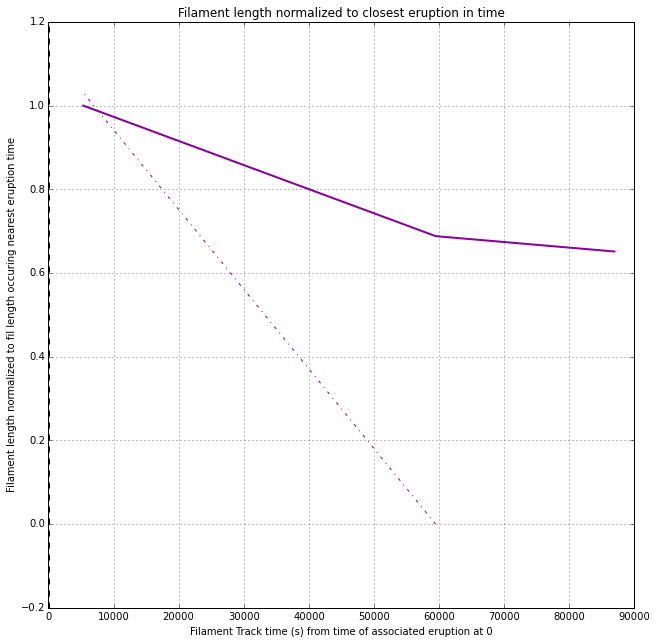

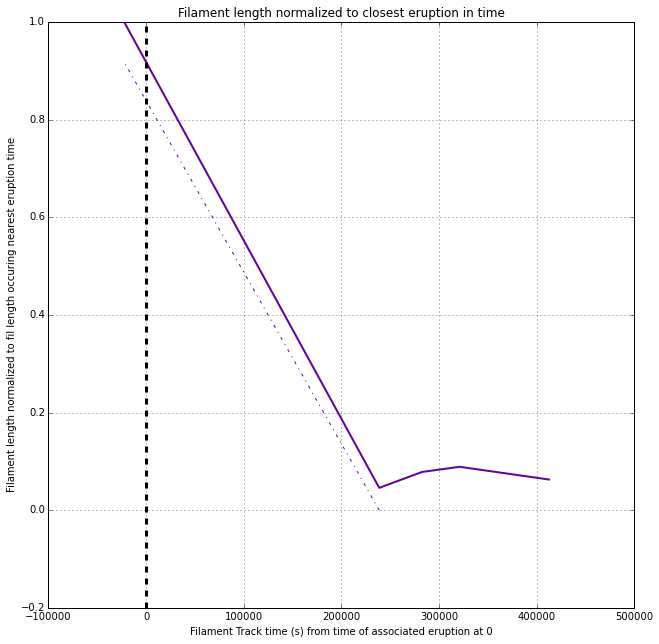

This filament erupted and disappeared


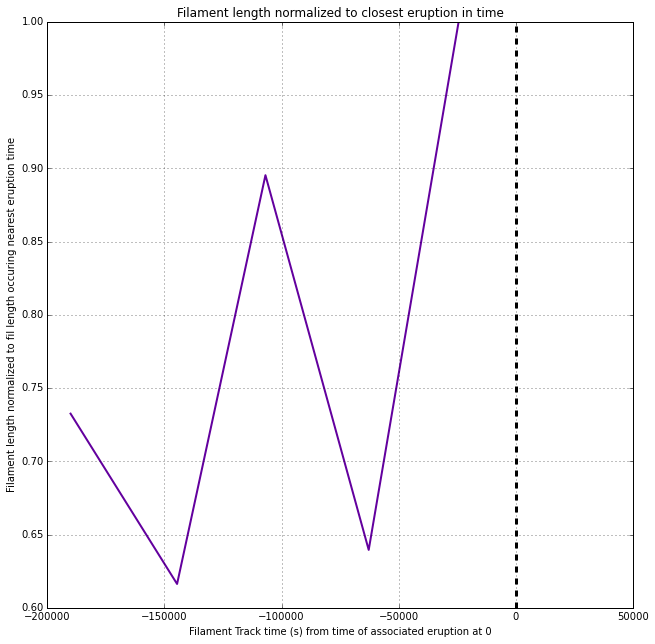

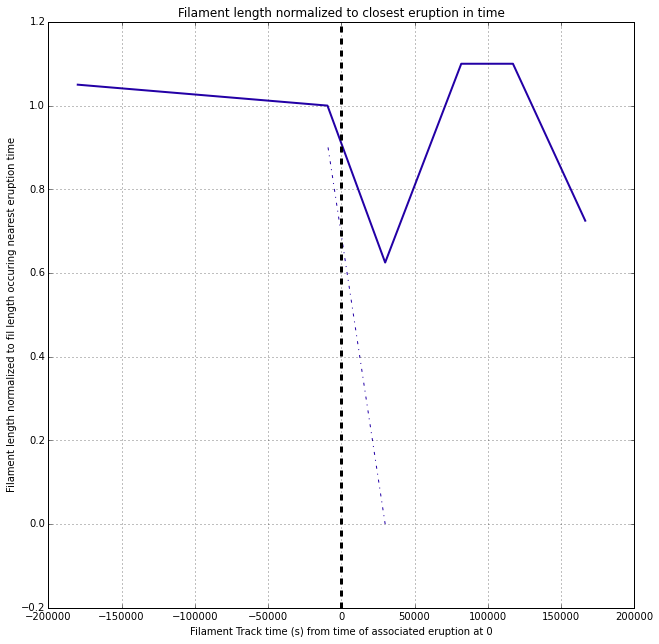

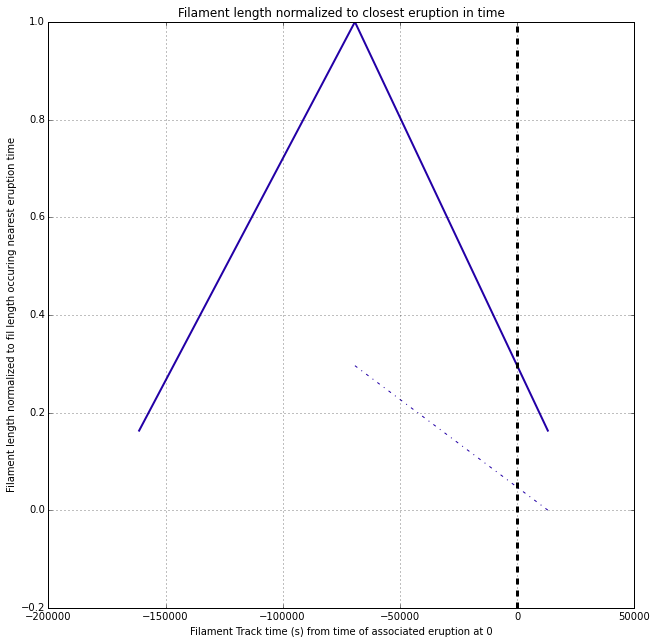

look at me!


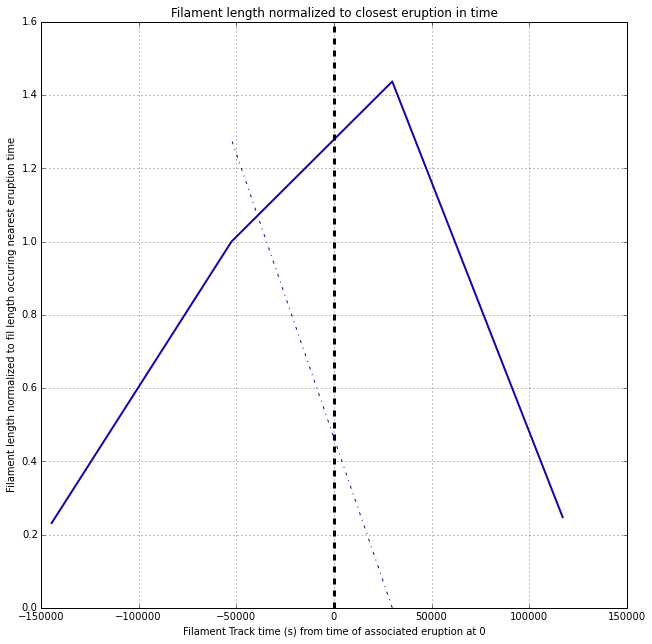

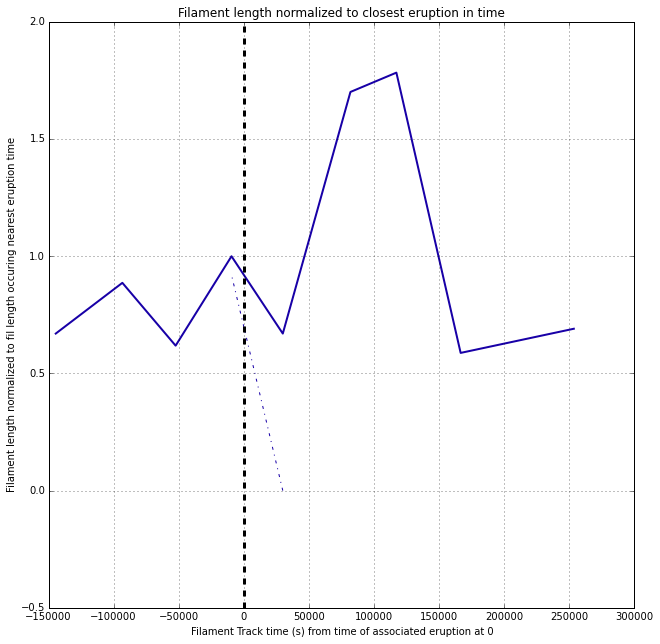

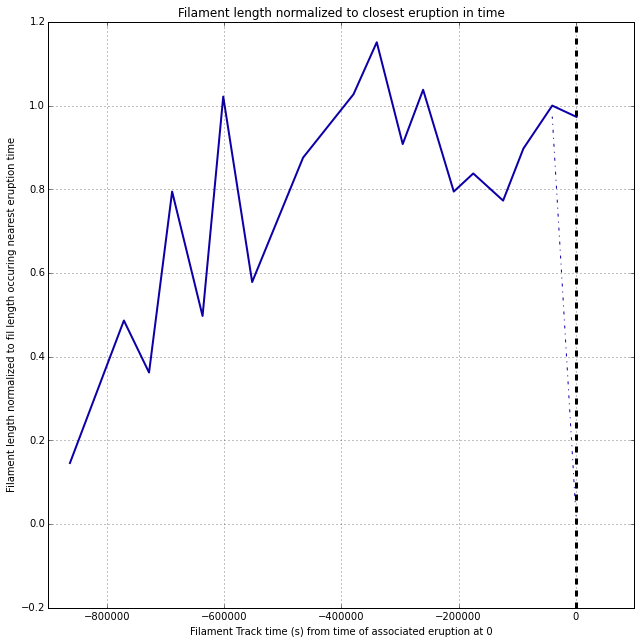

look at me!


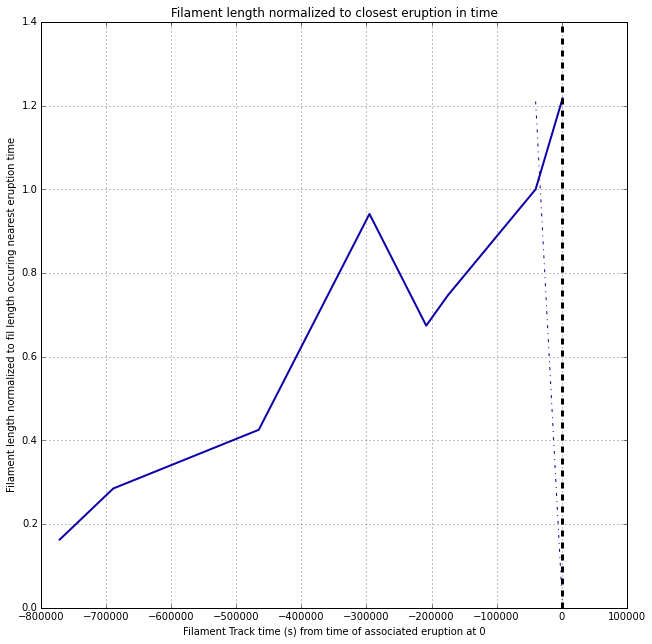

look at me!


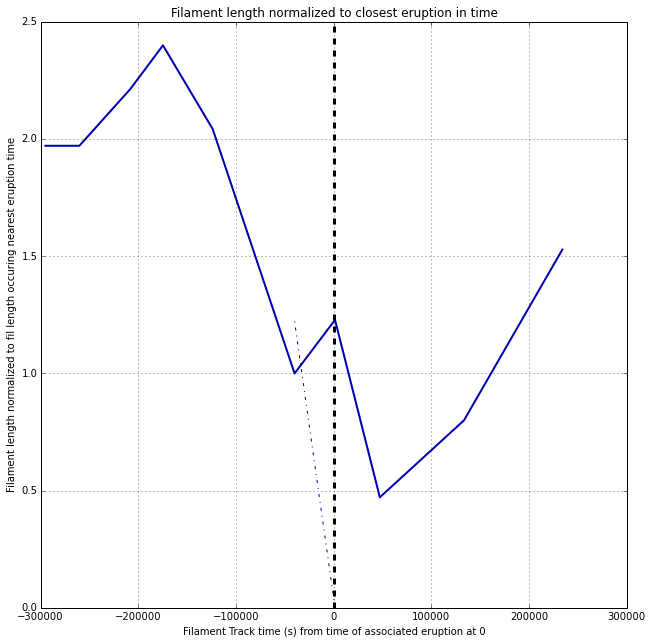

look at me!


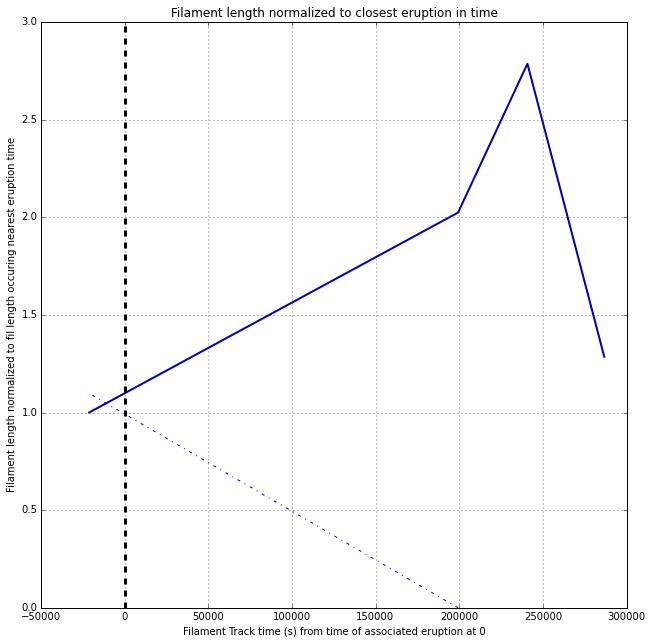

look at me!


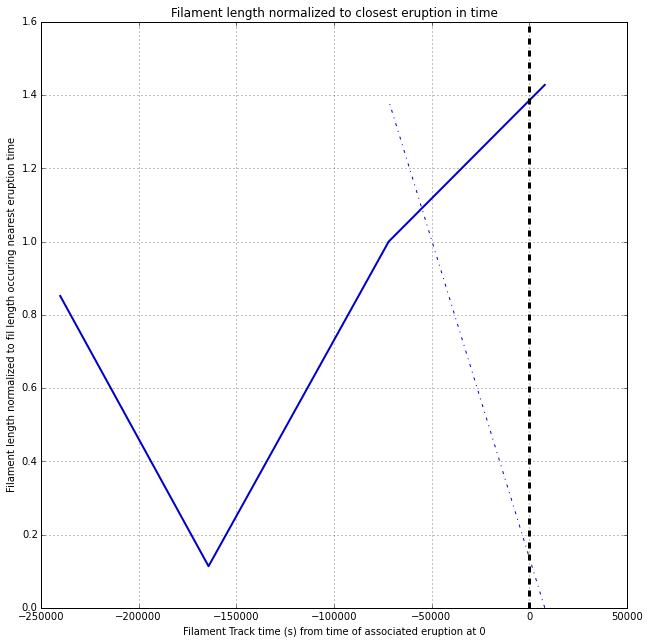

look at me!


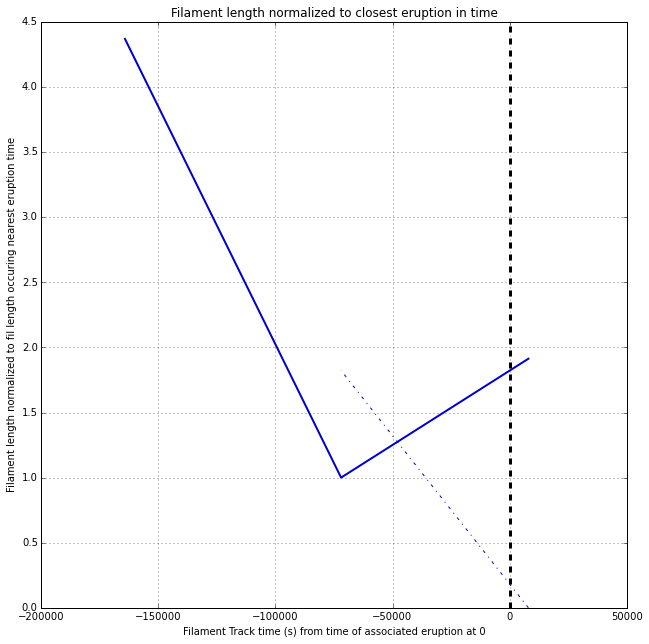

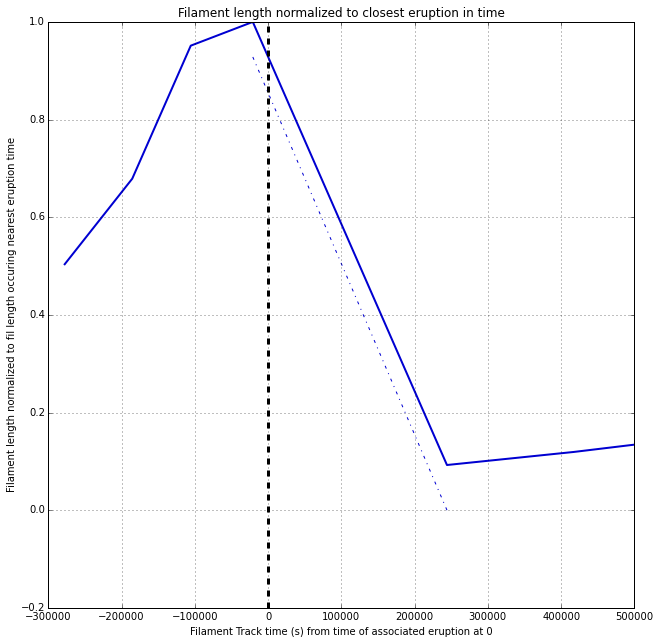

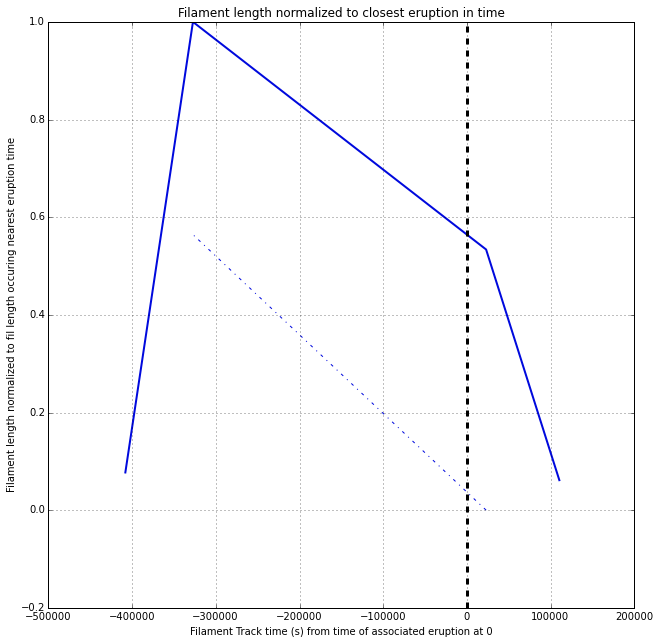

look at me!


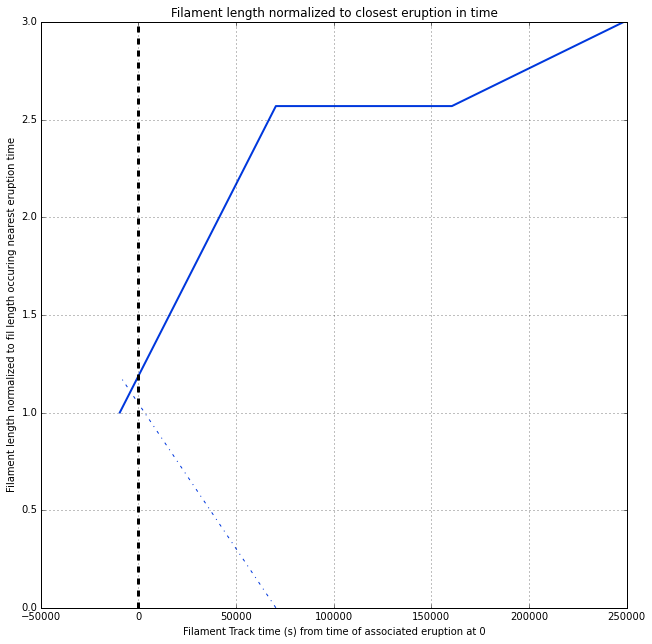

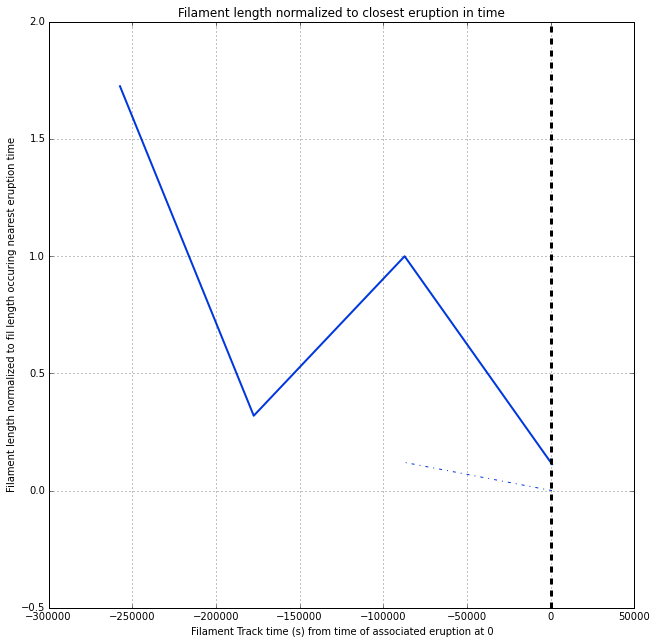

look at me!


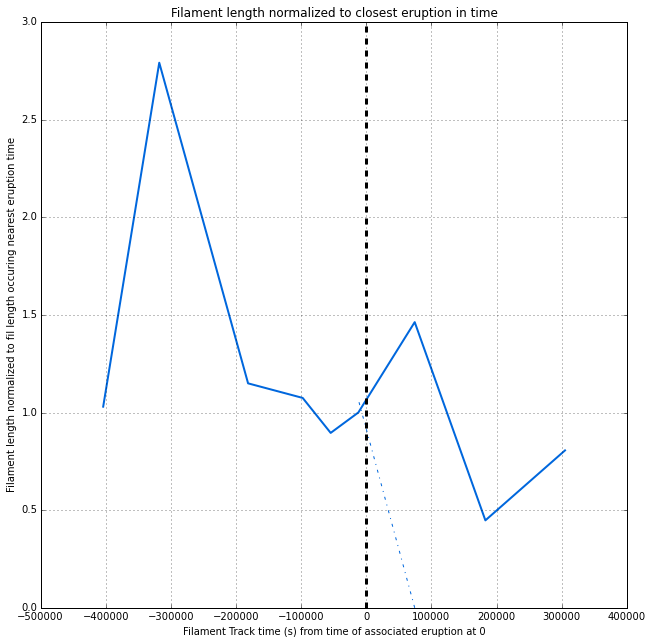

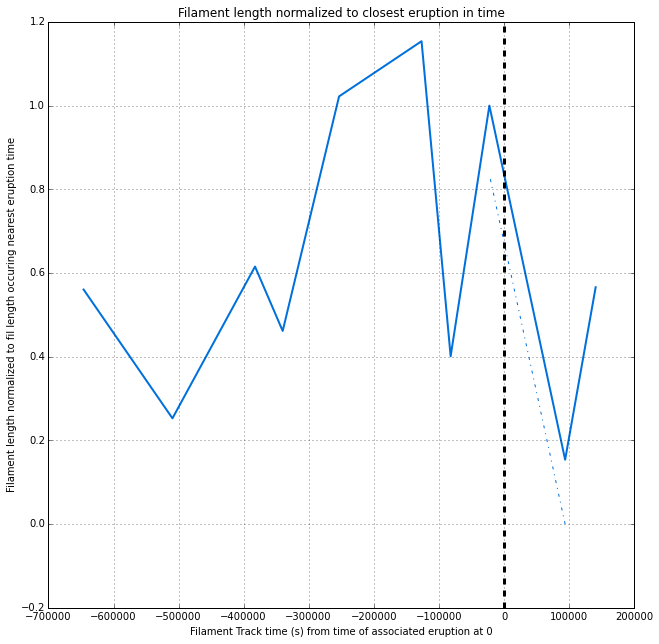

This filament erupted and disappeared


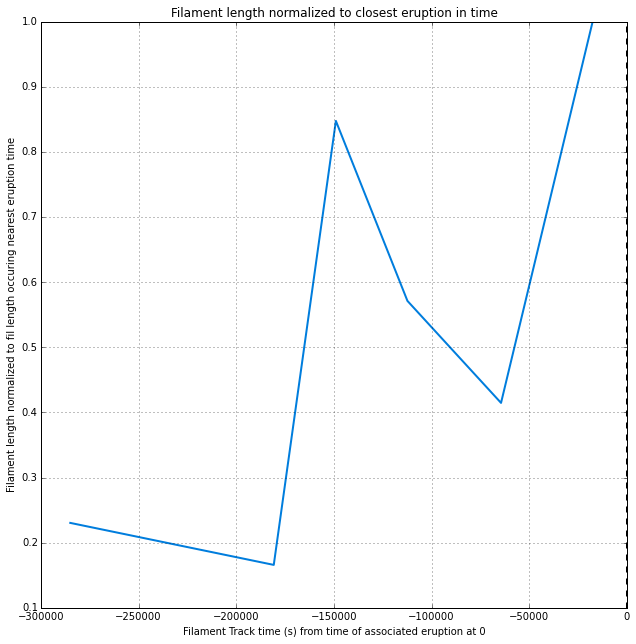

look at me!


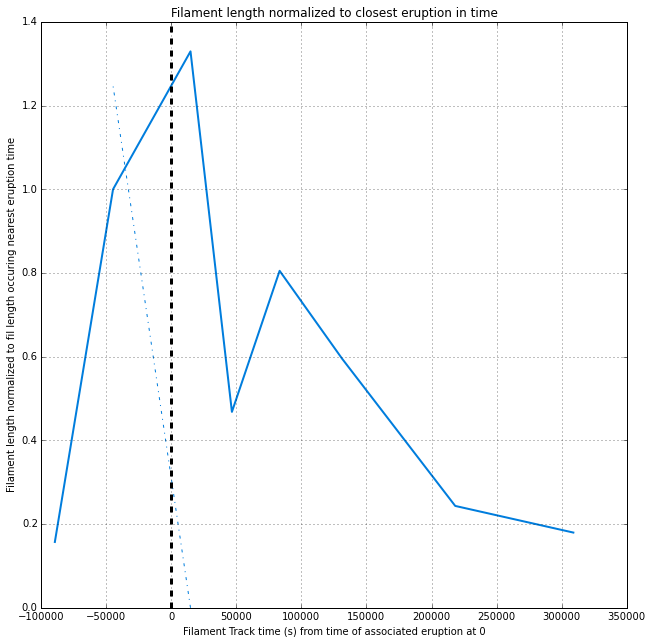

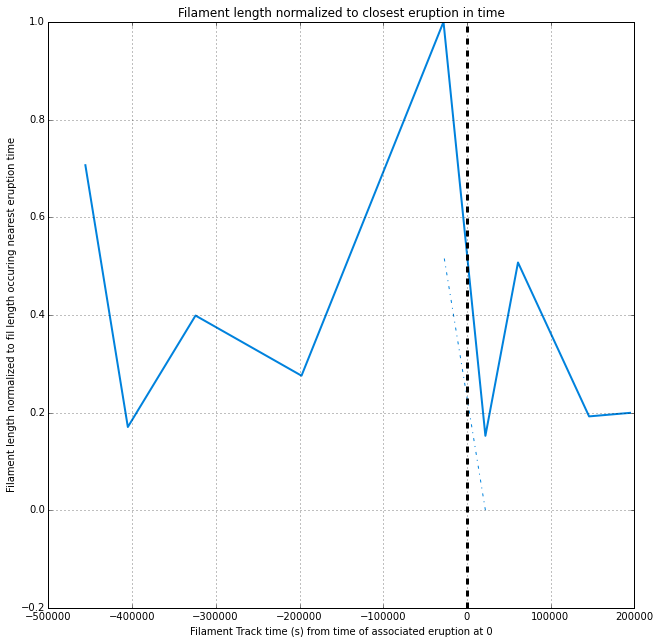

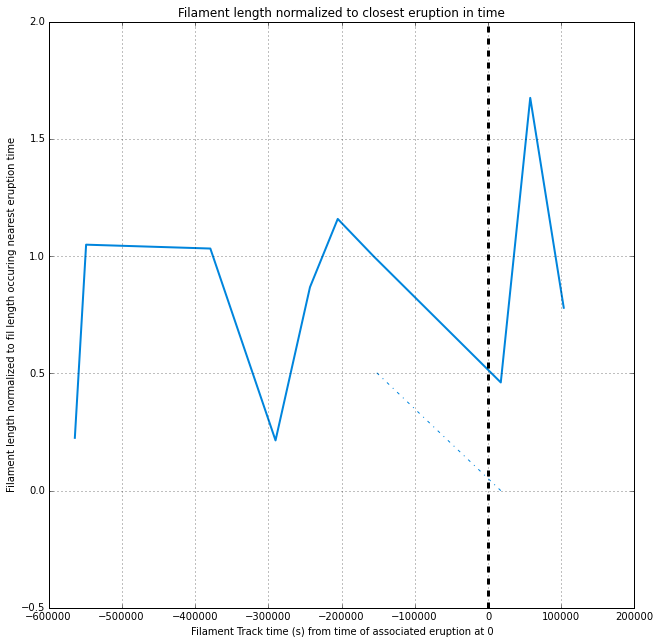

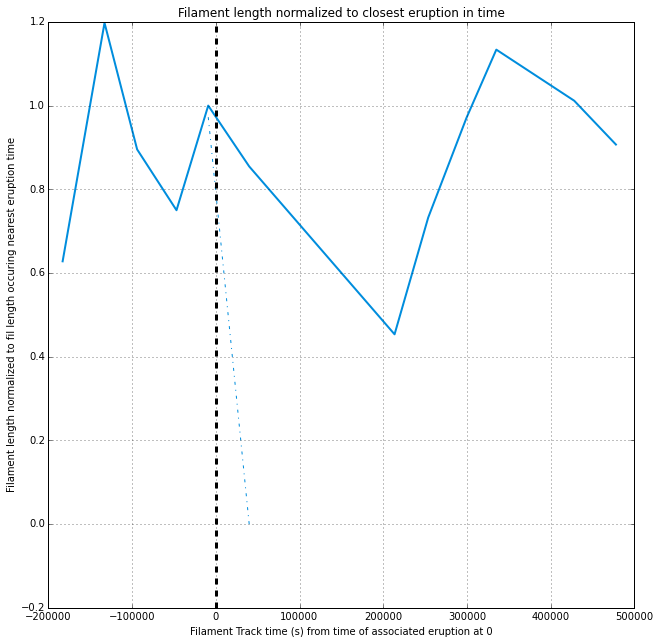

look at me!


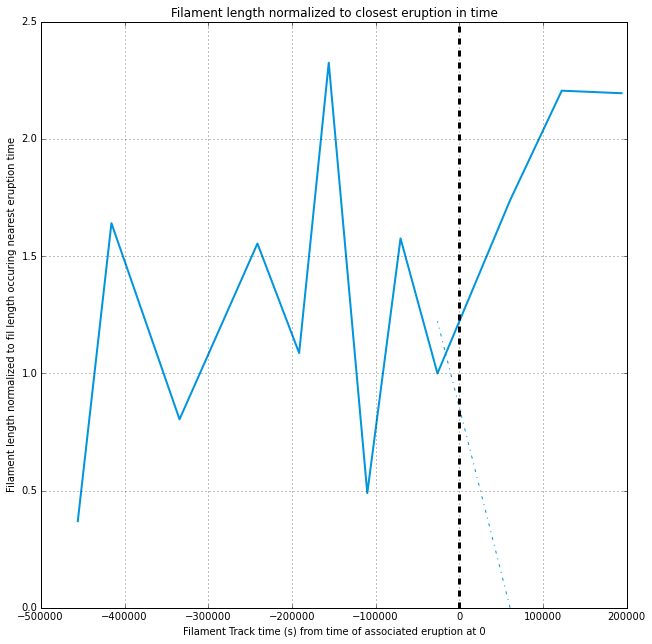

look at me!


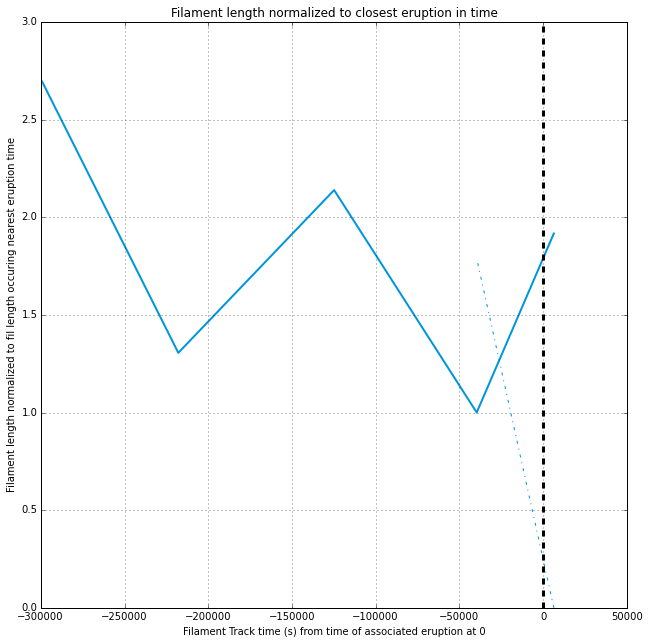

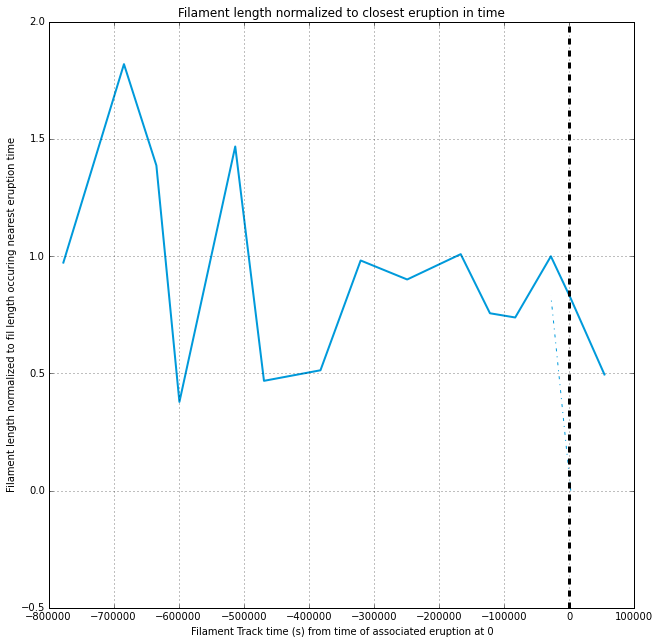

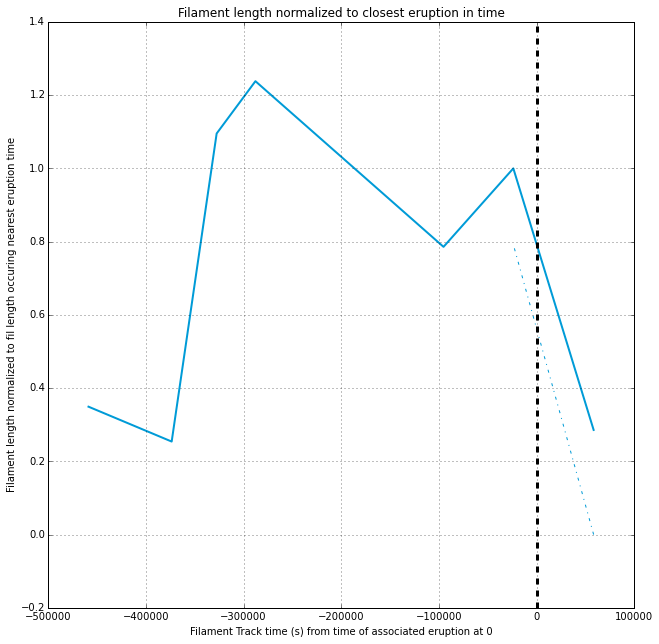

look at me!


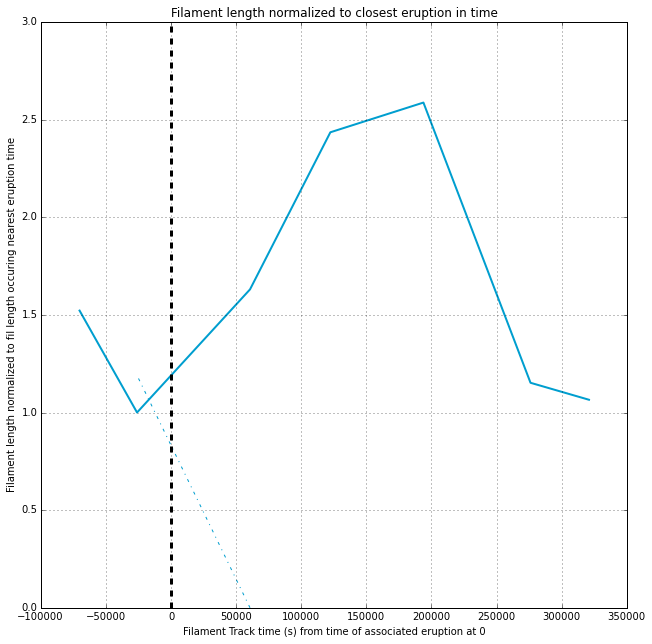

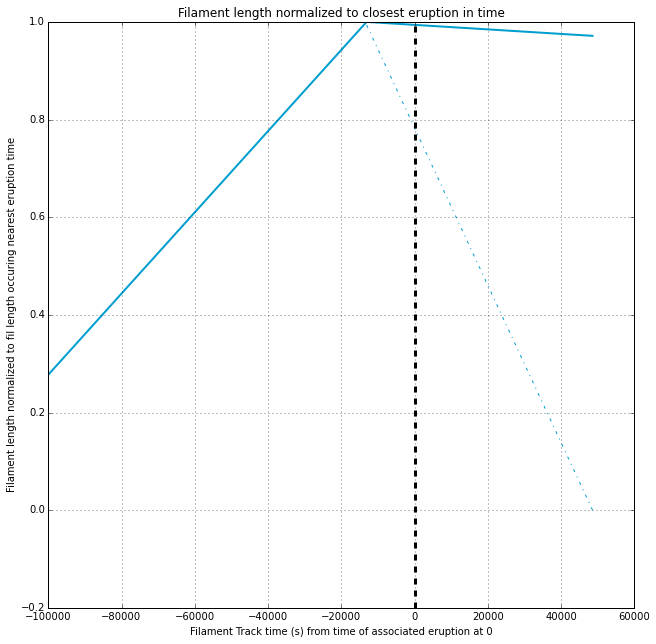

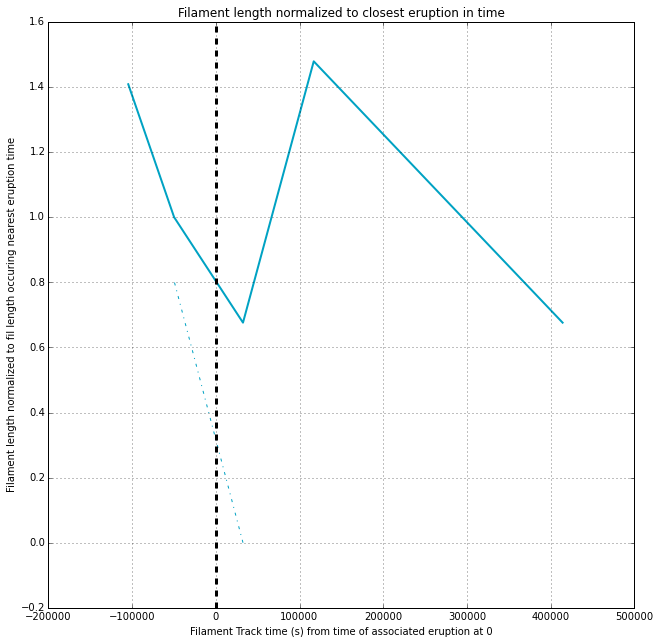

This filament erupted and disappeared


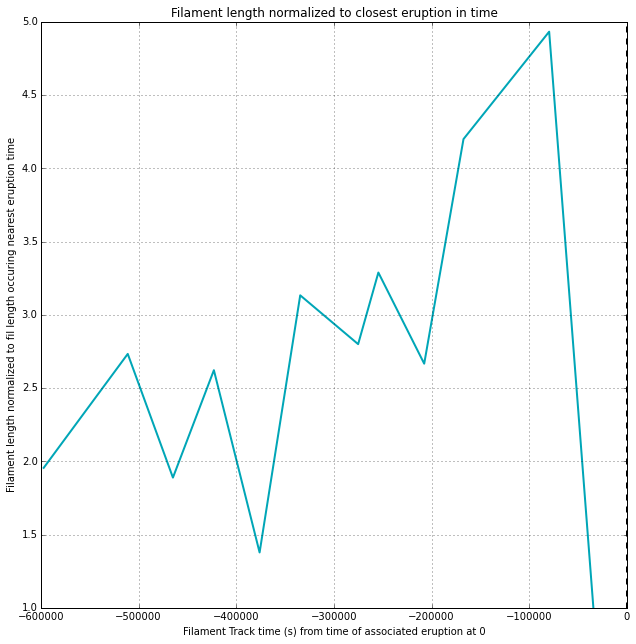

look at me!


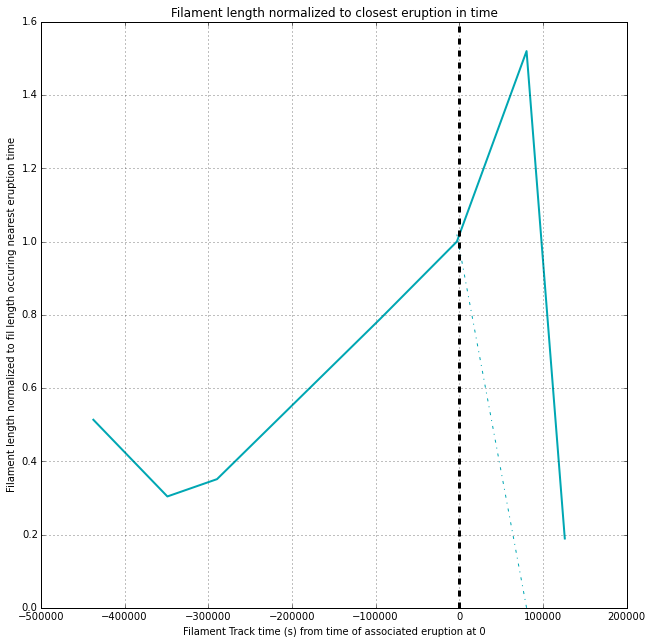

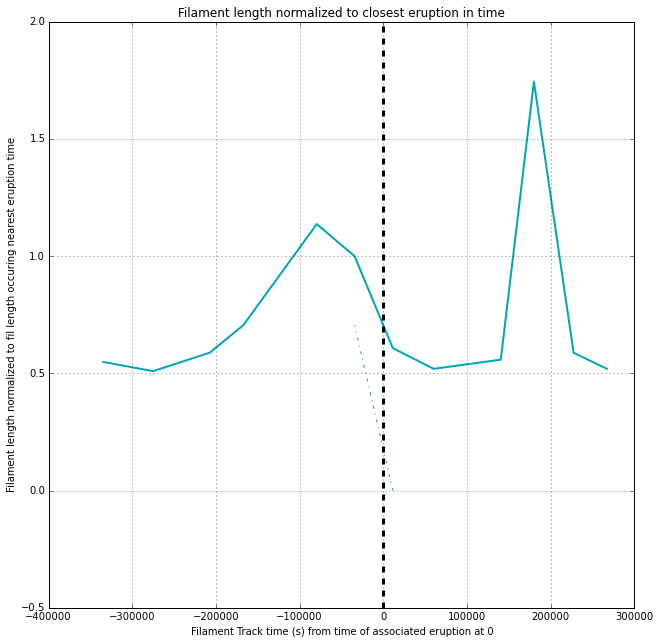

This filament erupted and disappeared


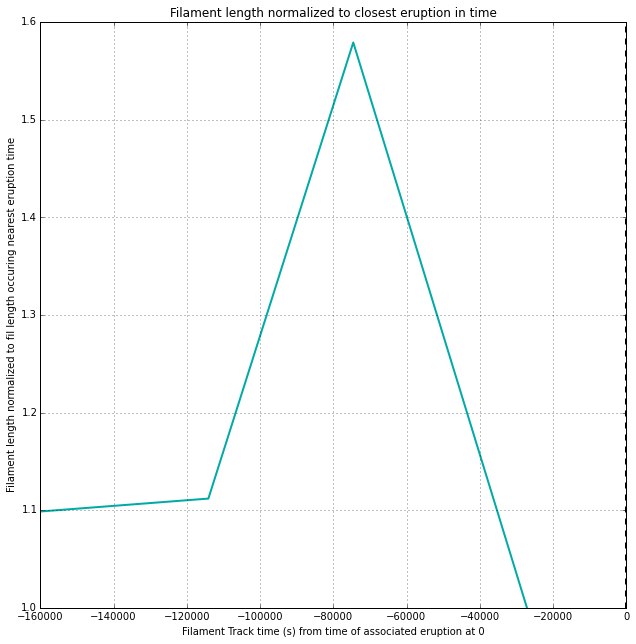

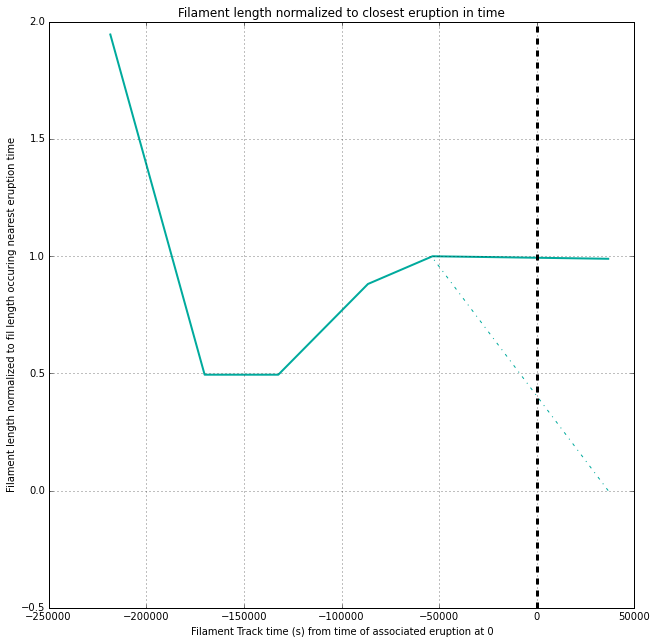

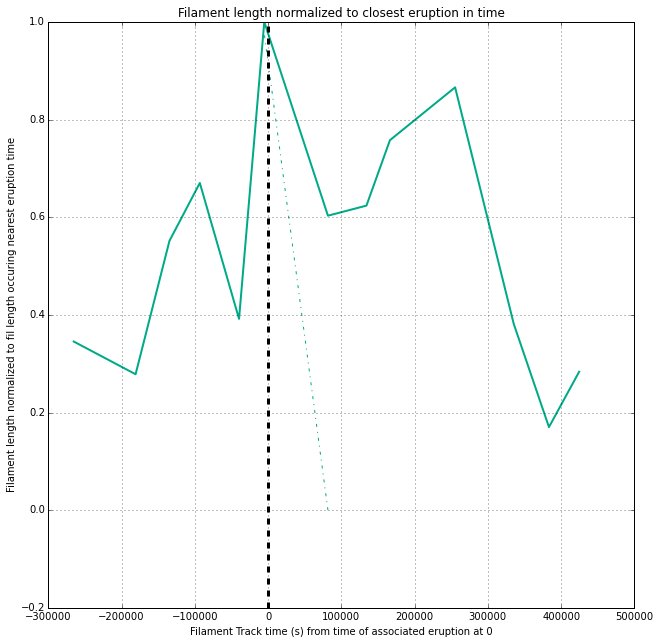

look at me!


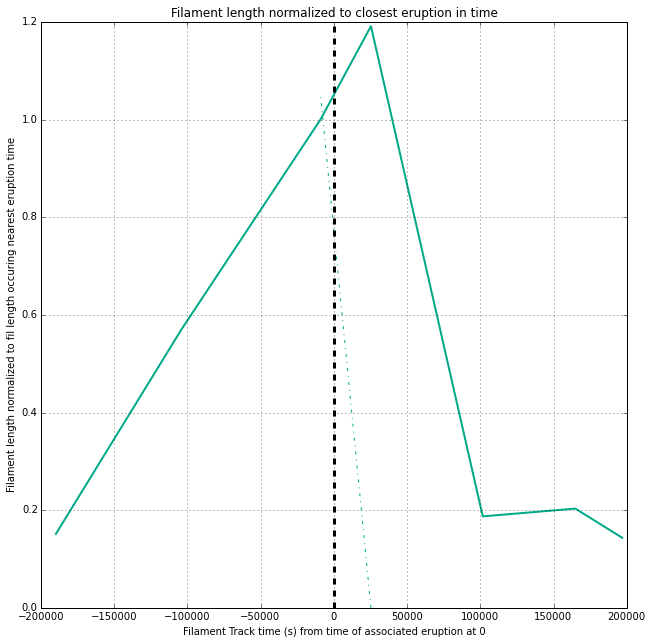

look at me!


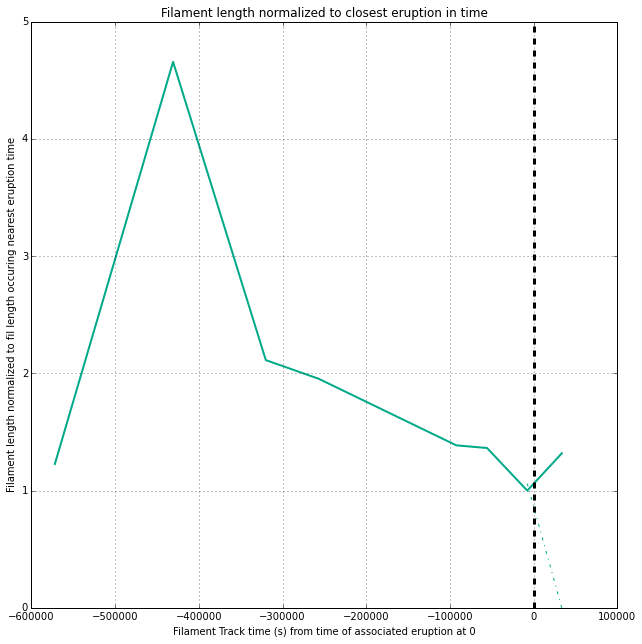

This filament erupted and disappeared


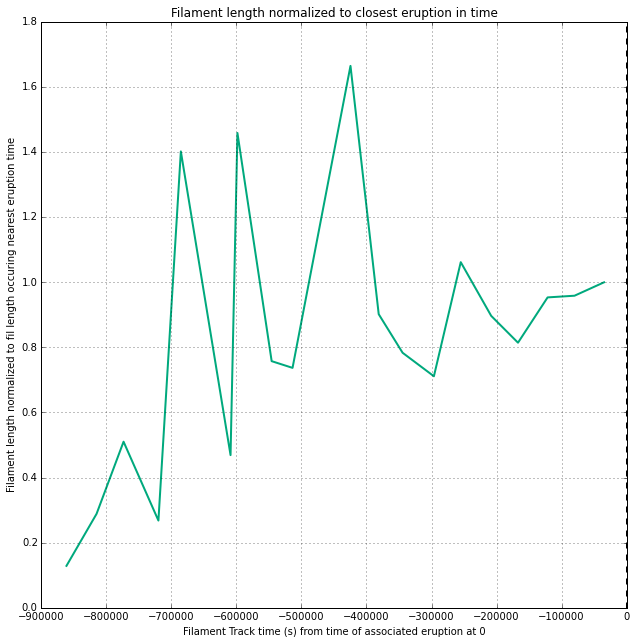

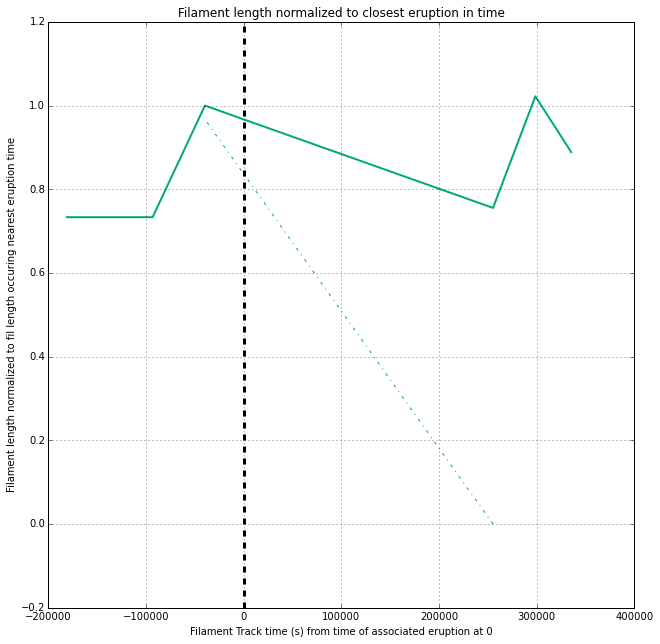

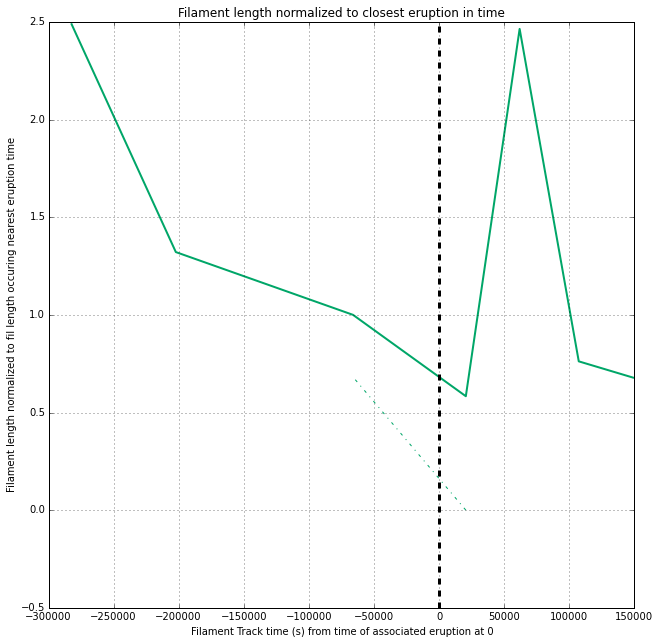

This filament erupted and disappeared


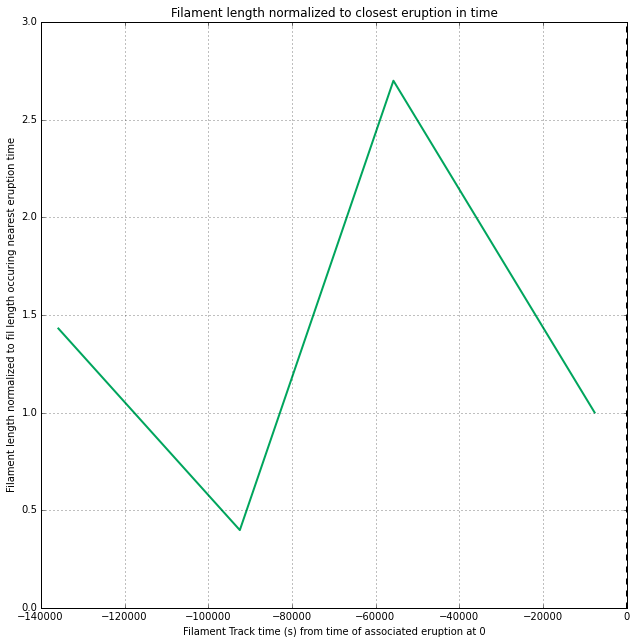

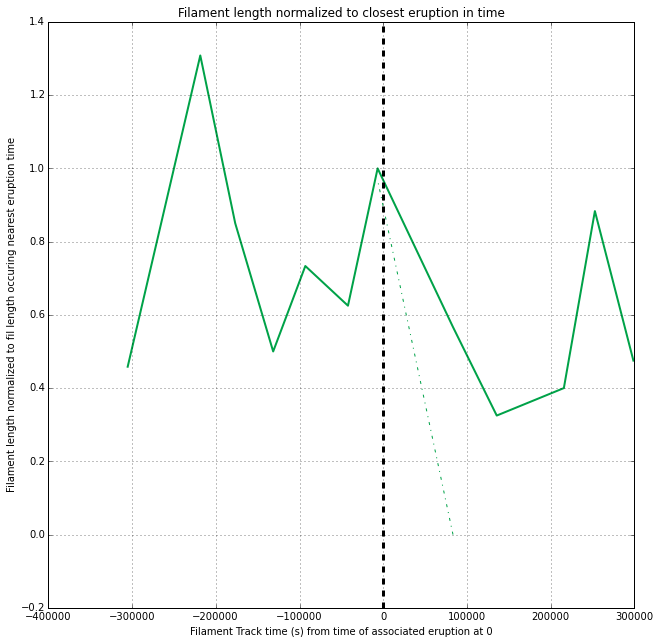

This filament erupted and disappeared


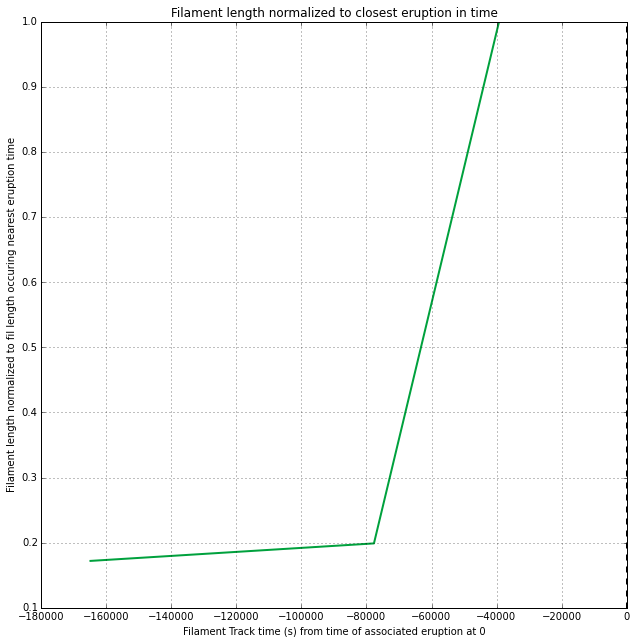

look at me!


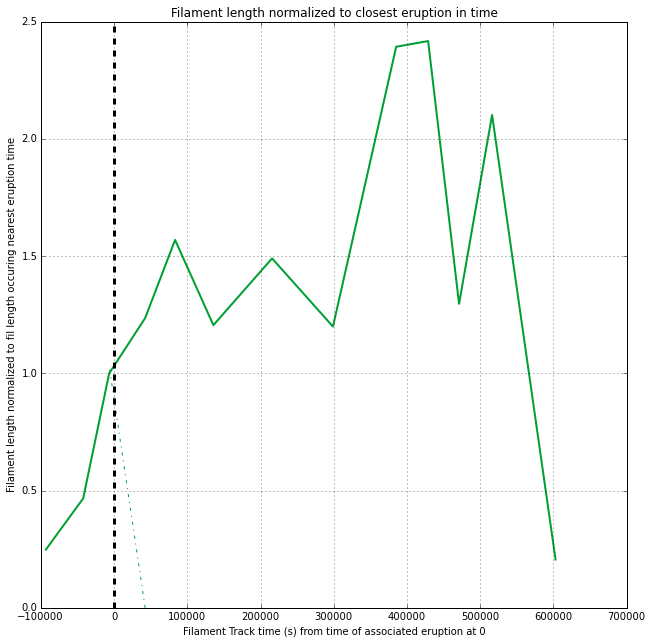

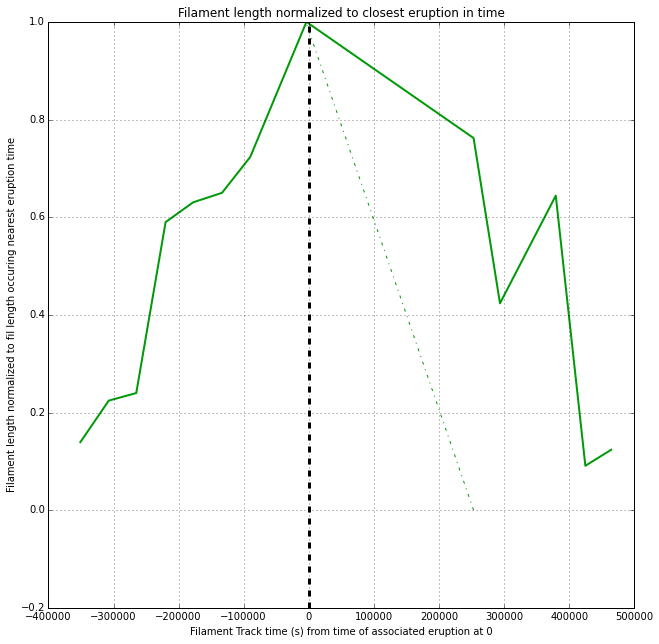

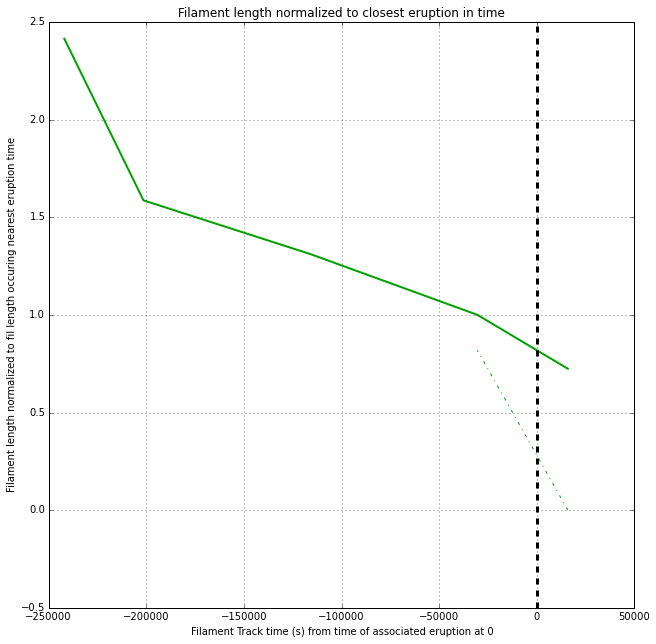

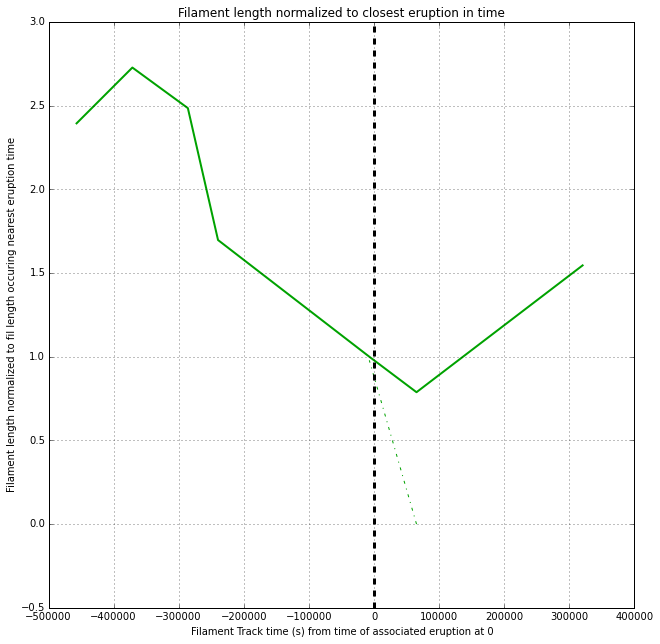

This filament erupted and disappeared


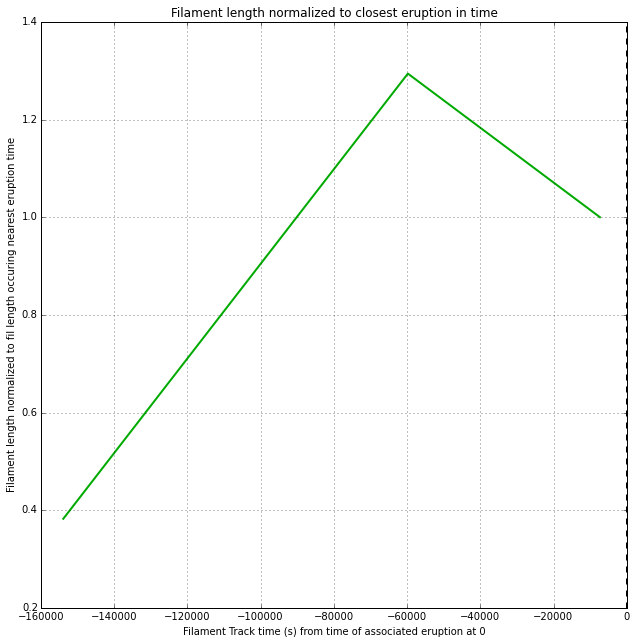

look at me!


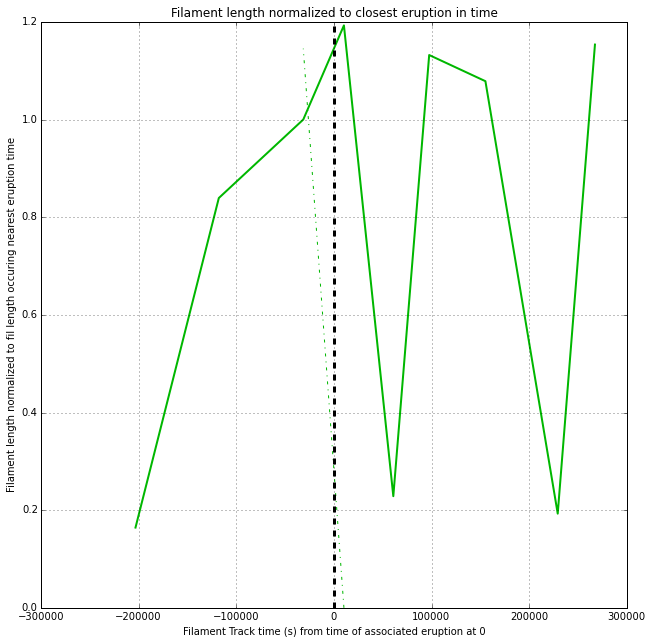

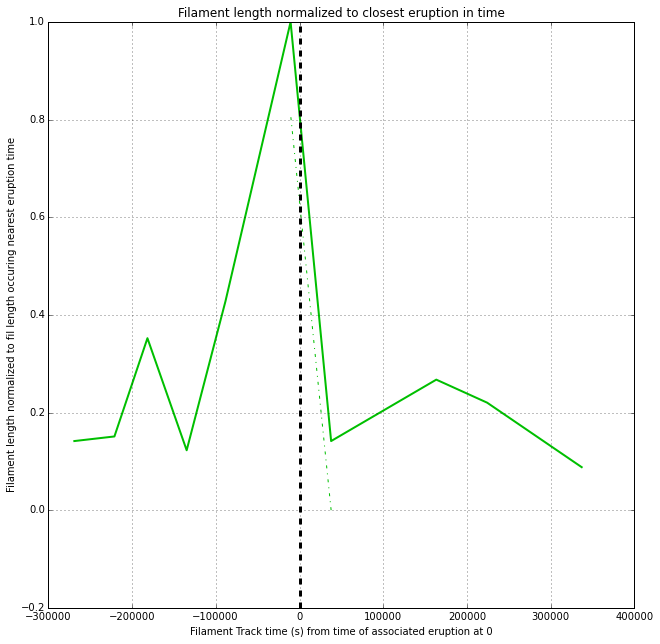

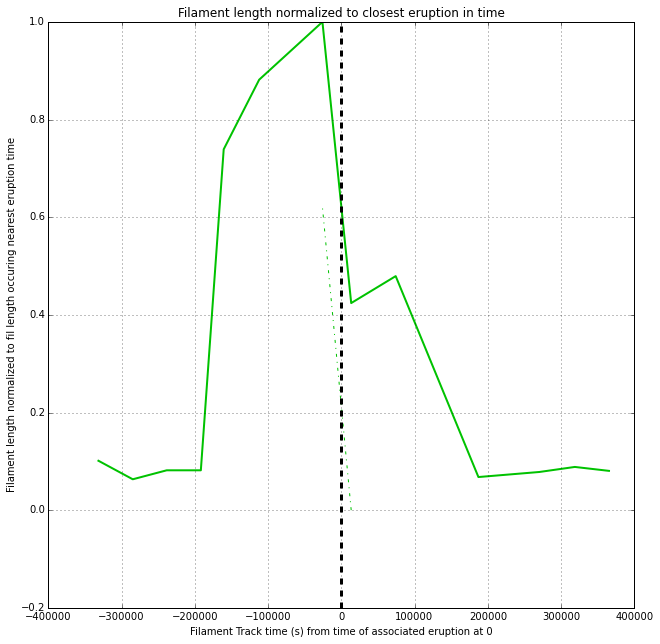

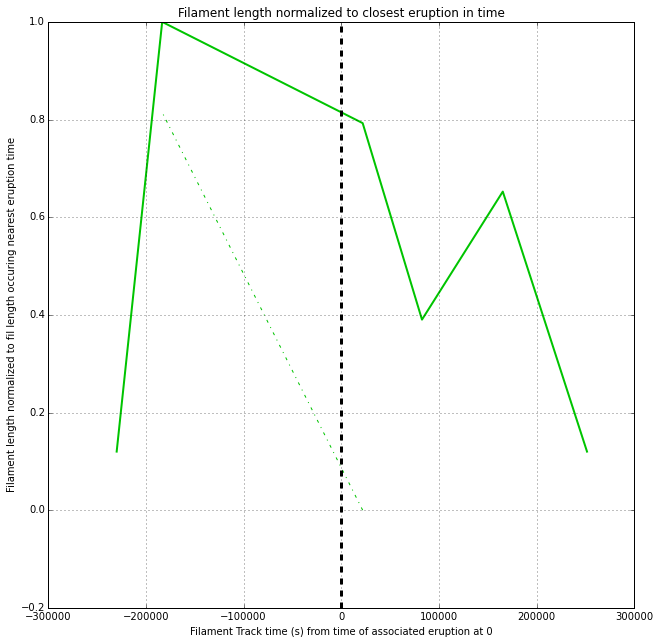

look at me!


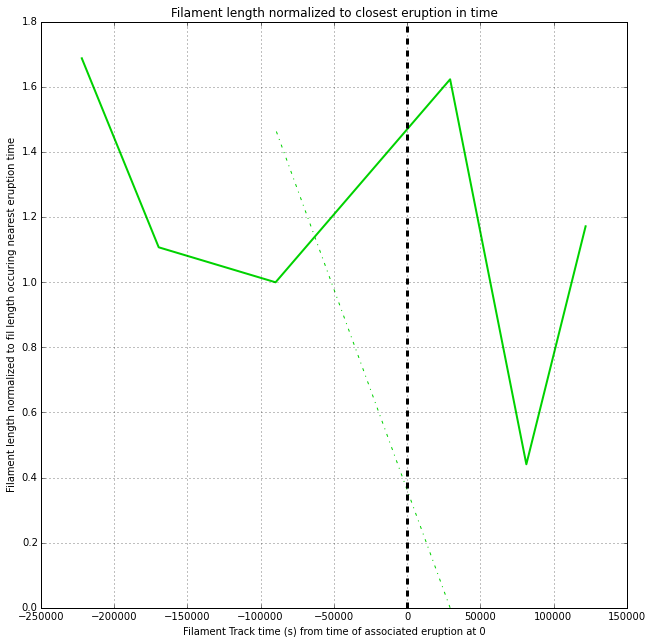

look at me!


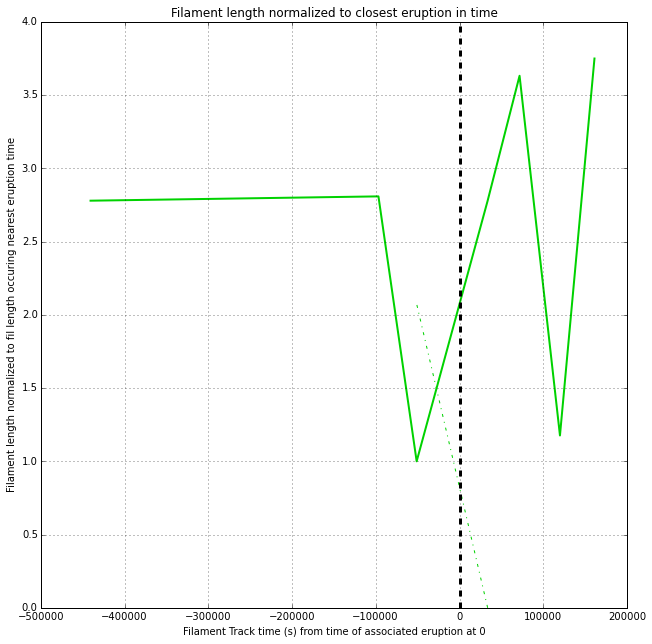

look at me!


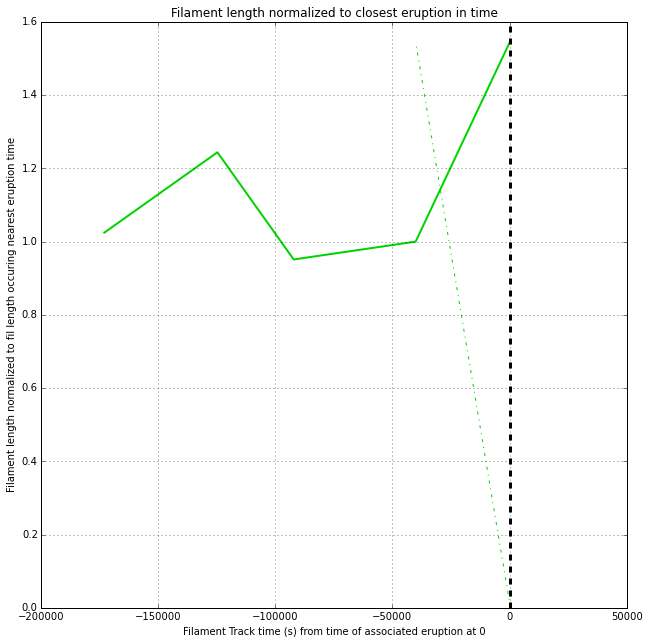

This filament erupted and disappeared


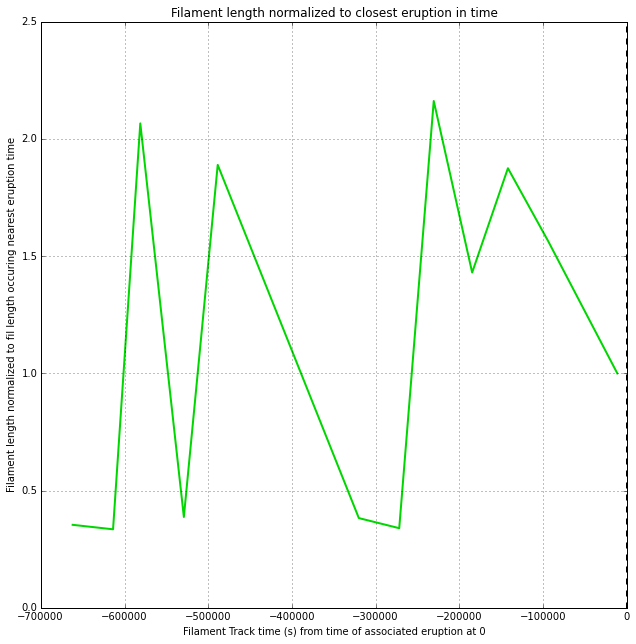

look at me!


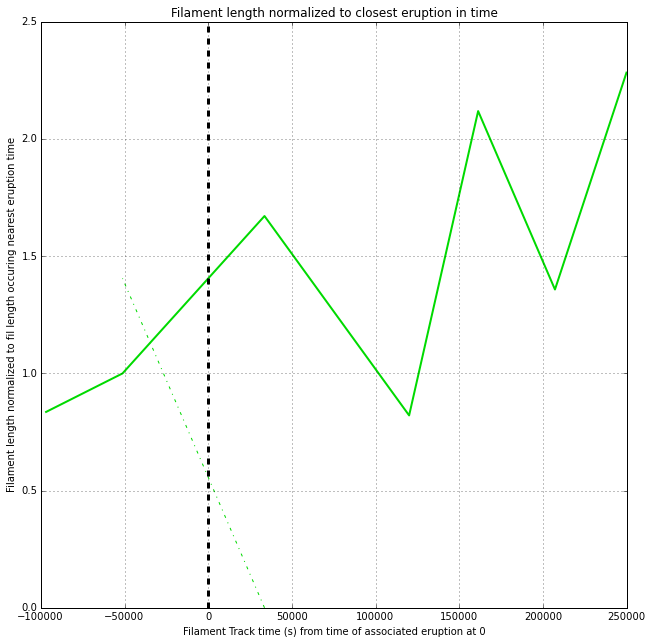

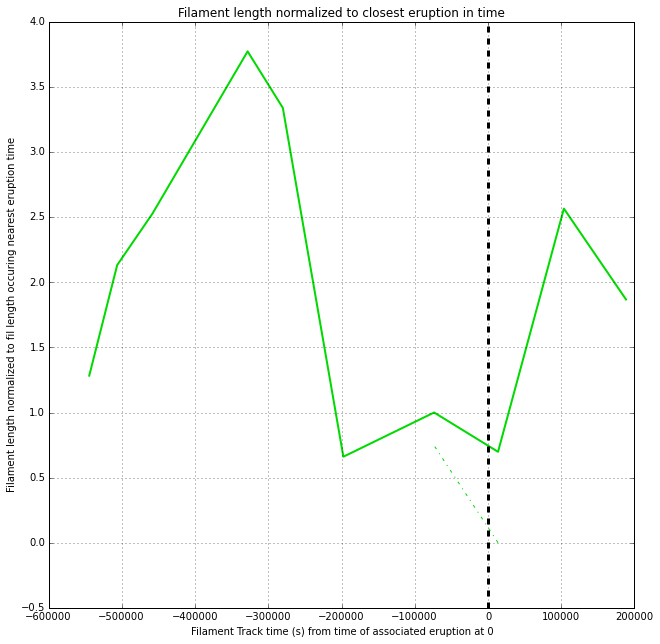

This filament erupted and disappeared


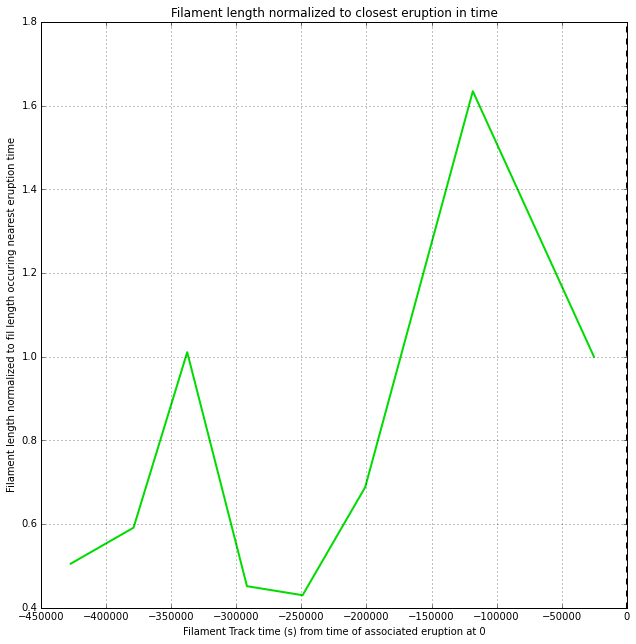

look at me!


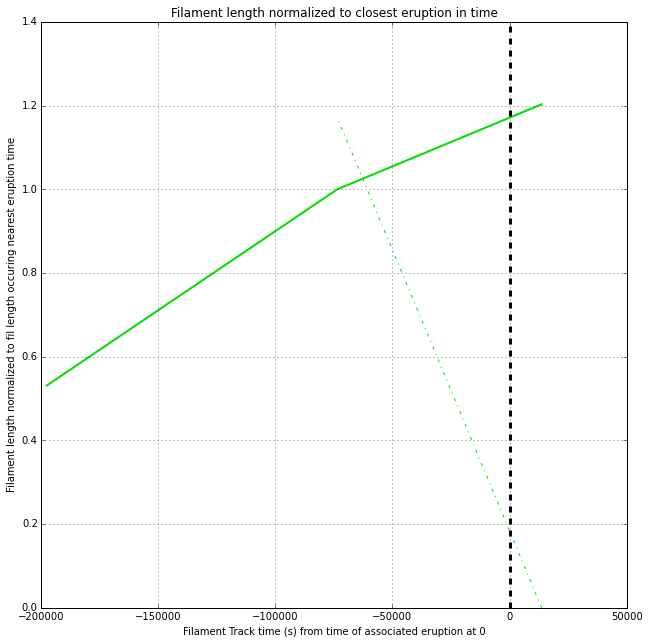

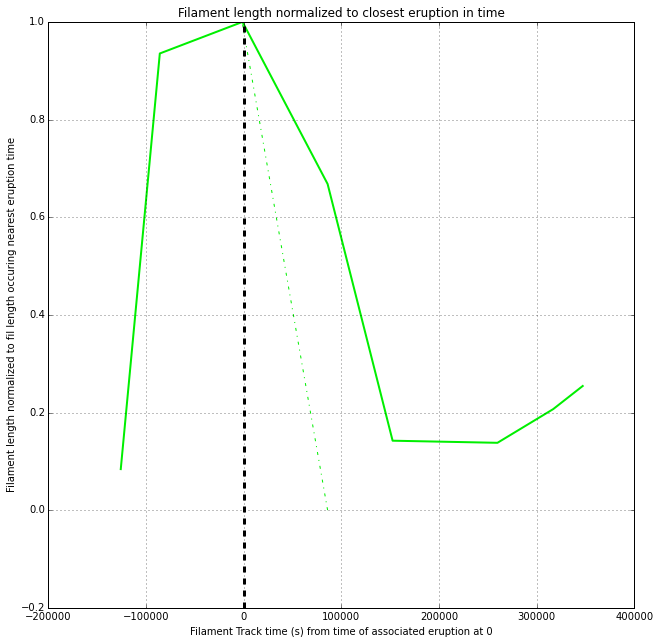

look at me!


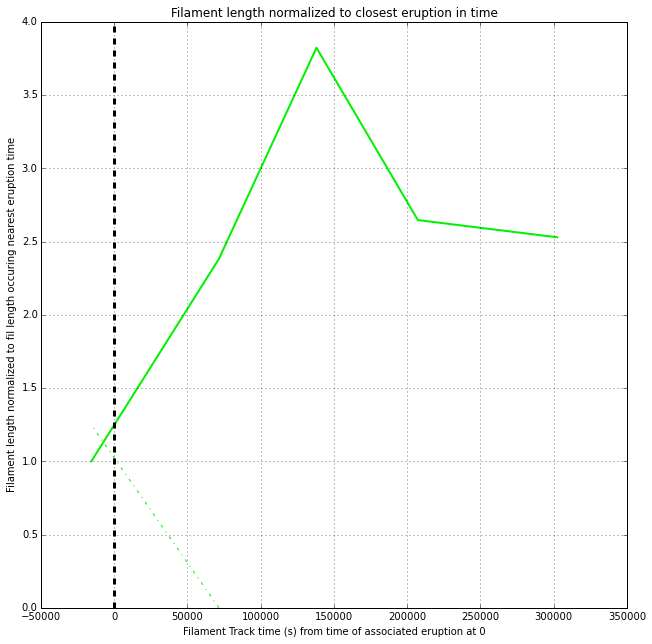

look at me!


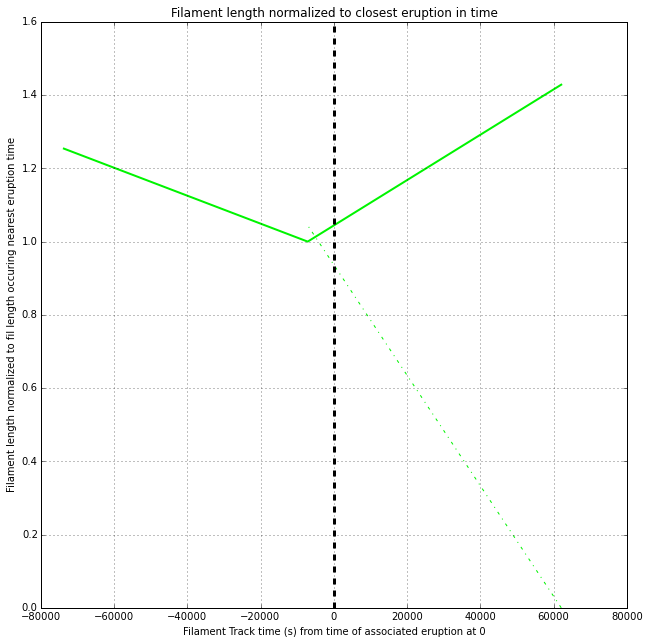

look at me!


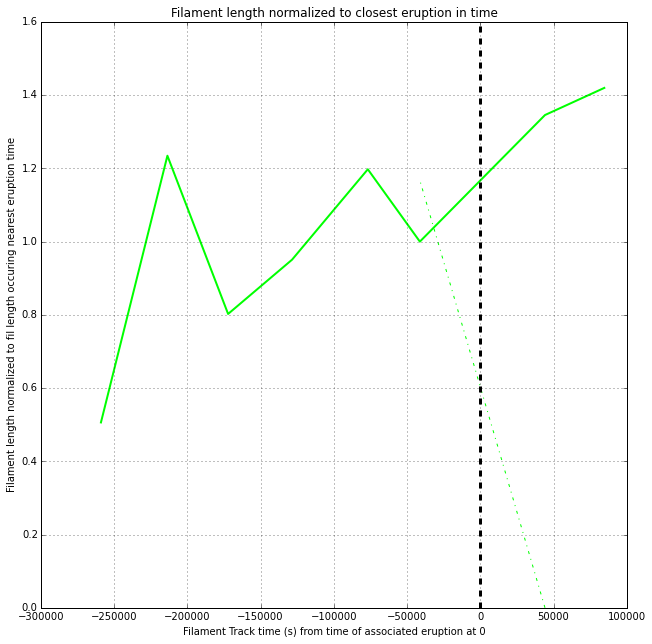

This filament erupted and disappeared


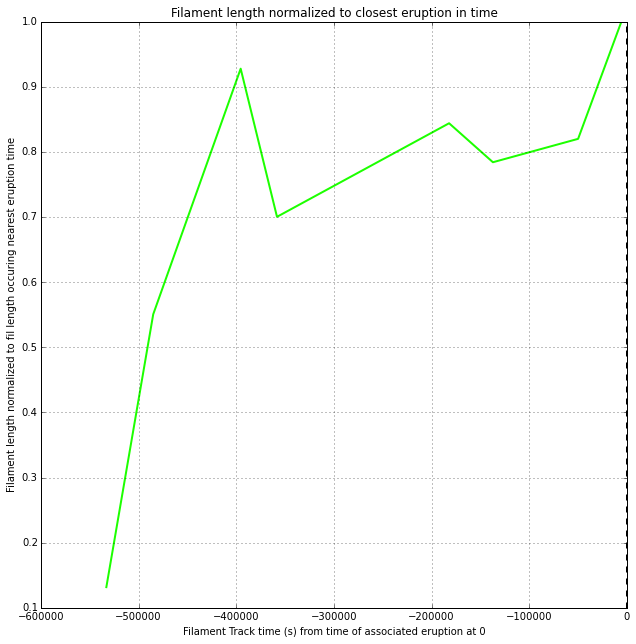

look at me!


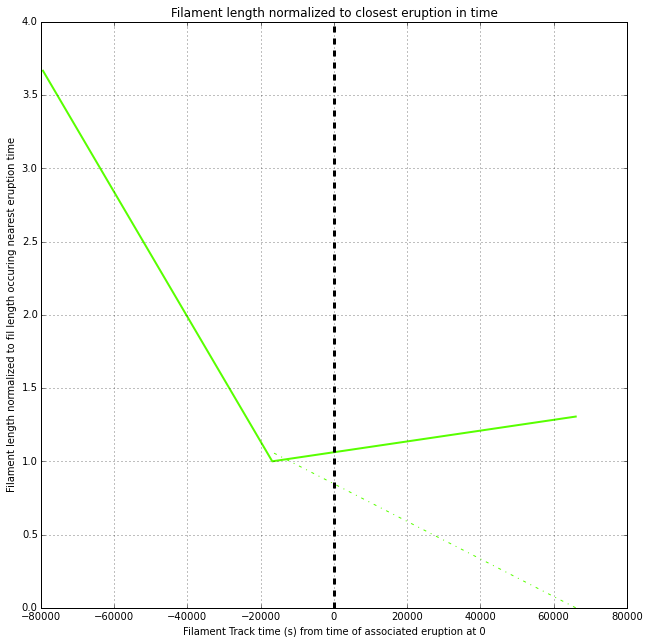

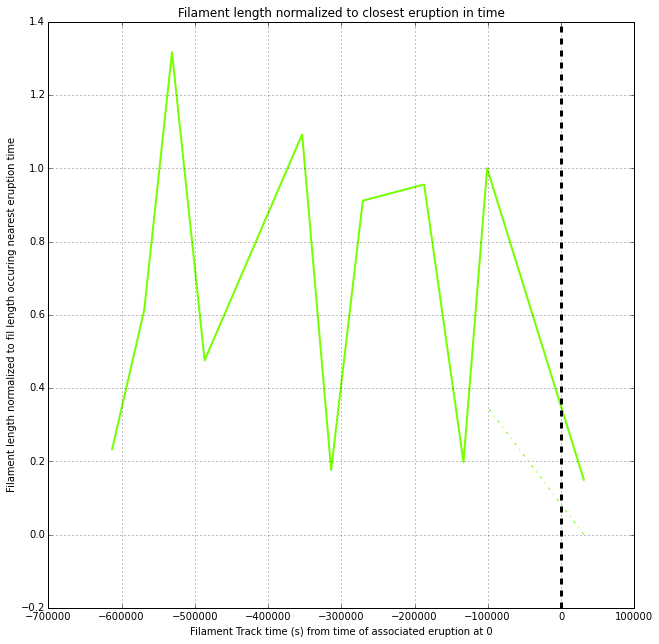

look at me!


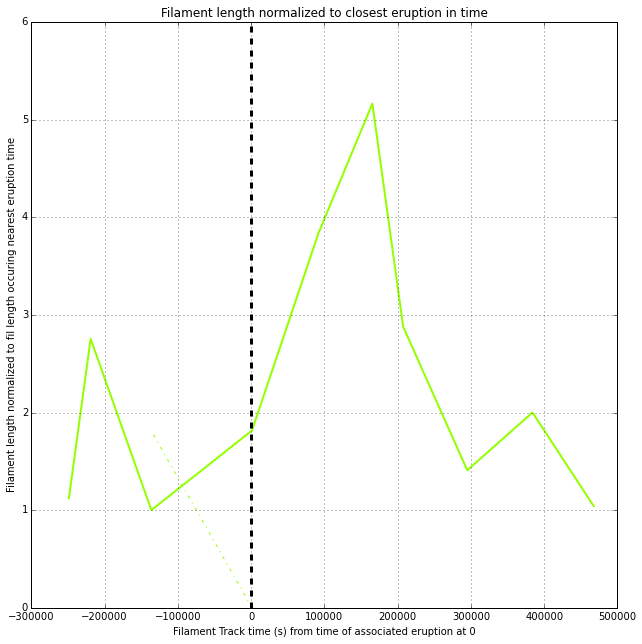

This filament erupted and disappeared


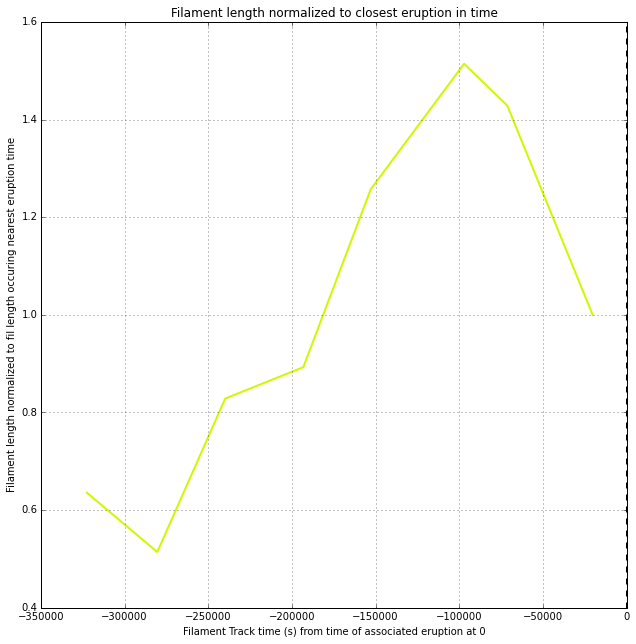

This filament erupted and disappeared


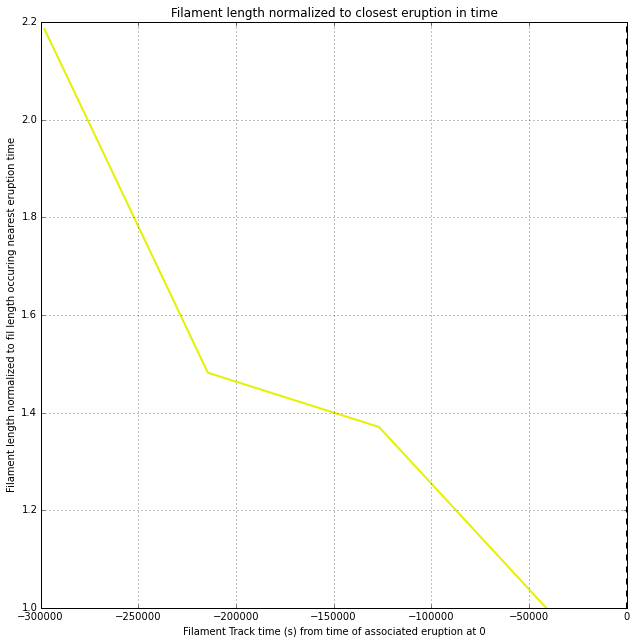

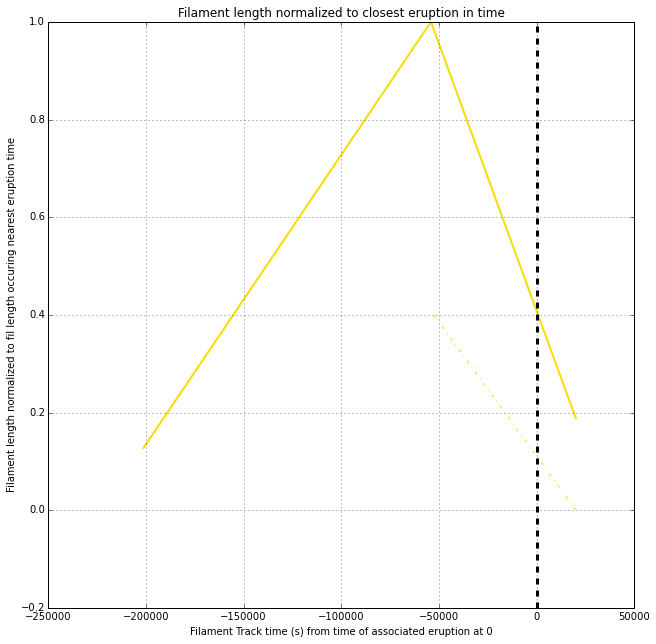

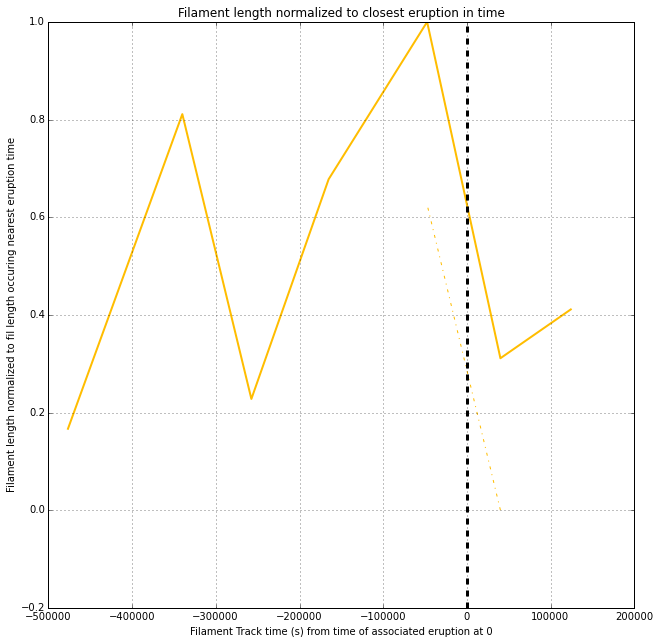

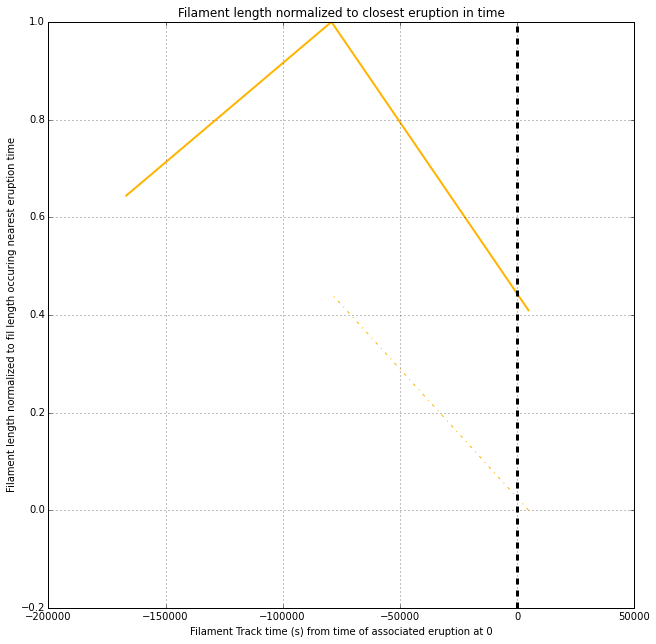

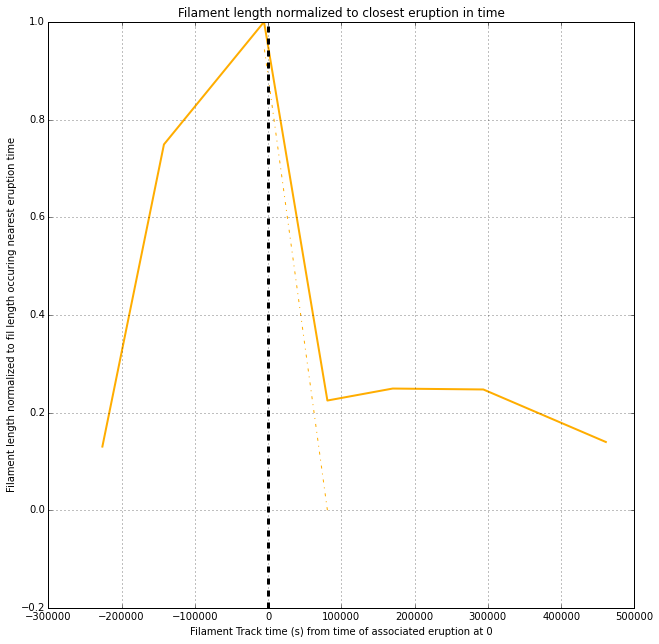

look at me!


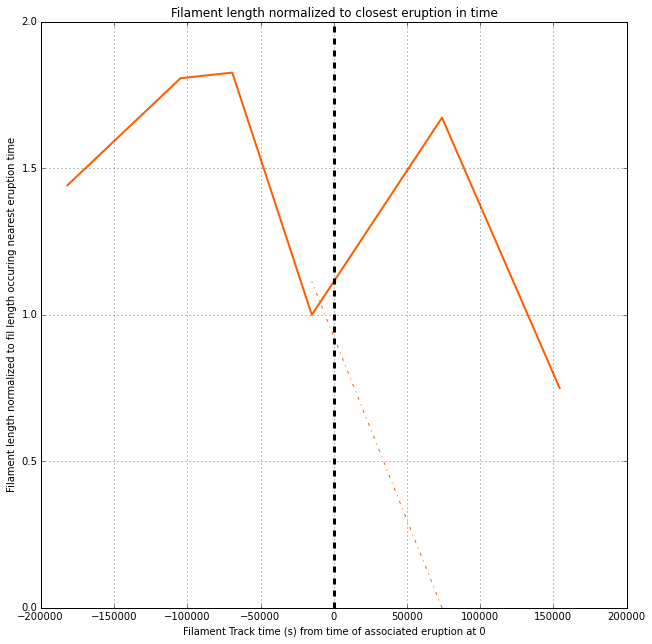

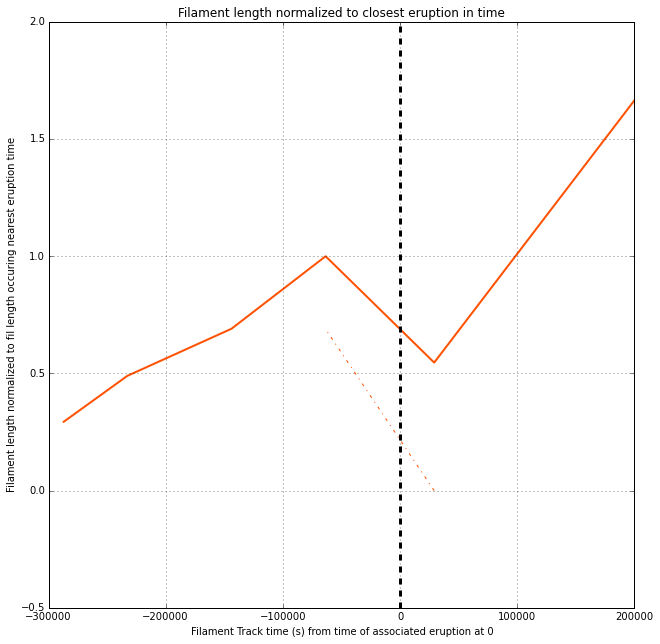

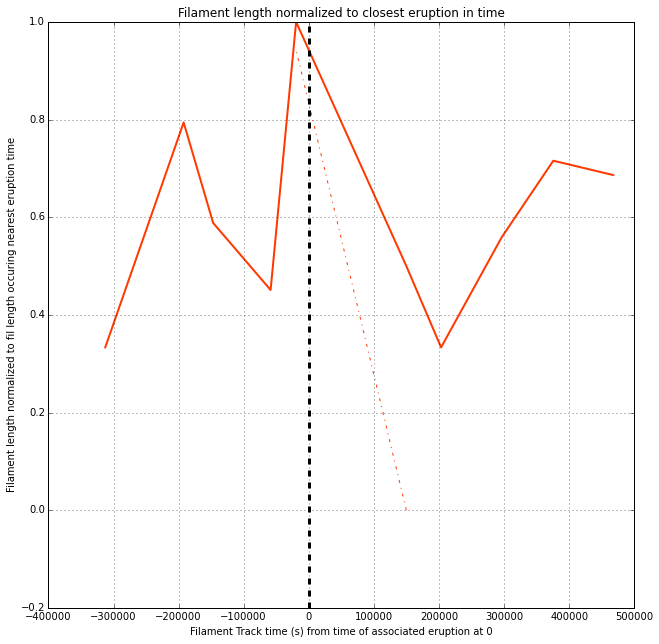

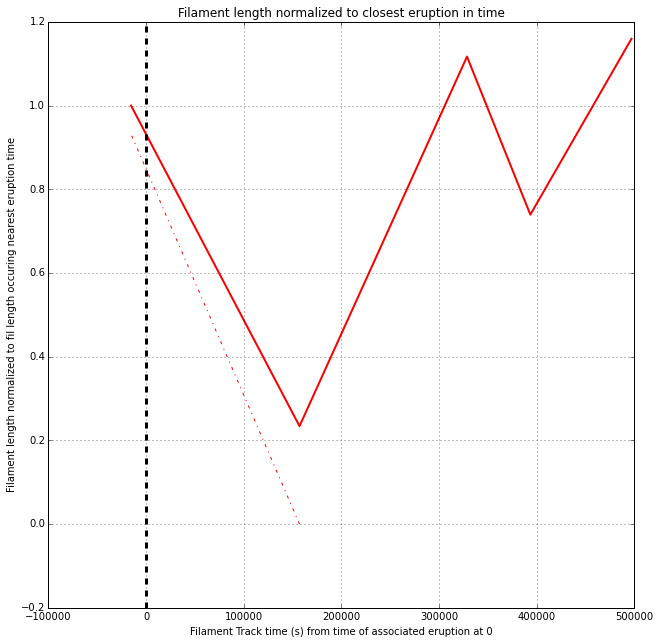

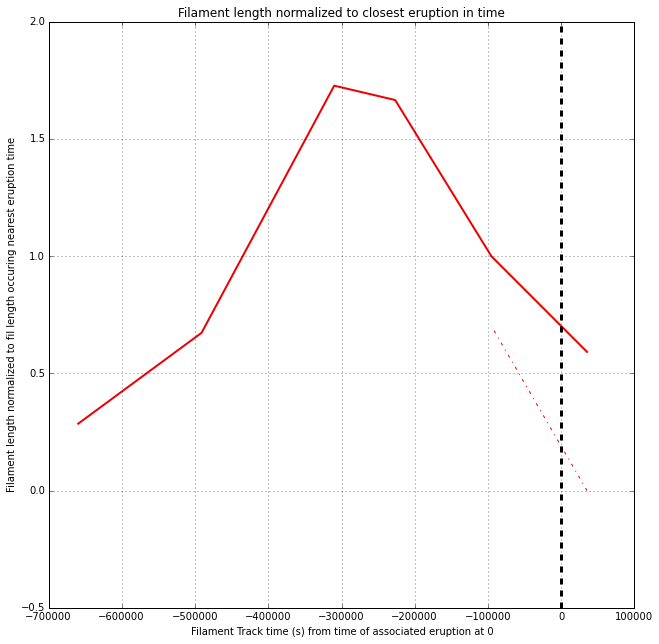

bad!


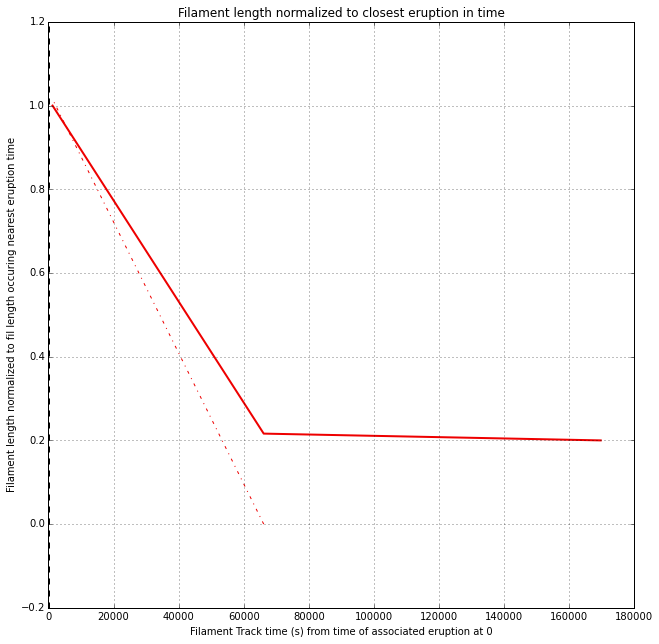

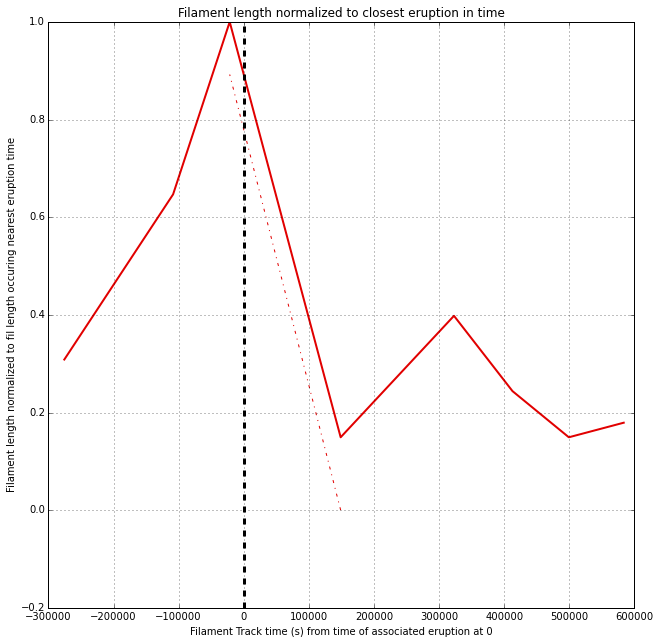

look at me!


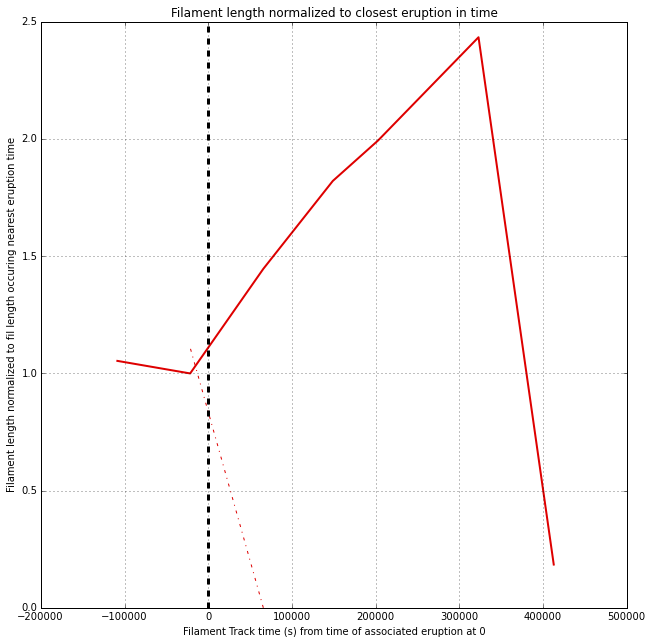

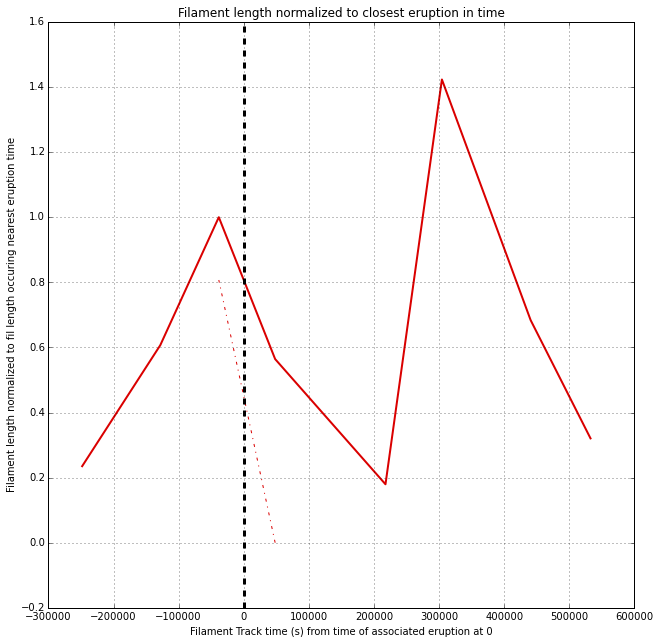

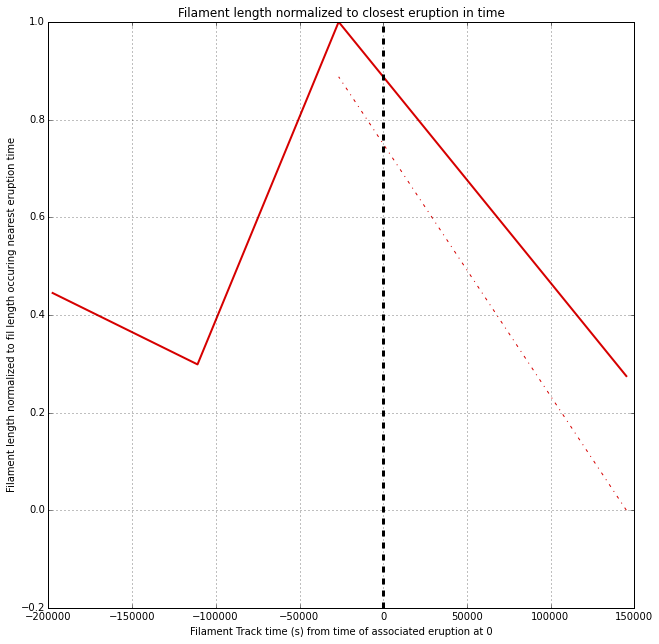

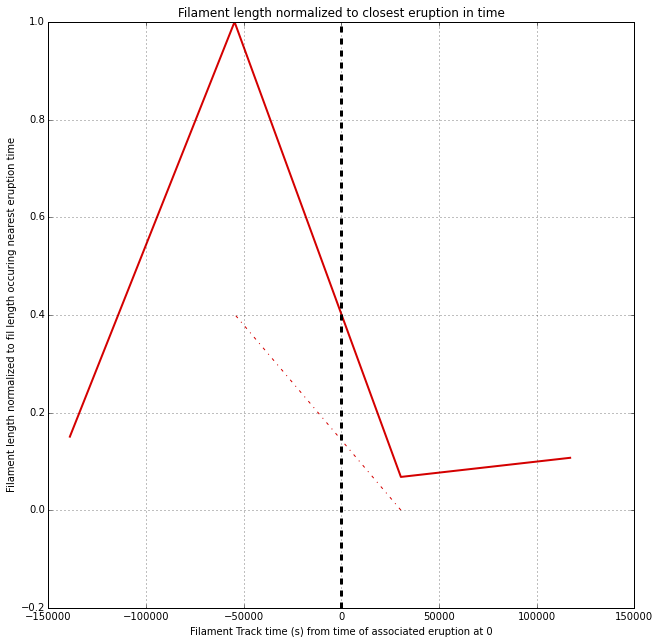

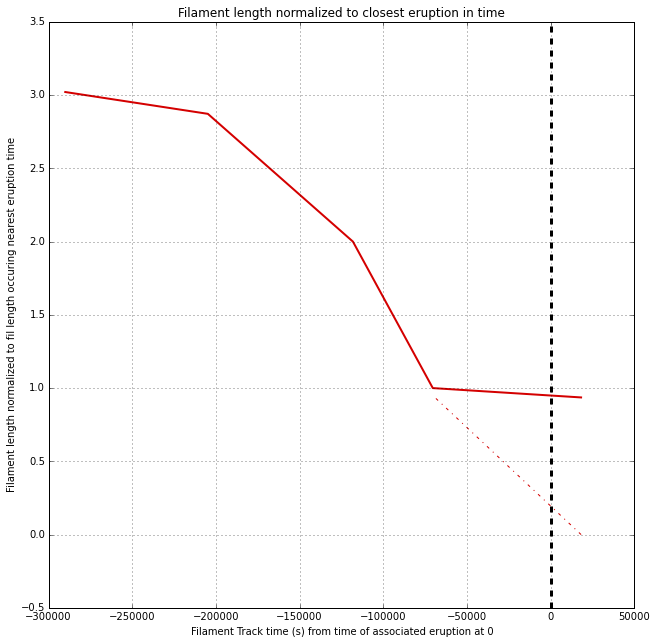

In [20]:
all_tracks=np.unique(all_tracks)
colorscale2=[]
norm = mpl.colors.Normalize(vmin=0, vmax=3500)
cmap = plt.get_cmap('nipy_spectral')
m = cm.ScalarMappable(norm=norm, cmap=cmap)
interest=[]
x=[]
y=[]
t=[]
t_abs=[]
t_neg=[]
normal=[]
lin_time_fit=[]
lin_len_fit=[]
count_bad=0
count_increase=0
count_decrease=0
count_disappear=0
bad = None 
for track in all_tracks:
    scale3=m.to_rgba(track)
    x=[] ### will be time data
    y=[] ## will be length data 
    r=[]
    t=[]
    t_abs=[]
    t_neg=[]
    interest=[]
    normal=[]
    lin_time_fit=[]
    lin_len_fit=[]
    bad = None
    for r in all_data:      #iterates through the data 
        if r[0] == track:  #finds the correct track
            if r not in interest:
                 interest.append(r)   #appends the data to a new list
    for k in range(0, len(interest)):
        t2= parse(interest[k][3])    ##eruption time
        t1=parse(interest[k][1])    #filament time
        t3=timedelta.total_seconds(t1-t2) #difference between the two in seconds
        t.append(int(t3))
        t_abs.append(abs(int(t3)))
        y.append(interest[k][2])
    for item in t:
        if item < 0:
            t_neg.append(item)
        else:
            t_neg.append(-10000000)    ###for tracks that only have positive t values 
    close_time = max(t_neg)     #finds the filament time BEFORE the eruption 
    if close_time == -10000000:
        print 'bad!'   # we have no negative values of time before the eruption 
        count_bad +=1 
        bad = True 
    #z=t.index(close_time)
        z=t_abs.index(min(t_abs))   ###finds the index of the minimum time
    else: 
        z=t.index(close_time)
    for elem in y:
        close_track=elem/y[z]    ###y[z] is the closet filament to eruption in time 
        normal.append(close_track)   ##normalized to closest filament in time
    if z+2 <= len(t):        #checks if there are points after t=0
        for j in range(z, z+2):
            lin_time_fit.append(t[j])     ###appends just the points we want for a linear fit 
            lin_len_fit.append(normal[j])
        fit = np.polyfit(lin_time_fit, lin_len_fit,1)    ##fits around zero 
        slope, intercept= fit = np.polyfit(lin_time_fit, lin_len_fit,1)   ###gets slope 
        fit_fn = np.poly1d(fit)
        if slope < 0:        #### the filament is getting smaller in length over the eruption 
            count_decrease +=1
            if bad == True:    ###checks if the filament is bad (not enough data)
                count_decrease = count_decrease -1 
        if slope >= 0:    ### the filament is getting bigger (or staying the same) over the eruption 
            print 'look at me, i am increasing!'
            count_increase +=1
            if bad == True:    ##checks if the filament is bad (not enough data)
                count_increase= count_increase -1 
        plt.plot(t, normal, '-', color=scale3, linewidth=2) 
        rev=lin_time_fit.reverse()
        plt.plot(lin_time_fit, fit_fn, '-.', color=scale3)
        plt.axvline(0, linewidth=3, color='k', linestyle='--', label='Eruption')
        plt.title('Filament length normalized to closest eruption in time')
        plt.grid(True)
        fig1 = plt.gcf()
        fig1.set_size_inches(10.5,10.5)
        plt.xlabel('Filament Track time (s) from time of associated eruption at 0')
        plt.ylabel('Filament length normalized to fil length occuring nearest eruption time')
        plt.show()
    else:
        count_disappear+=1    #the filament was not picked up again after the eruption 
        print 'This filament erupted and disappeared'
        plt.plot(t, normal, '-', color=scale3, linewidth=2)  
        plt.axvline(0, linewidth=3, color='k', linestyle='--', label='Eruption')
        plt.title('Filament length normalized to closest eruption in time')
        plt.grid(True)
        fig1 = plt.gcf()
        fig1.set_size_inches(10.5,10.5)
        plt.xlabel('Filament Track time (s) from time of associated eruption at 0')
        plt.ylabel('Filament length normalized to fil length occuring nearest eruption time')
        plt.show()
count_data=[count_decrease, count_increase, count_disappear, count_bad]

[50, 30, 14, 4]


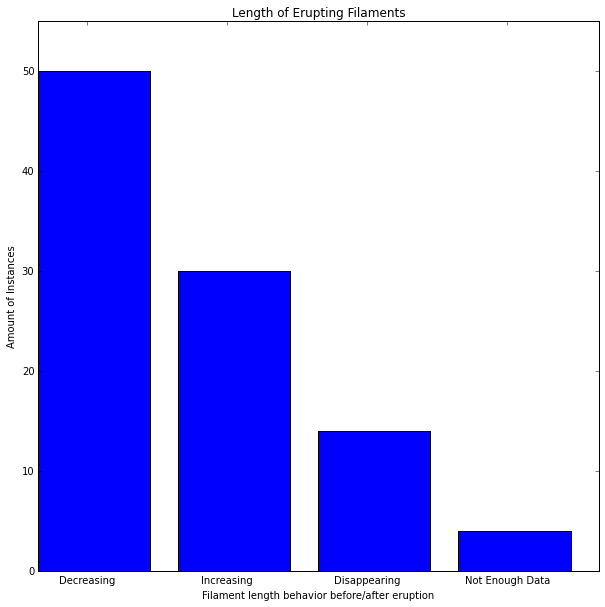

In [17]:
n_groups=4
print count_data
index = np.arange(n_groups)
bar_width = 0.35
length_labels=['Decreasing', 'Increasing', 'Disappearing', 'Not Enough Data']
plt.bar(index, count_data)
plt.xlabel('Filament length behavior before/after eruption ')
plt.ylabel('Amount of Instances')
plt.title('Length of Erupting Filaments')
plt.xticks(index + bar_width, ('Decreasing', 'Increasing', 'Disappearing', 'Not Enough Data'))
plt.ylim(0, 55)
fig1 = plt.gcf()
fig1.set_size_inches(8.5,8.5)
plt.tight_layout()
plt.show()

# Chirality analysis


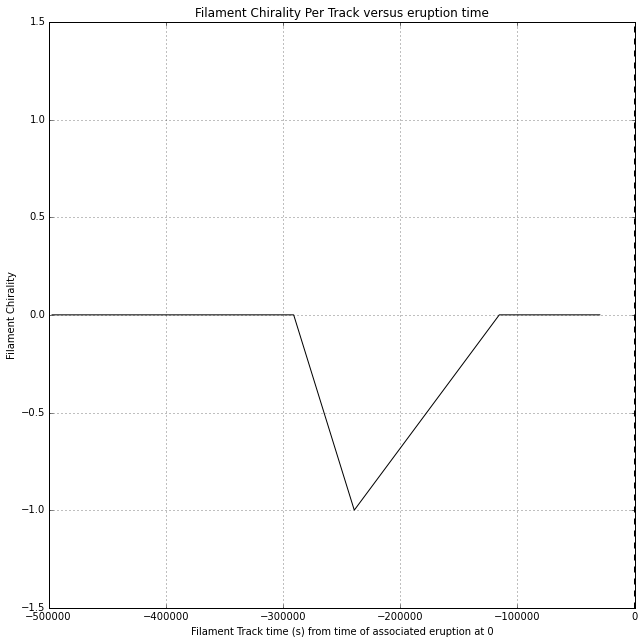

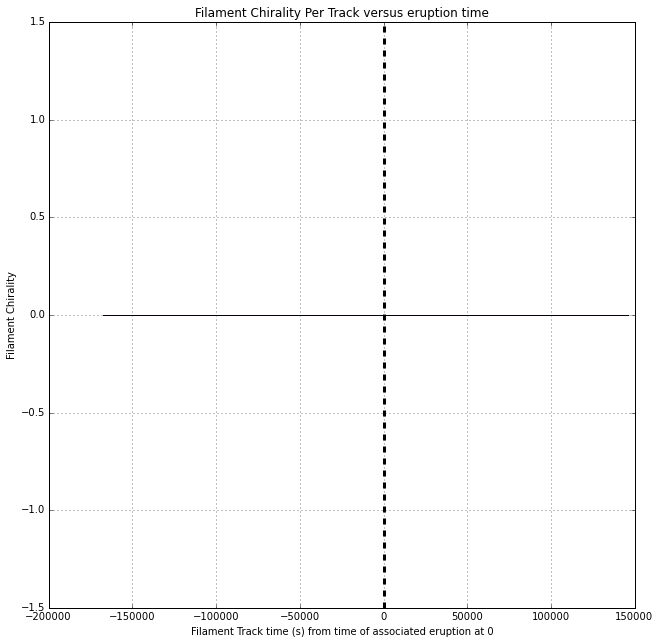

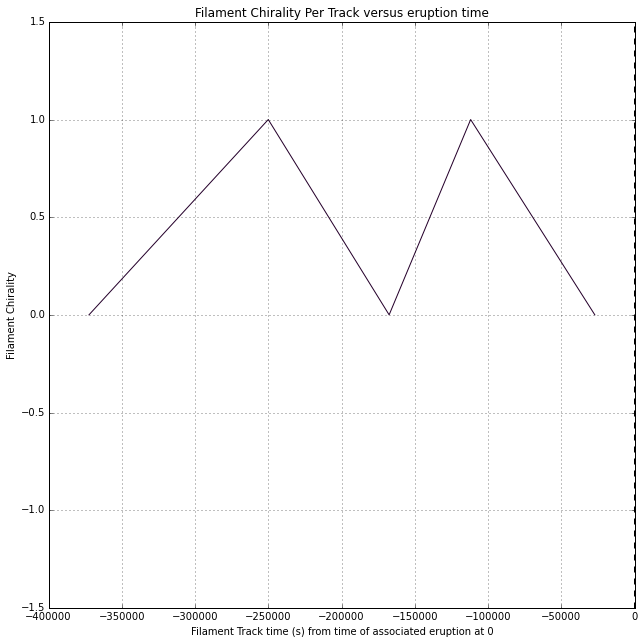

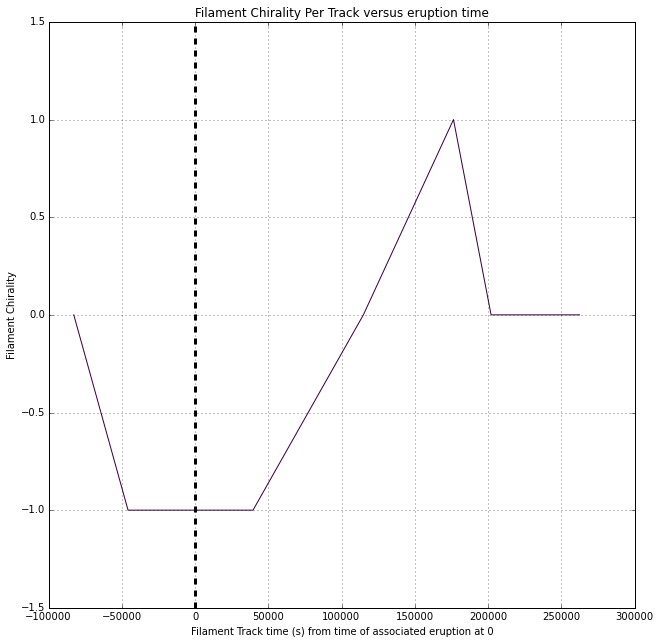

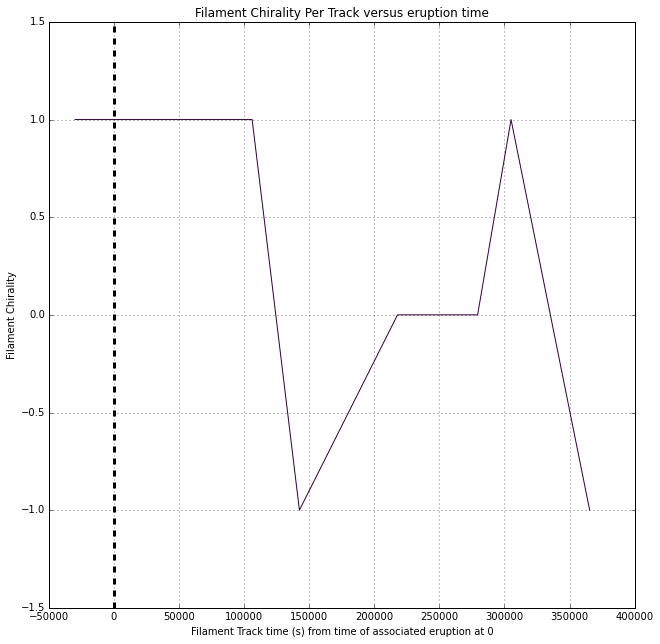

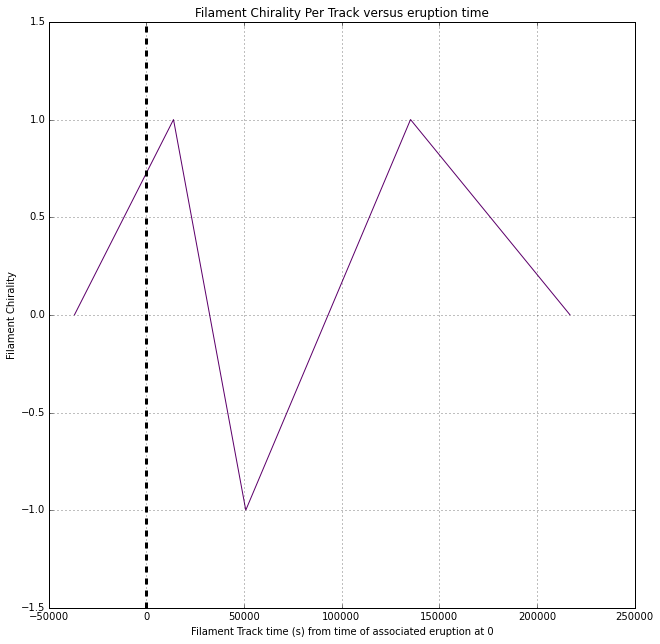

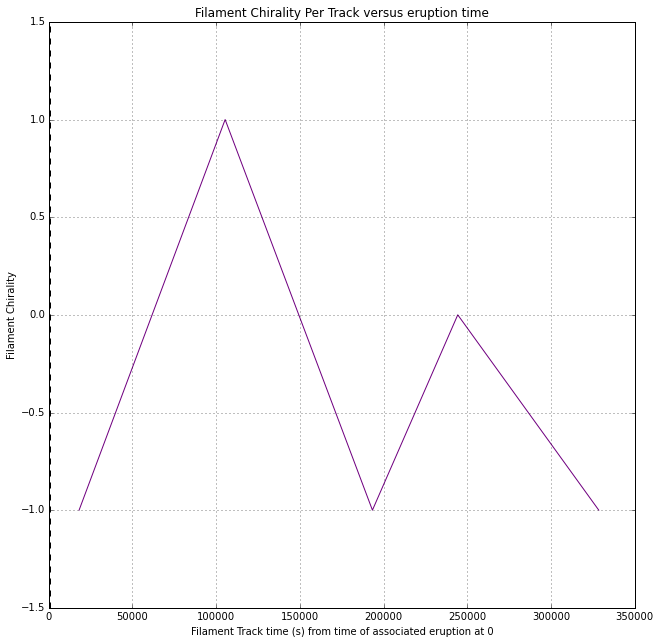

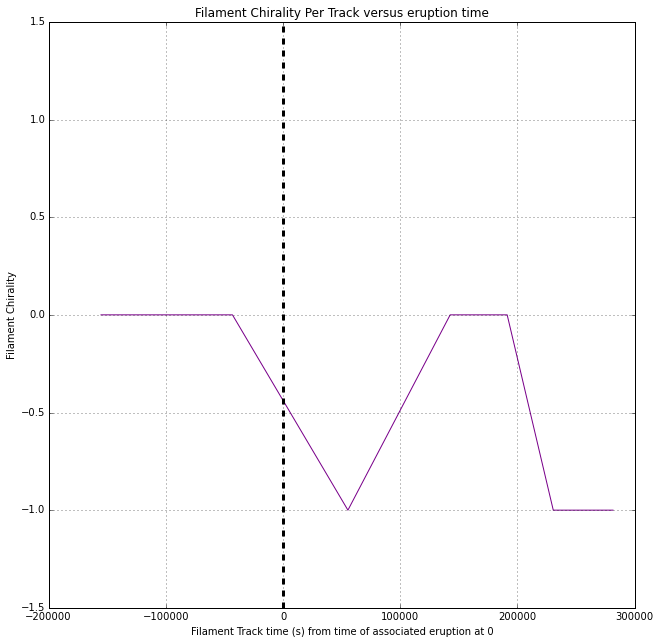

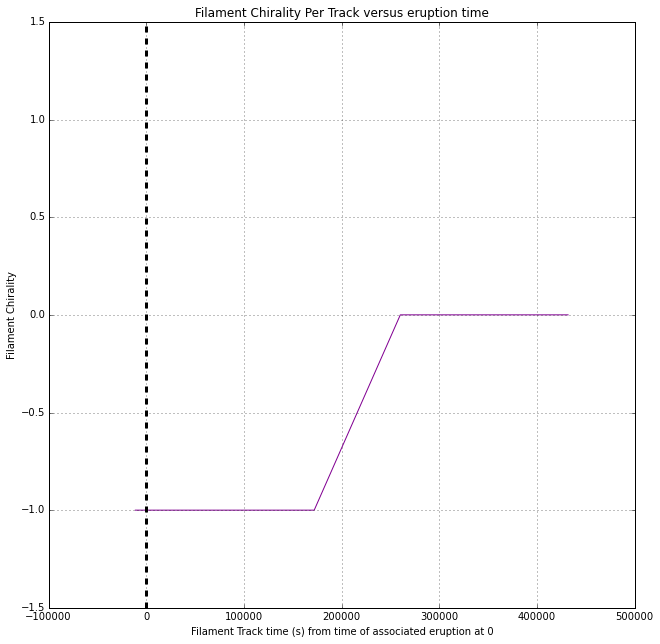

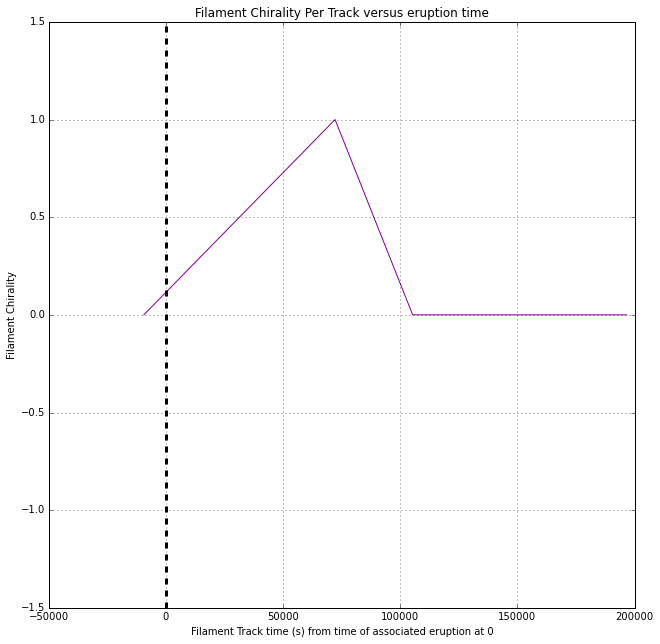

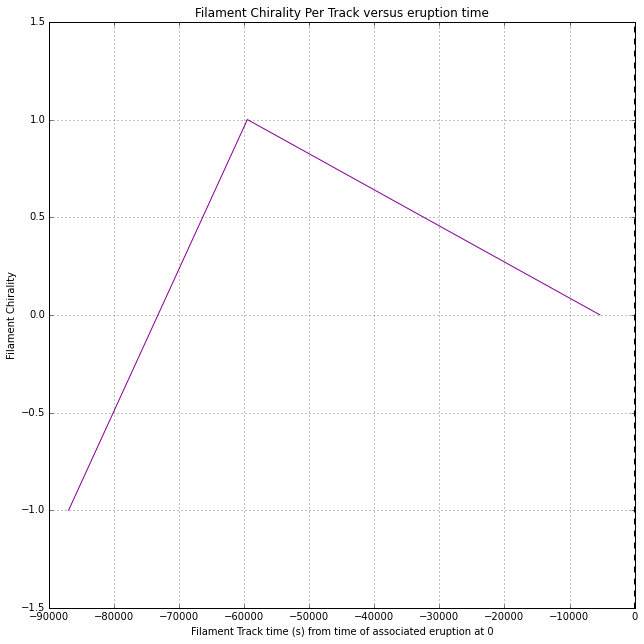

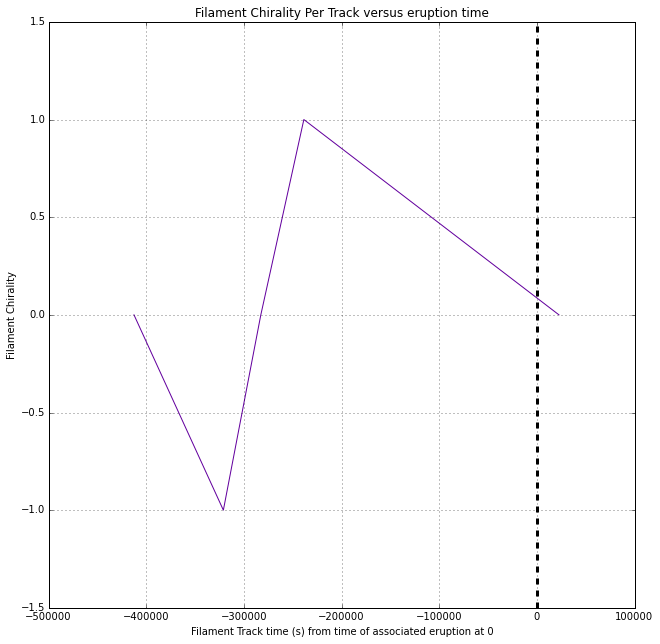

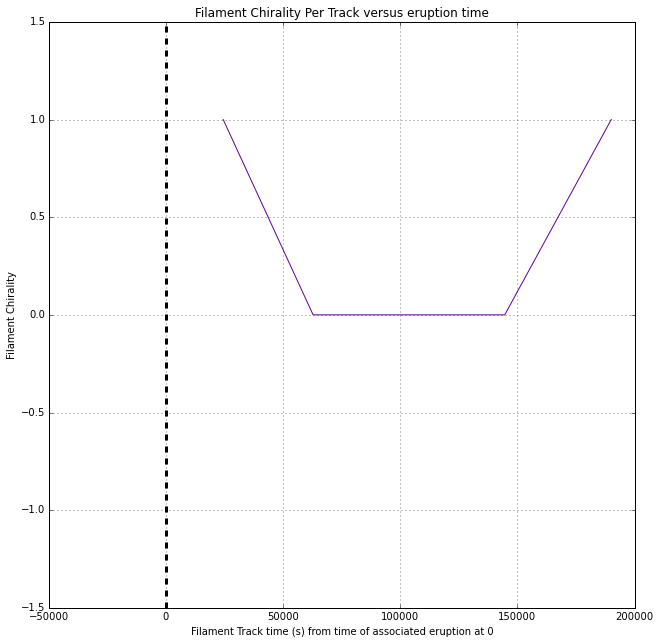

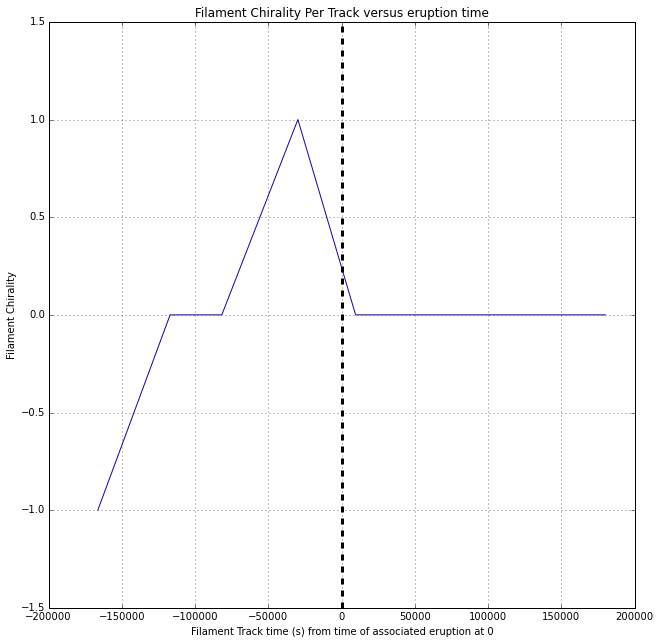

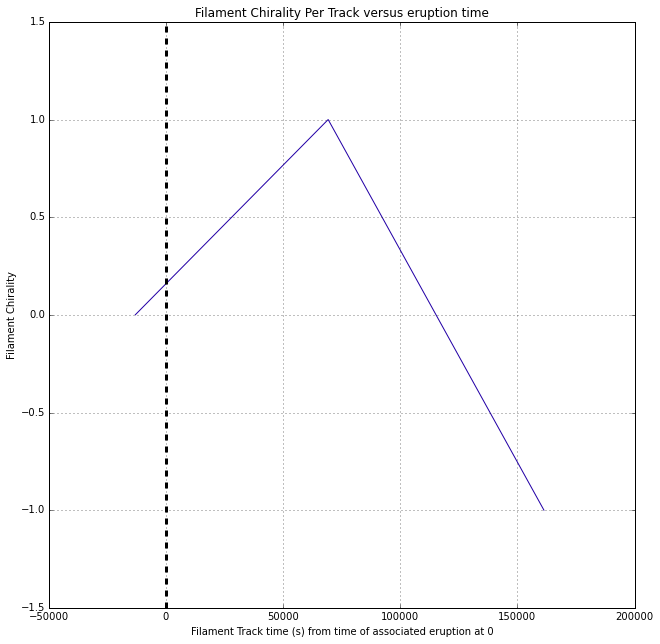

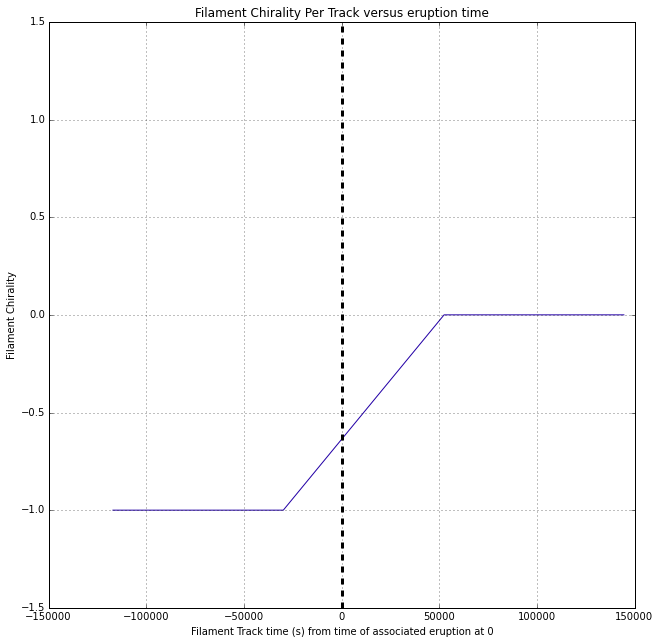

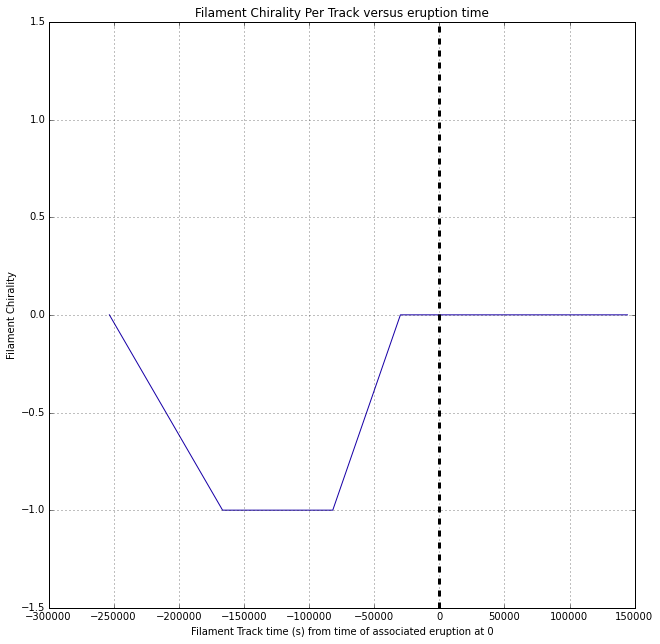

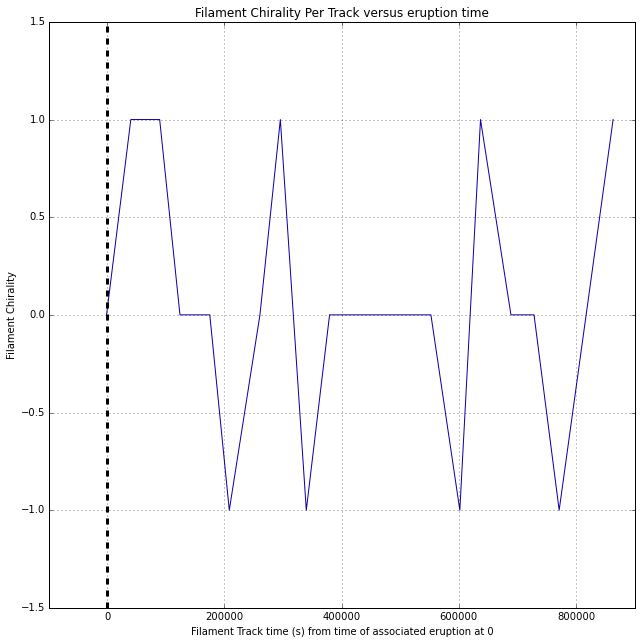

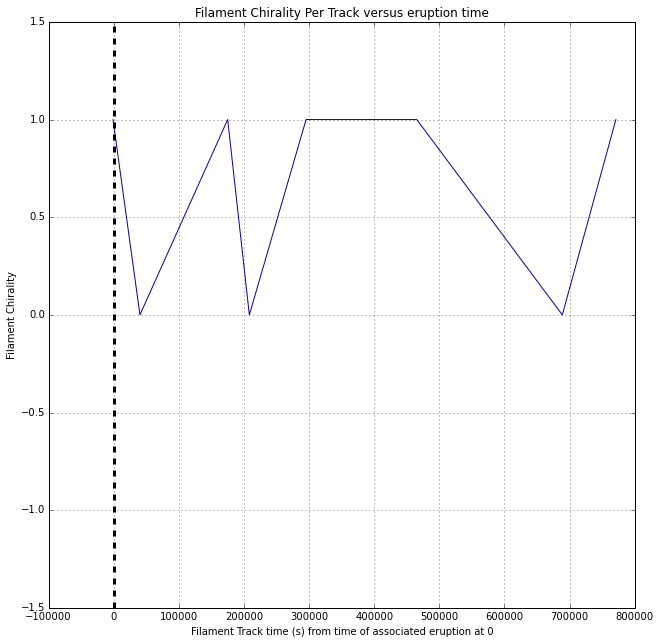

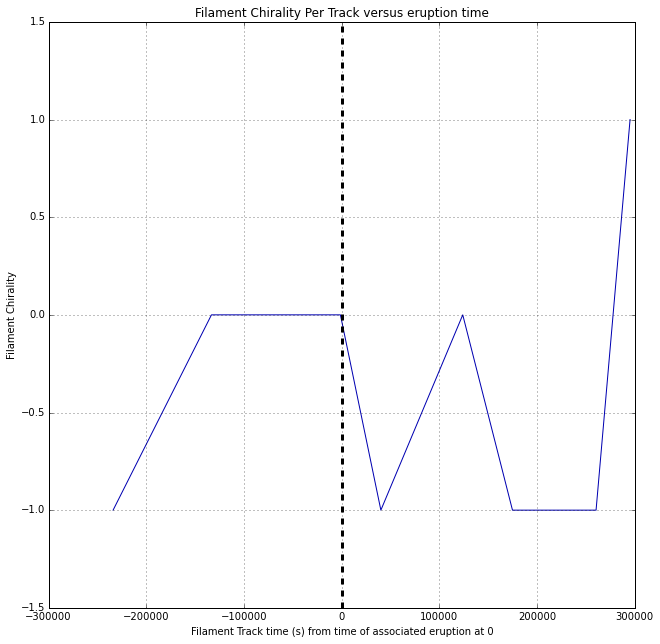

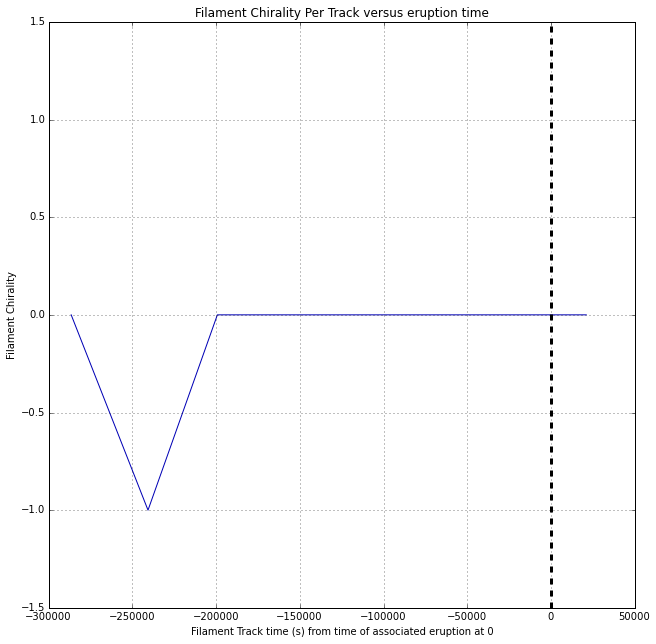

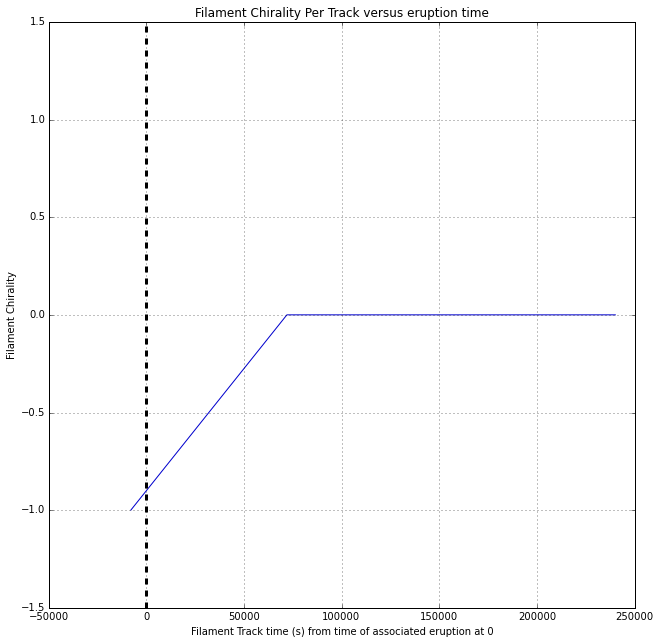

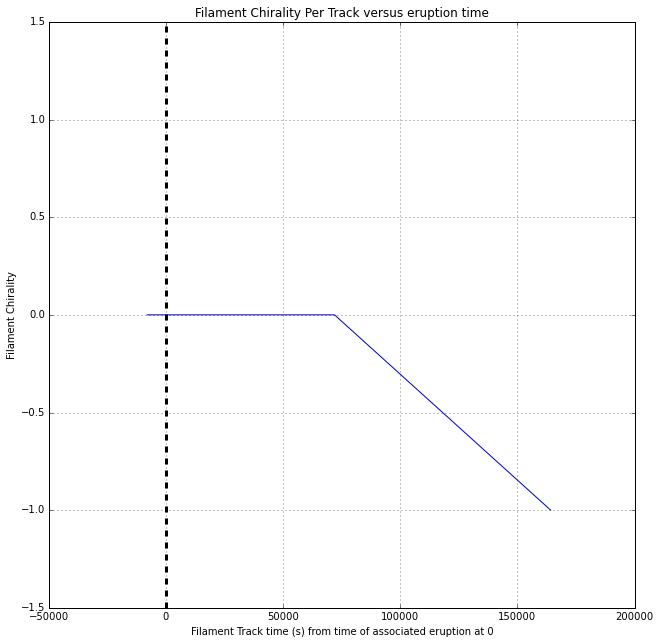

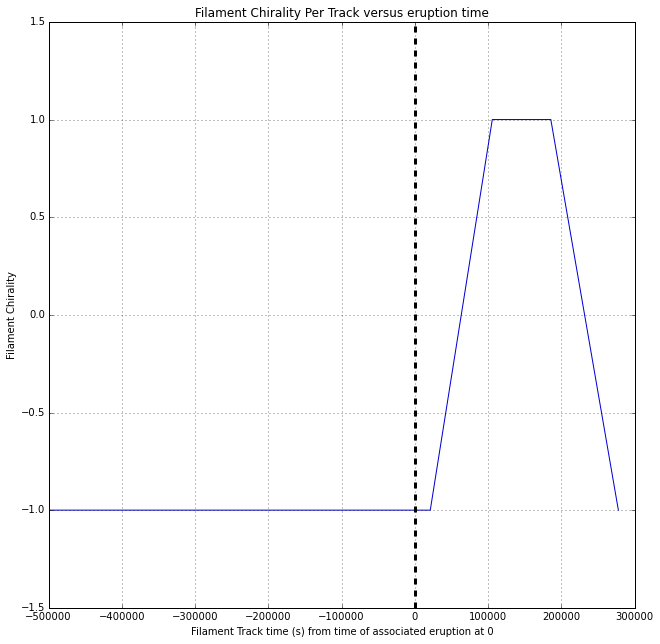

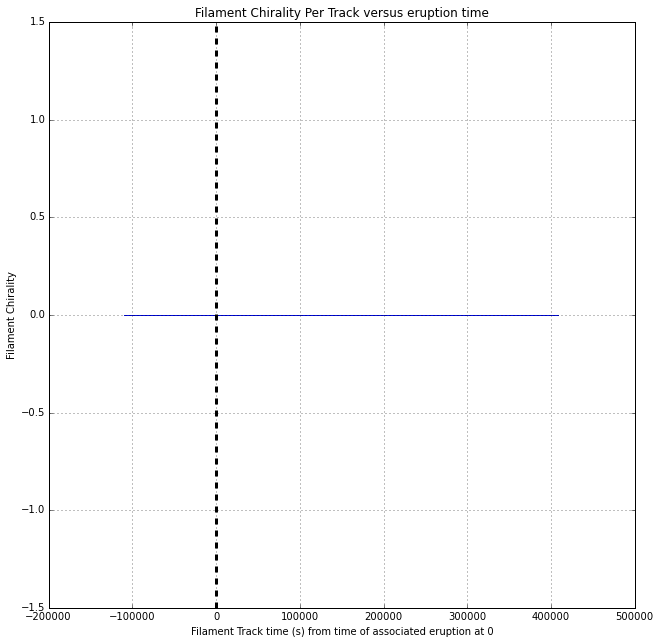

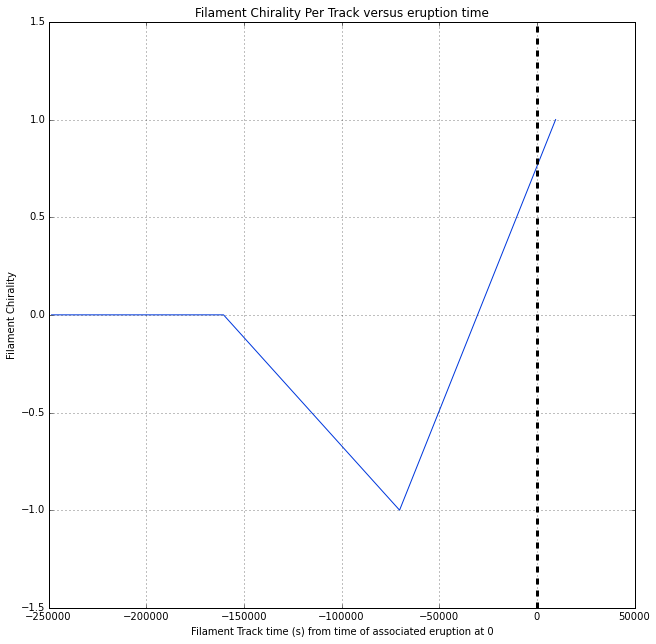

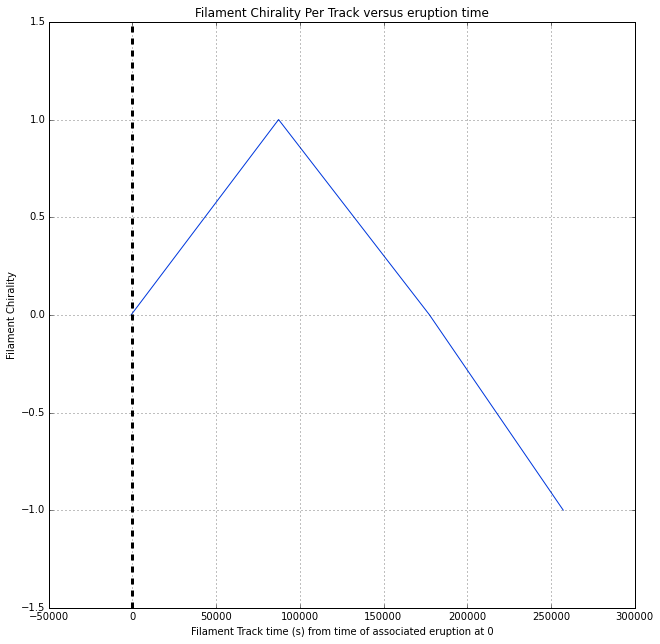

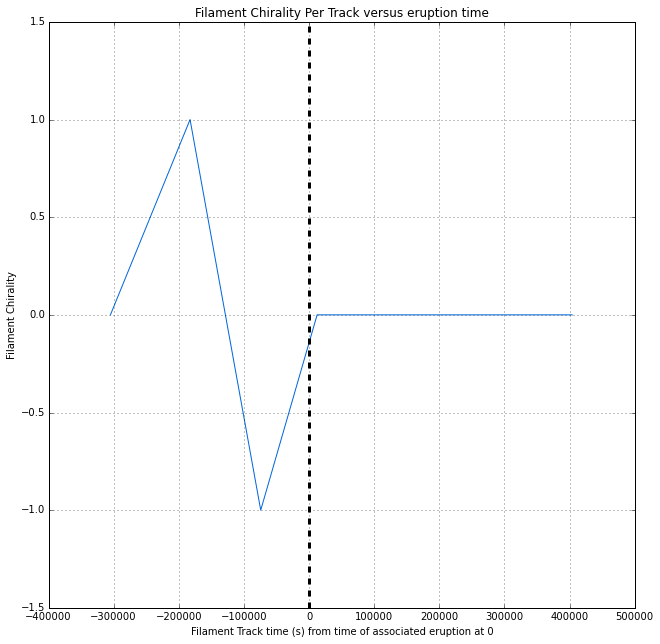

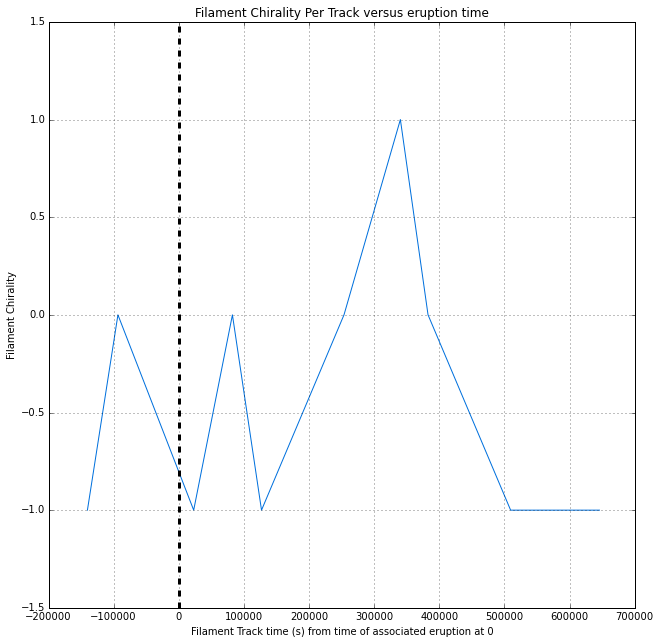

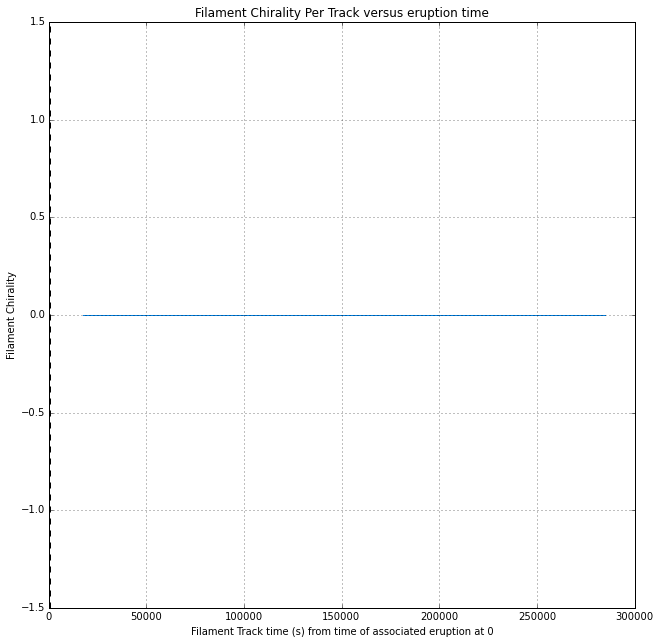

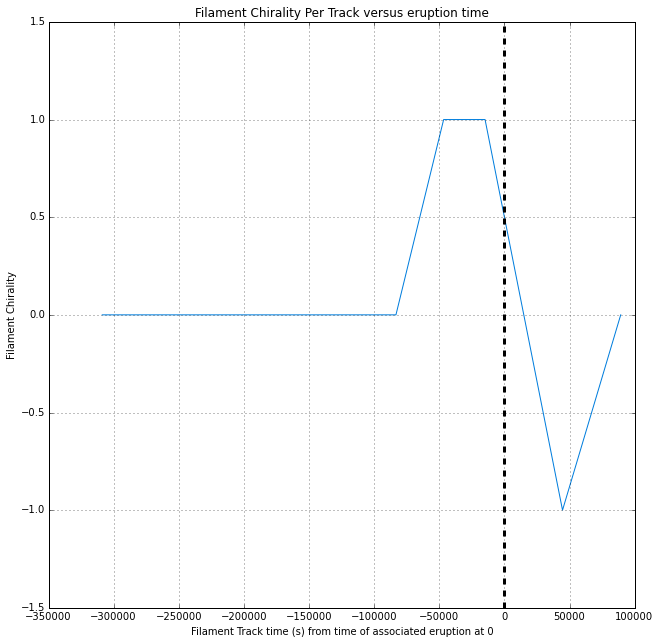

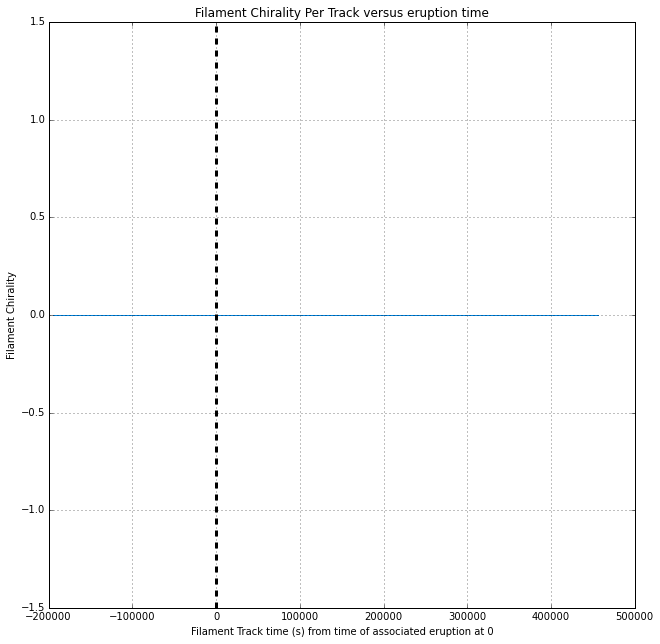

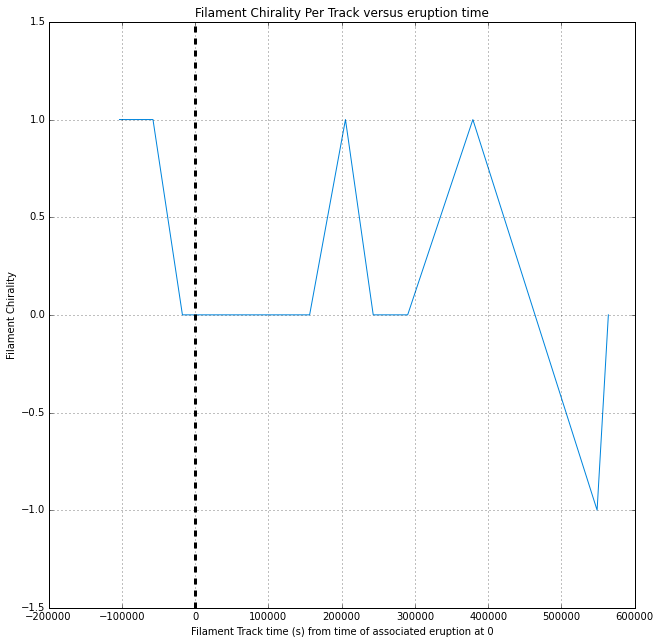

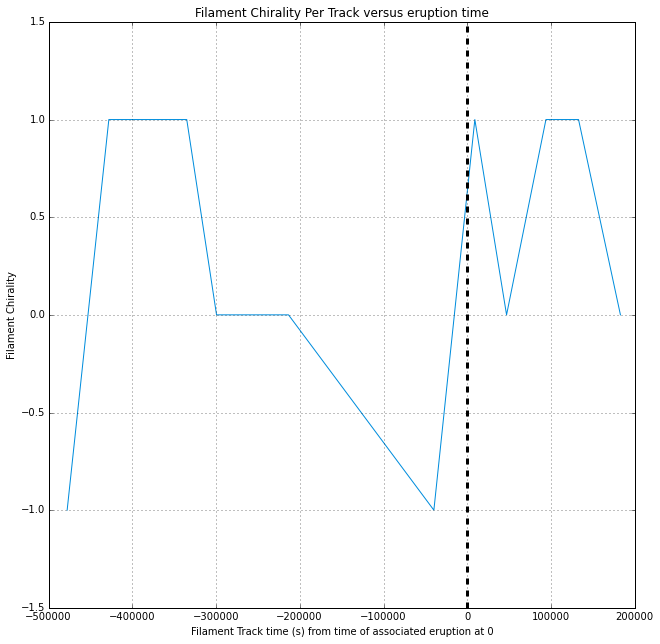

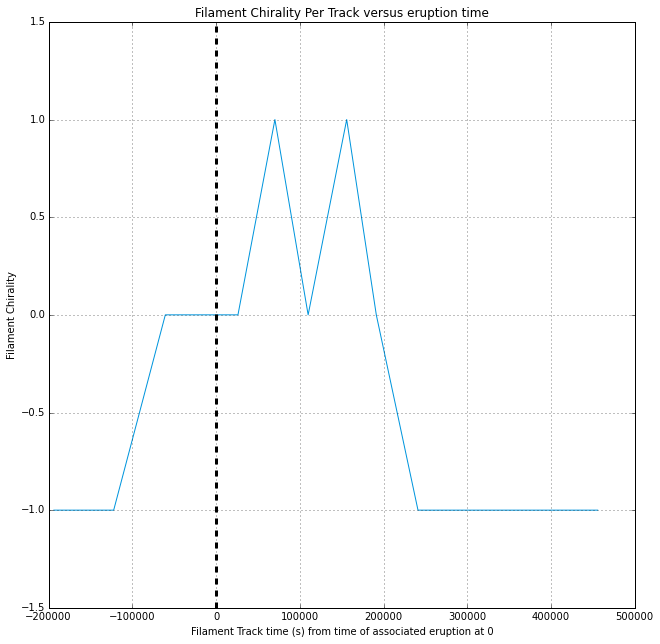

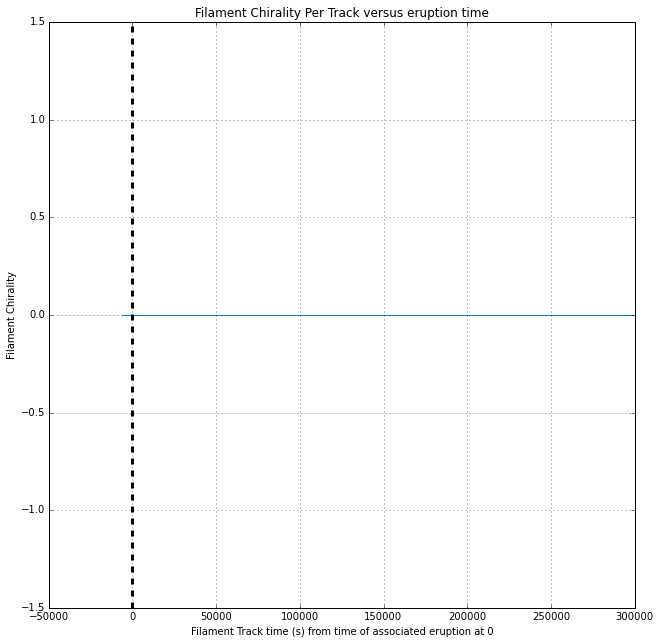

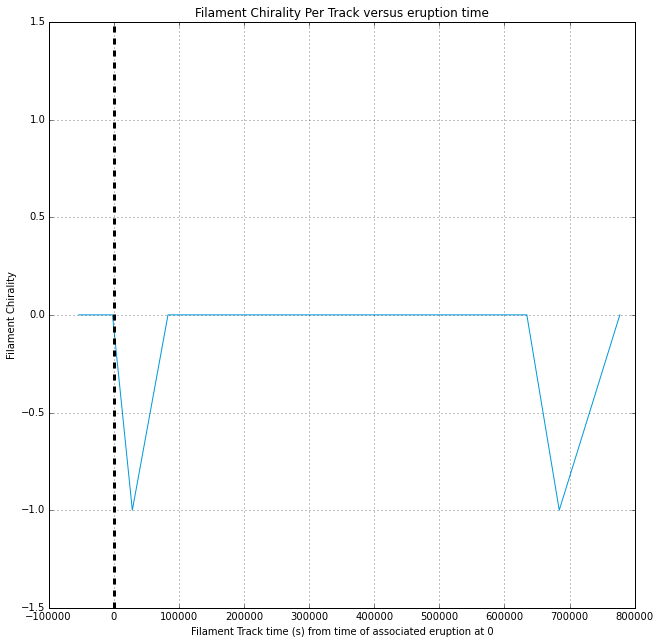

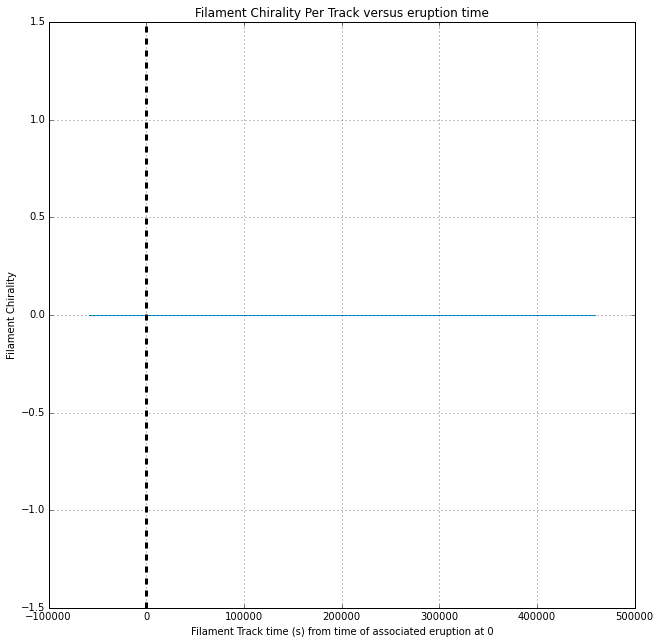

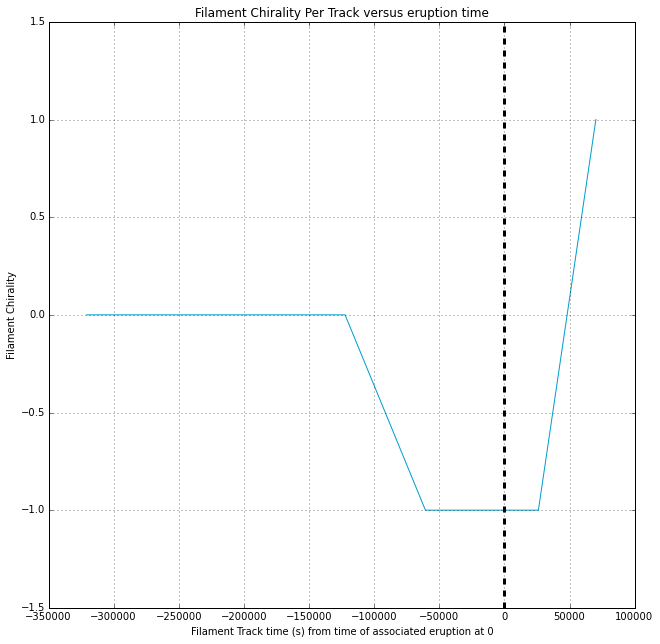

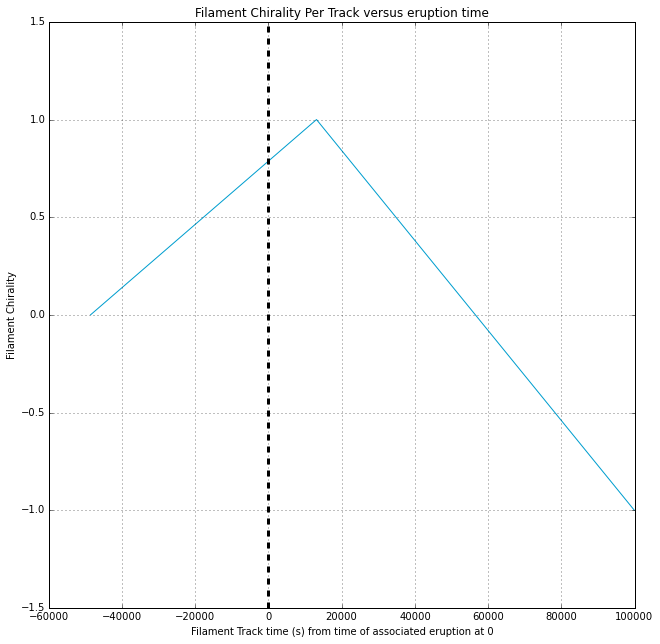

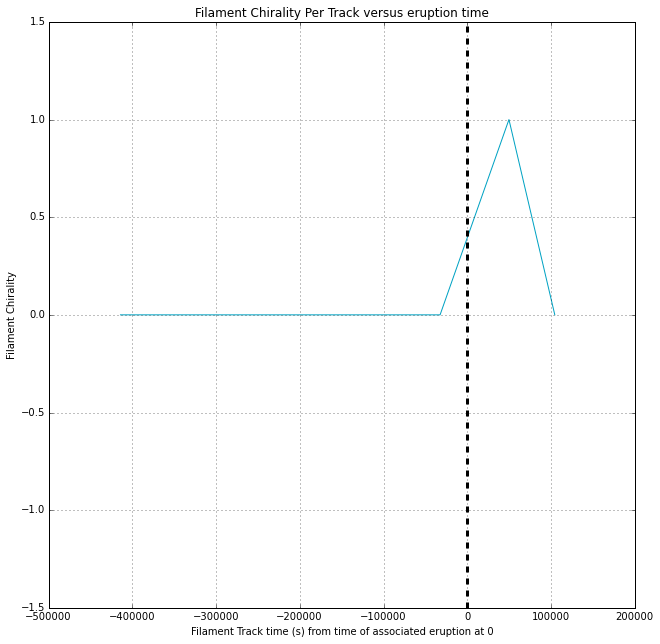

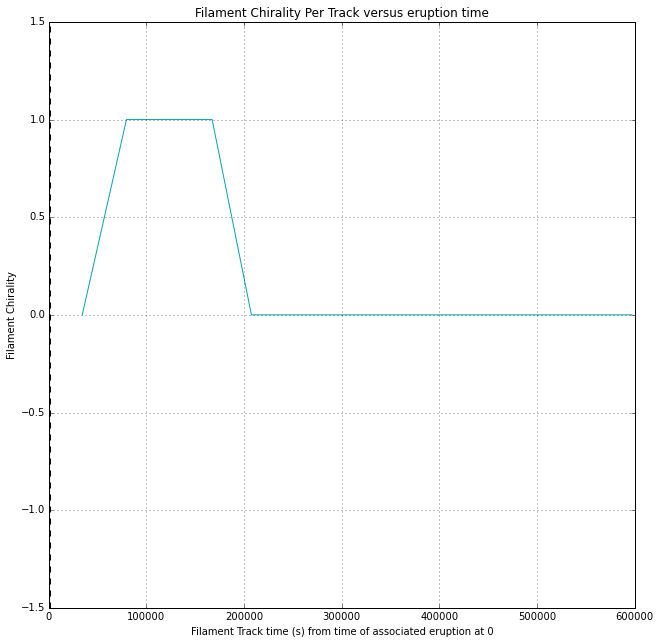

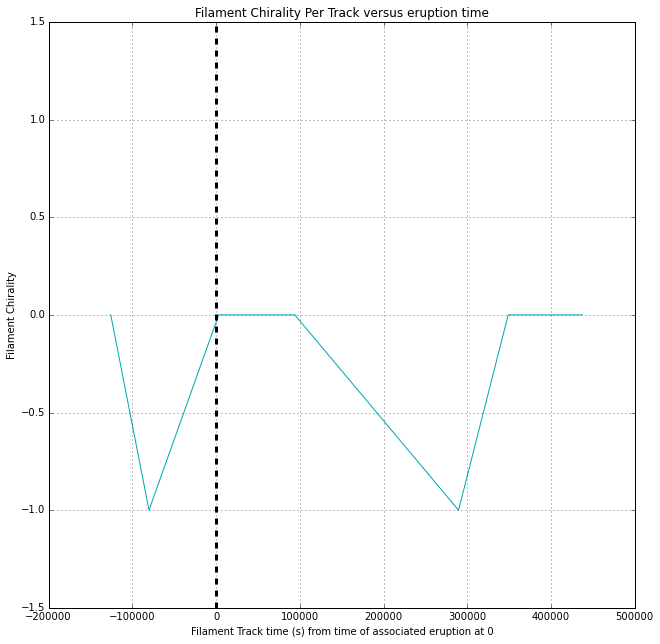

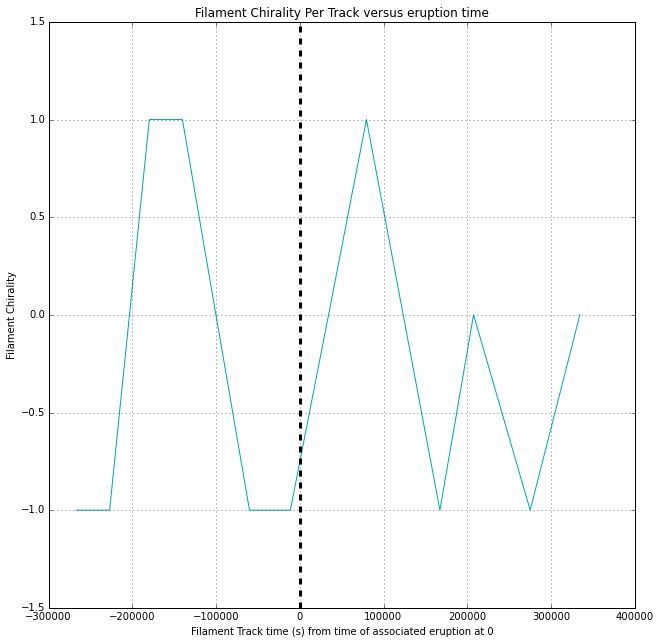

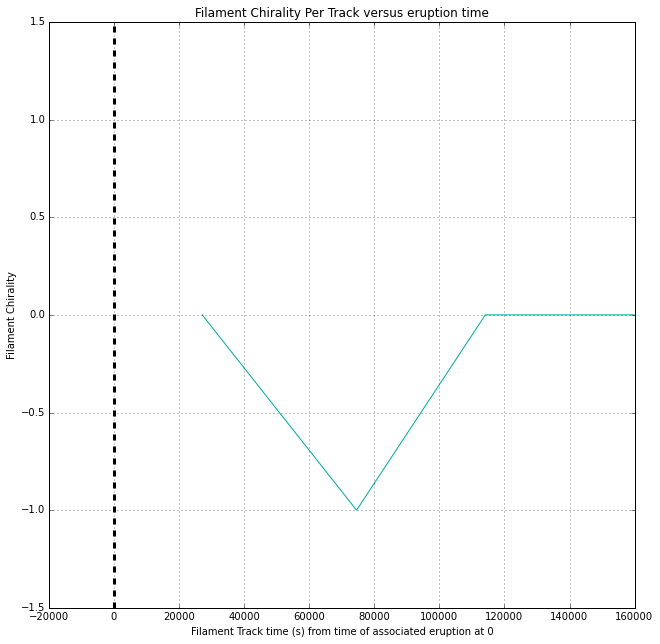

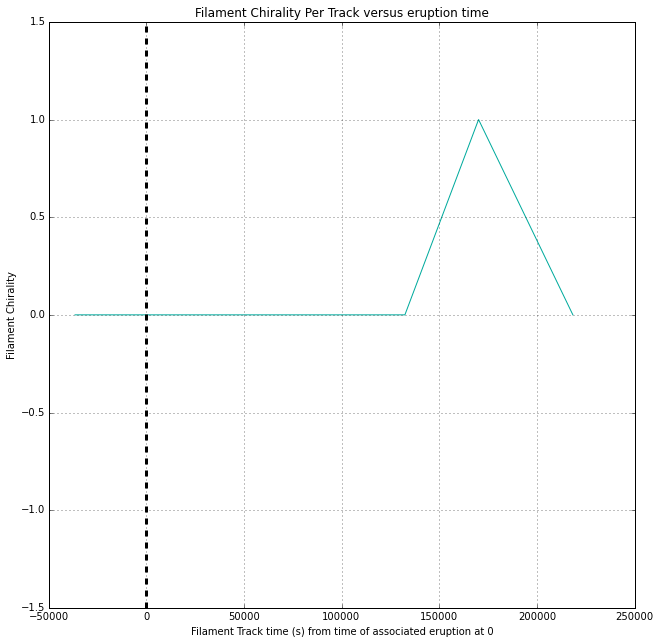

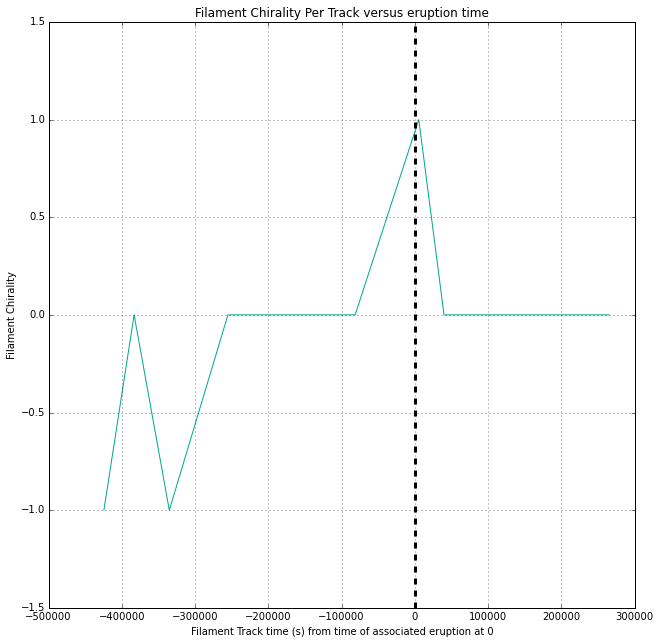

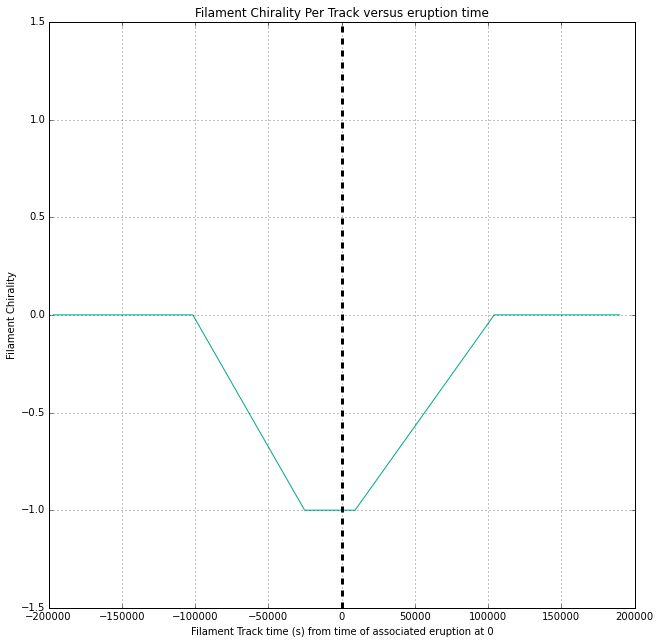

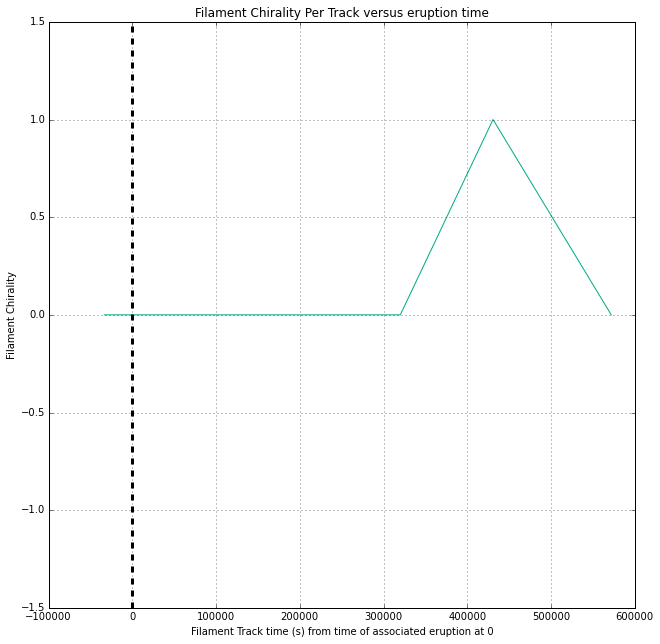

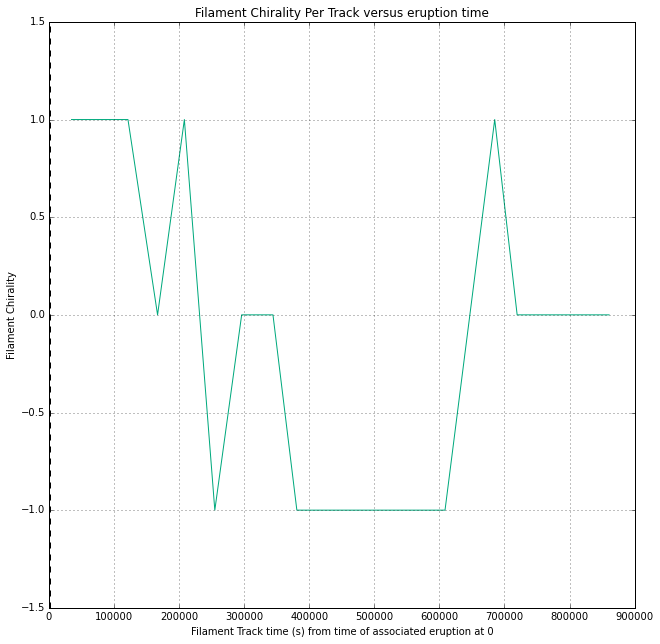

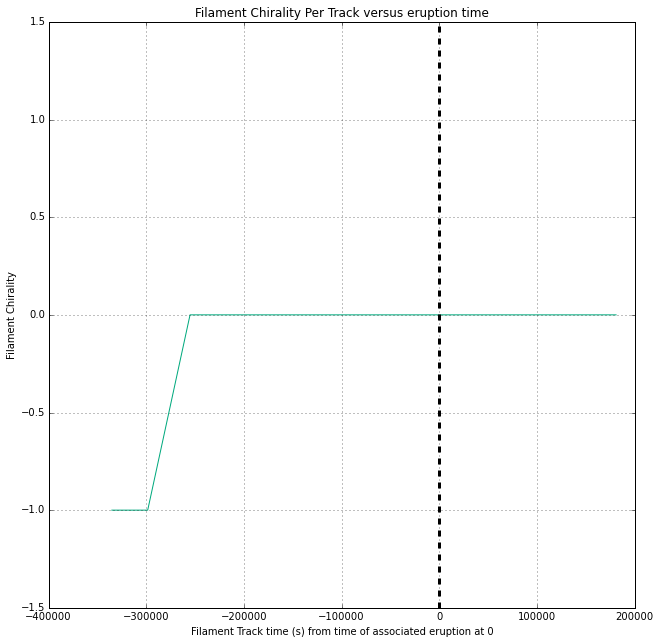

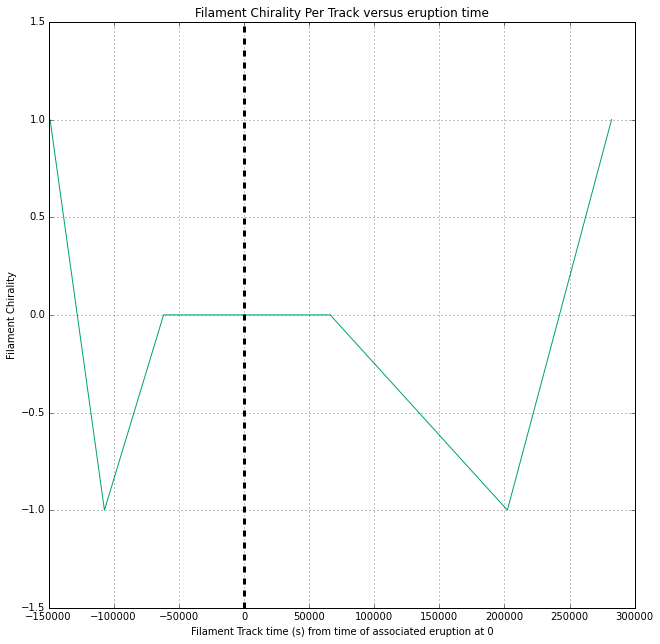

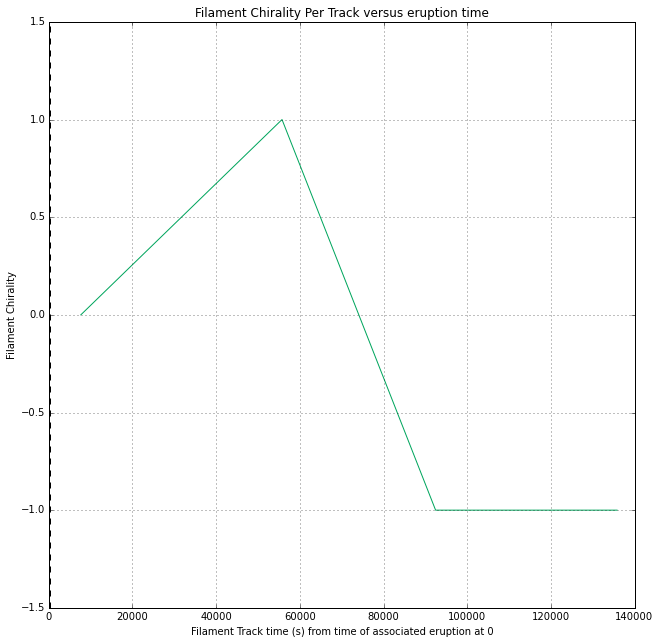

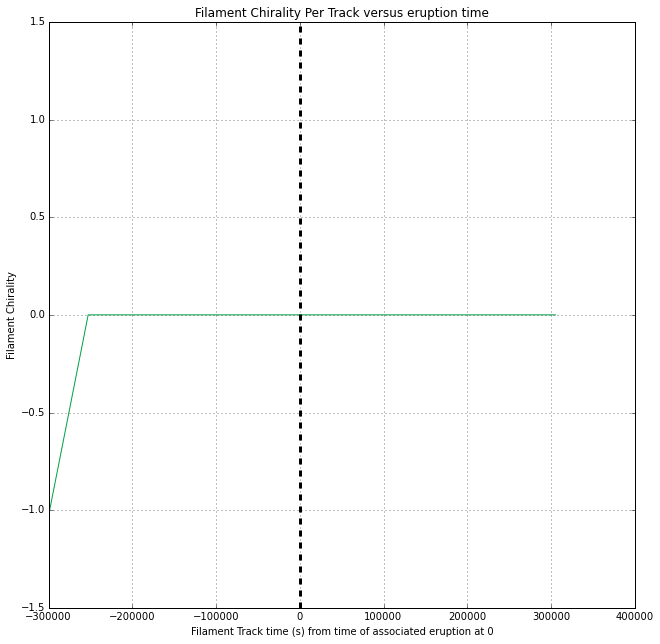

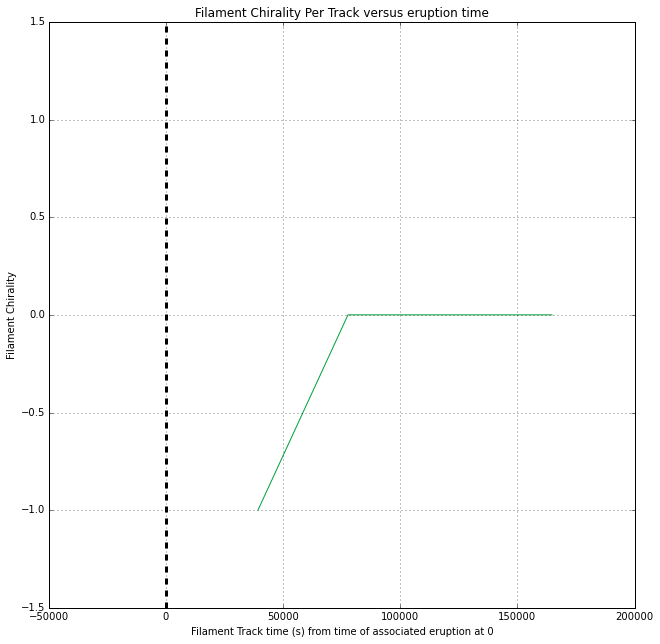

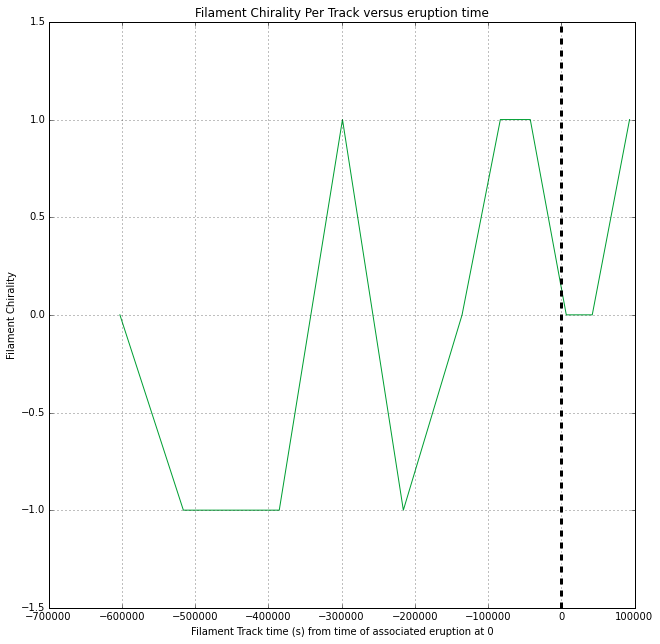

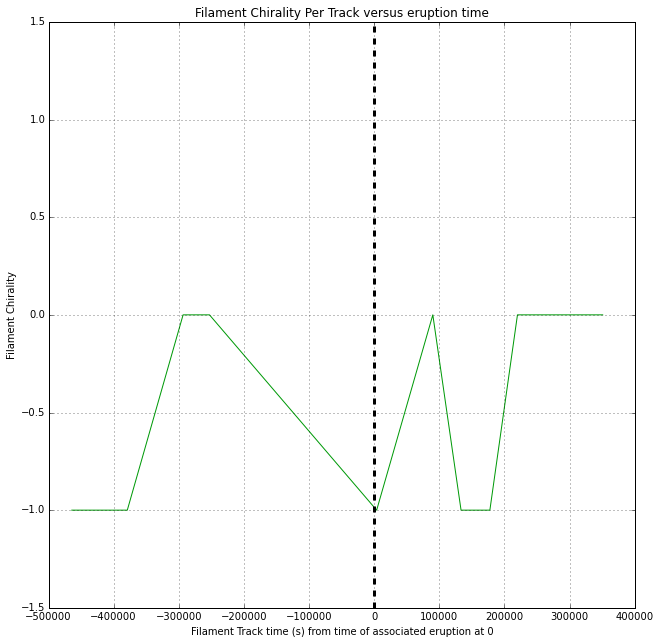

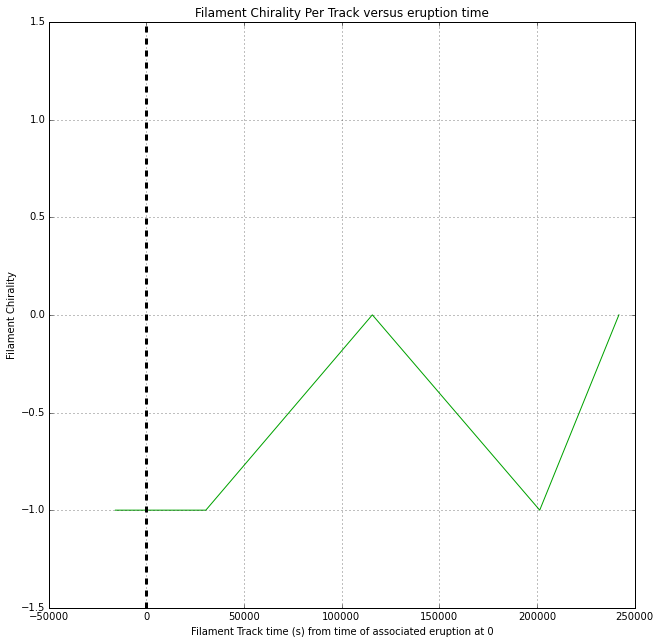

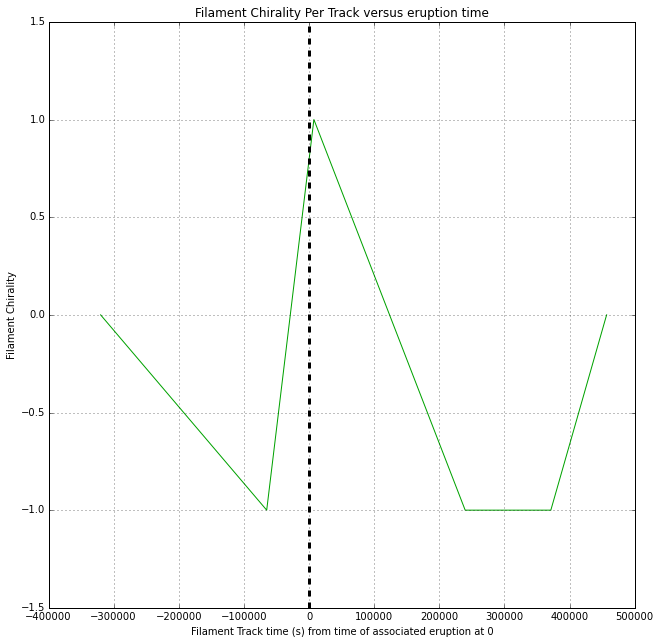

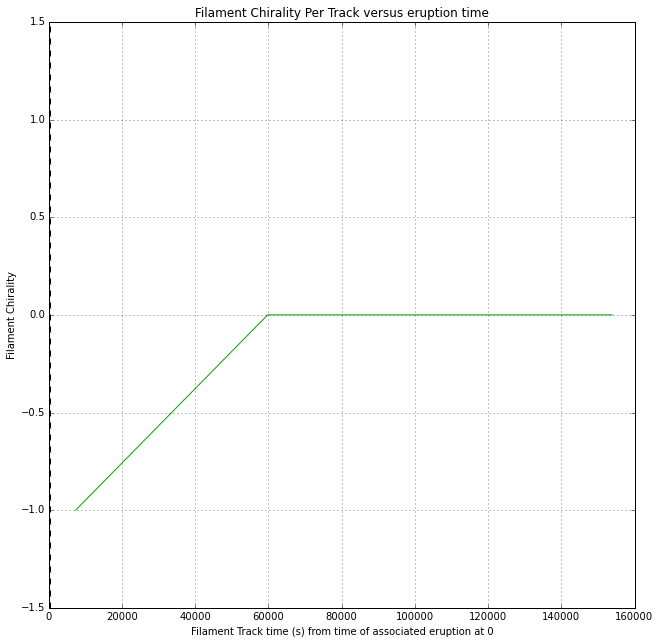

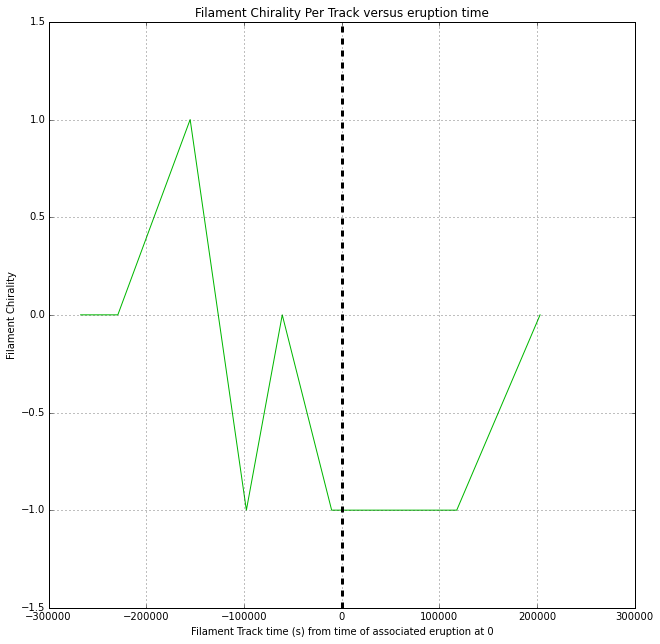

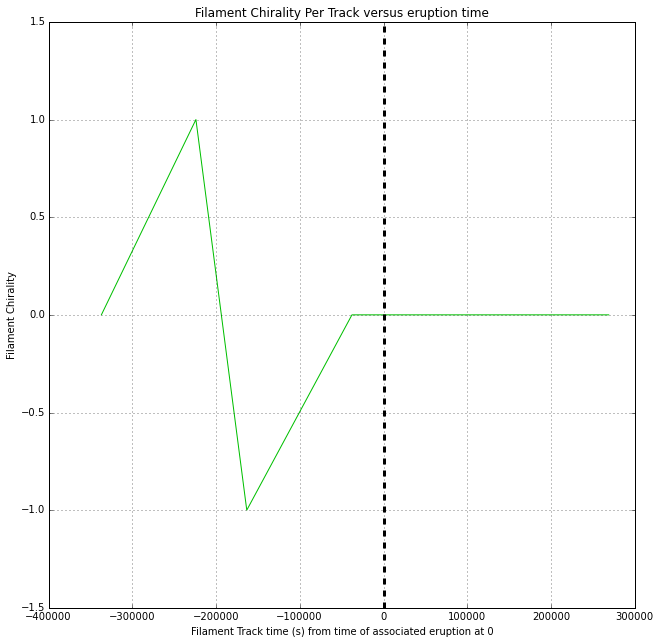

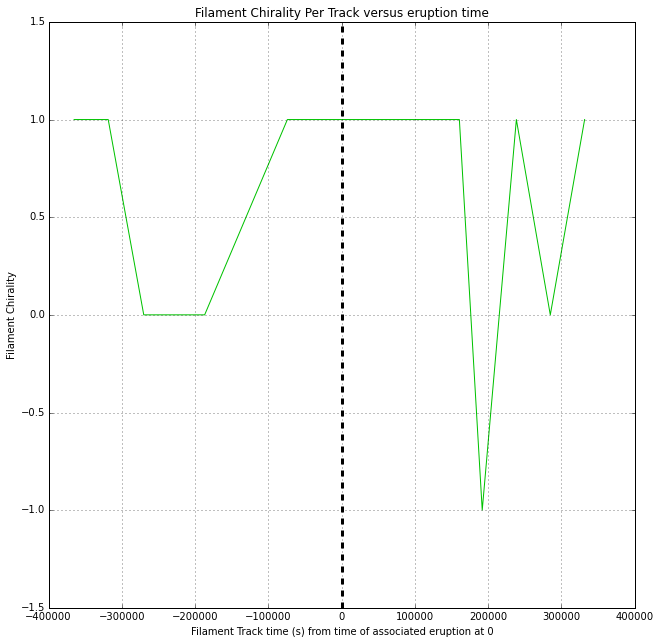

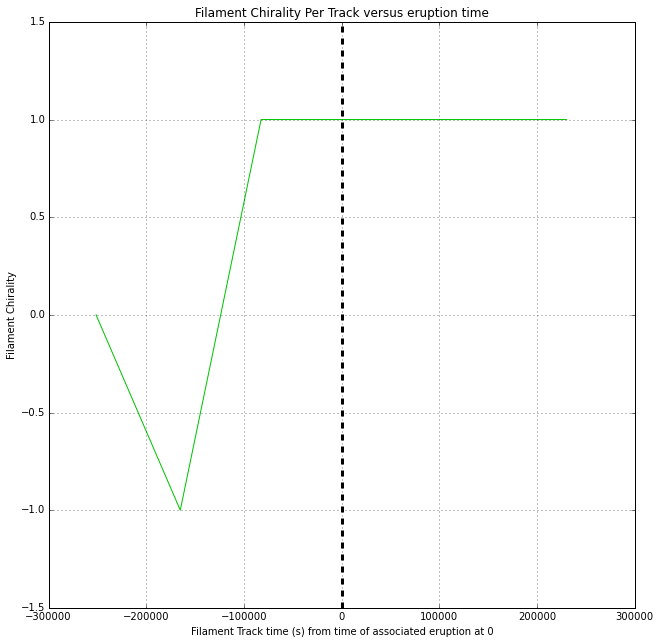

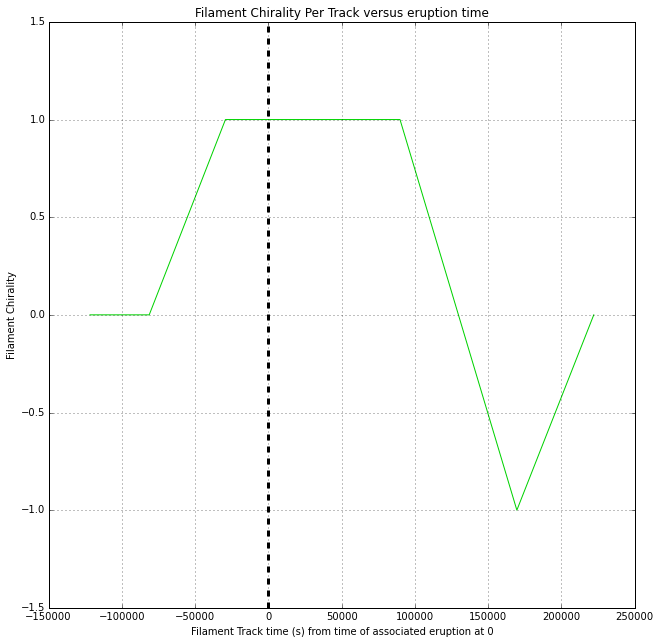

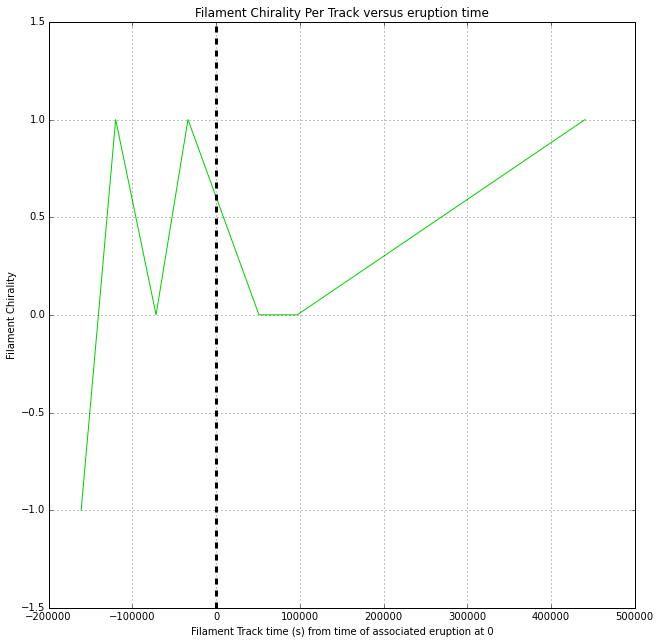

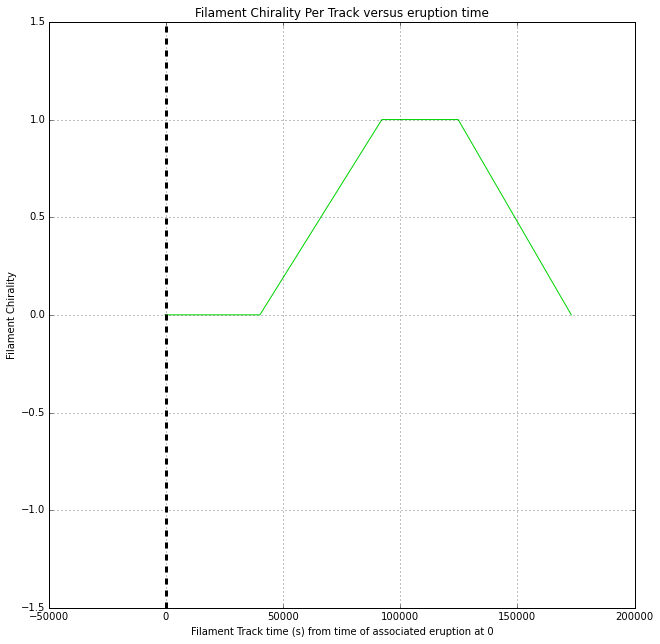

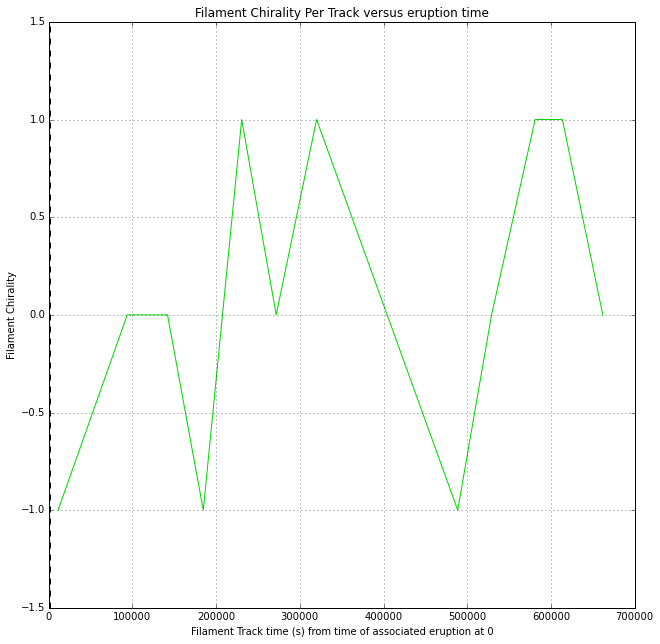

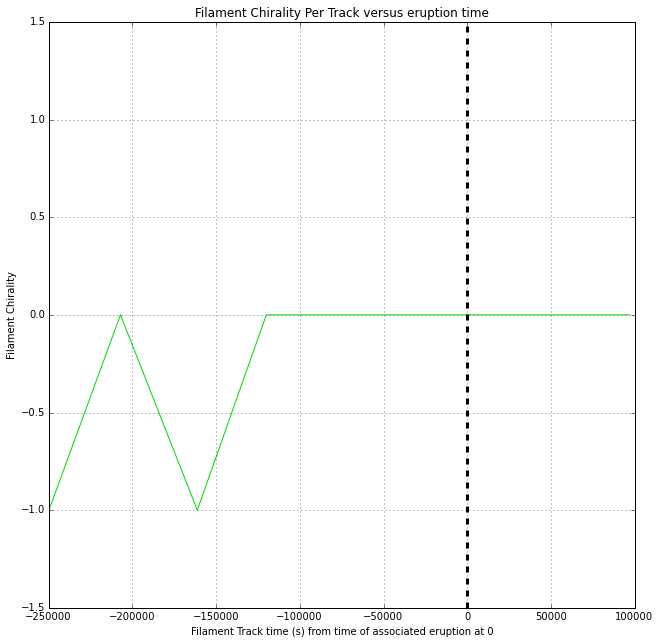

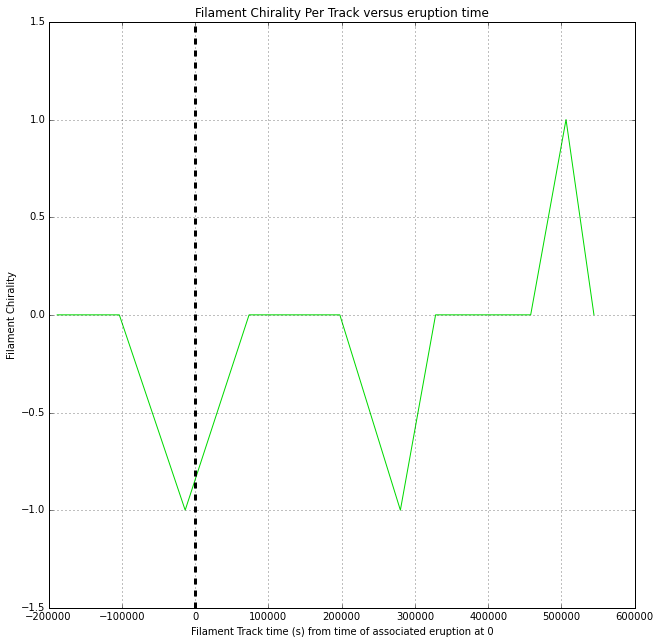

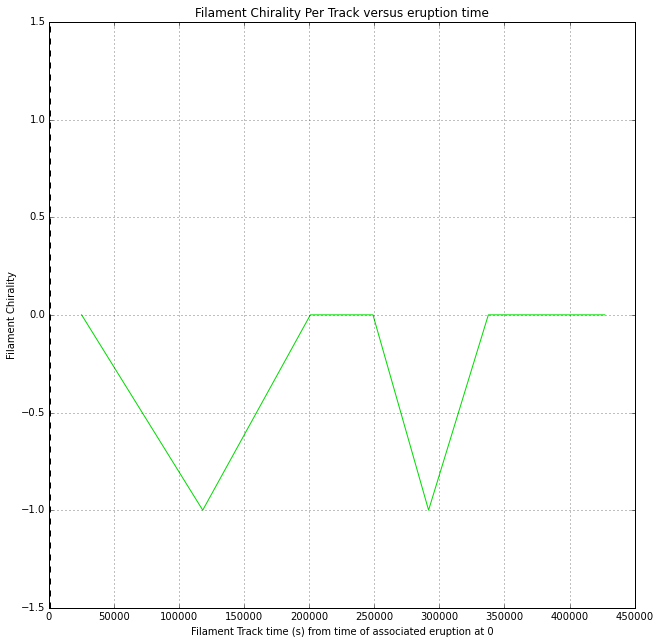

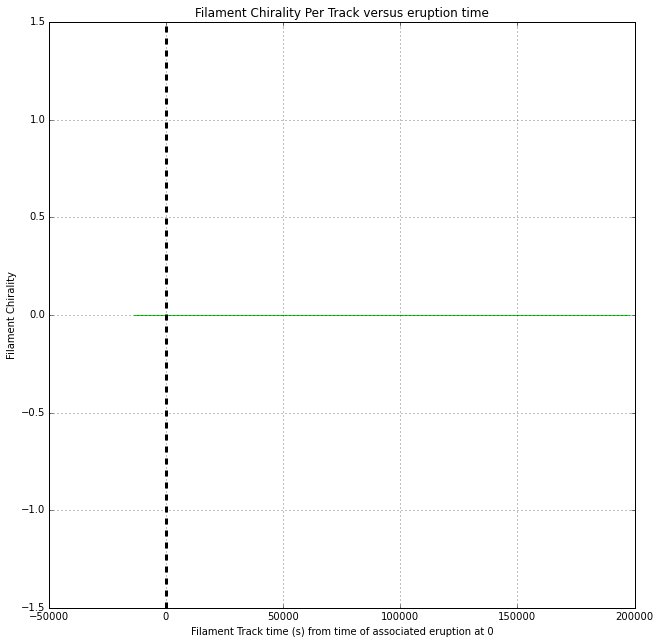

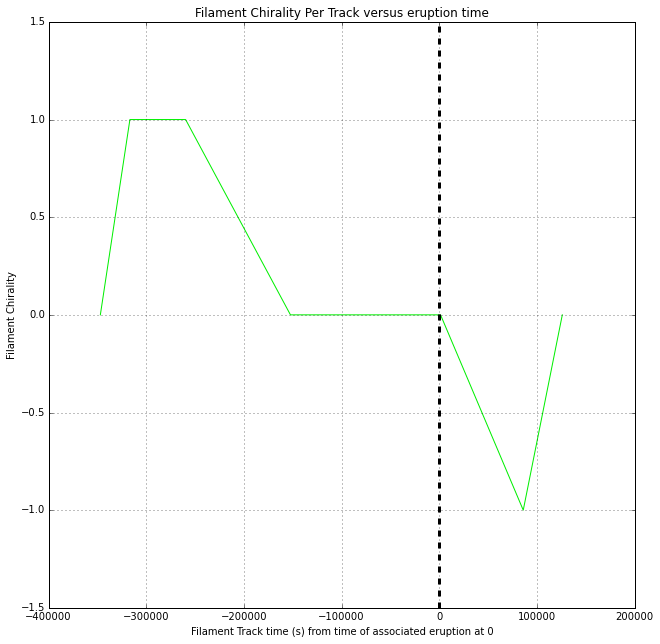

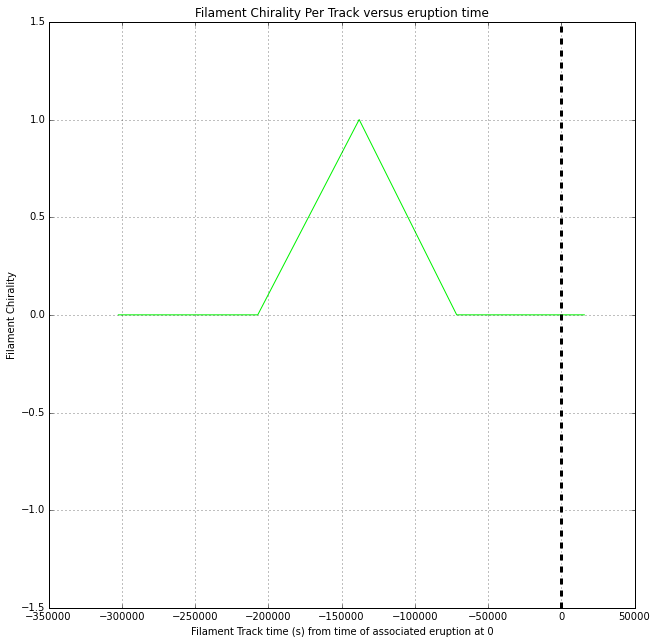

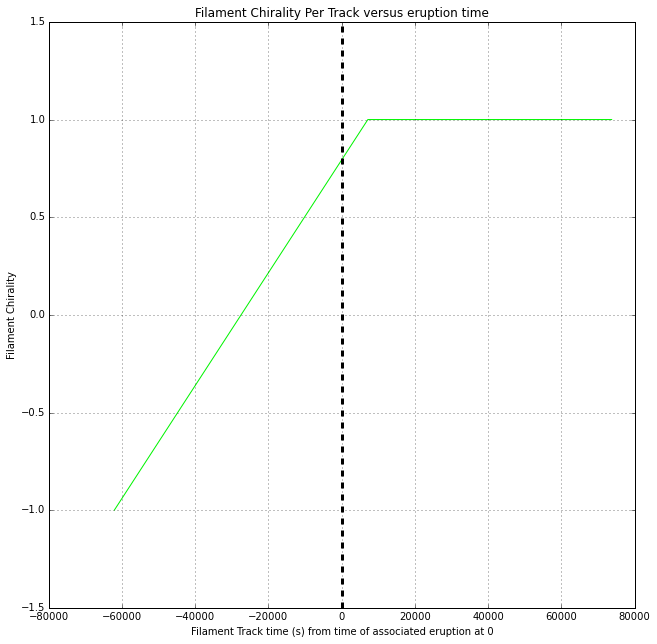

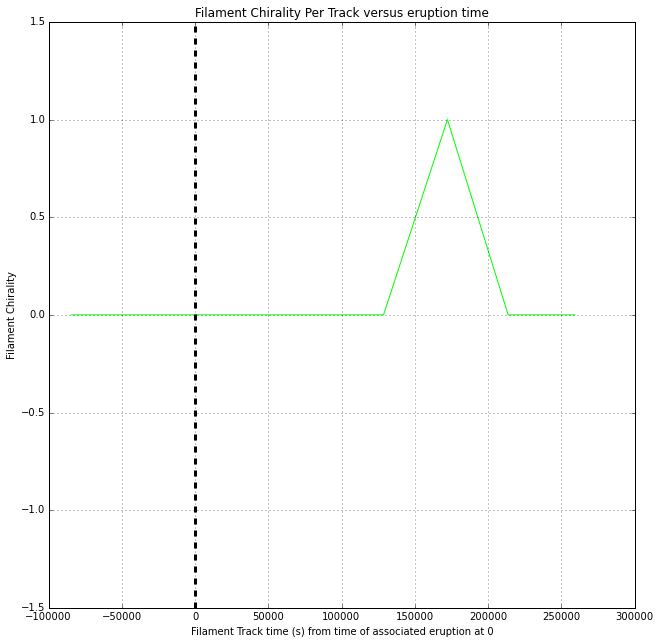

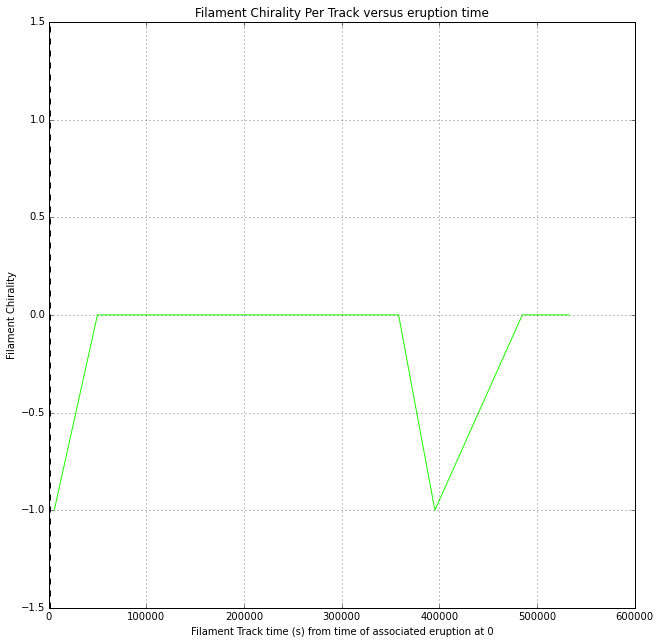

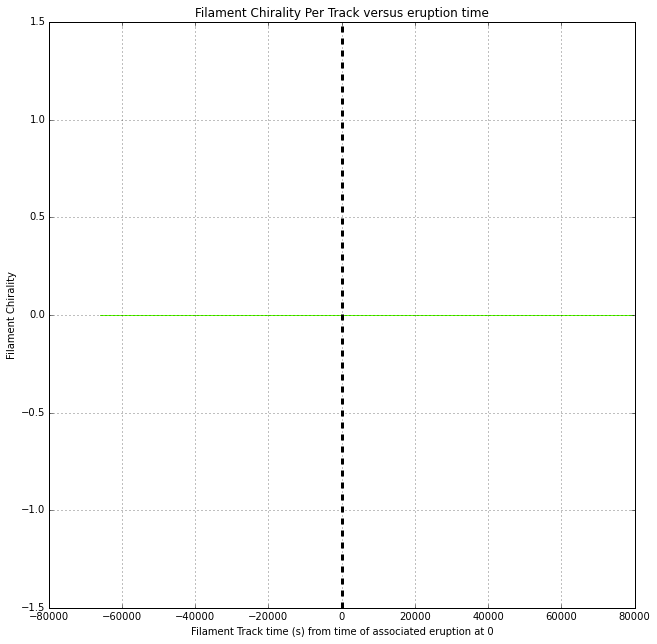

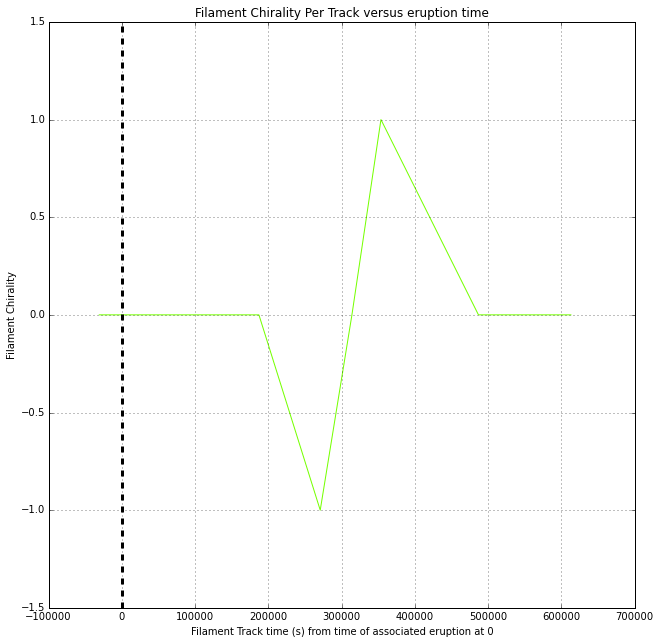

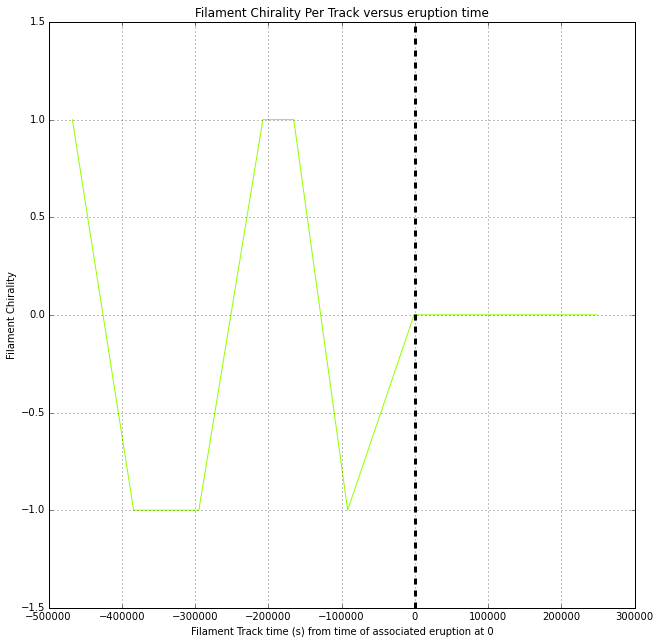

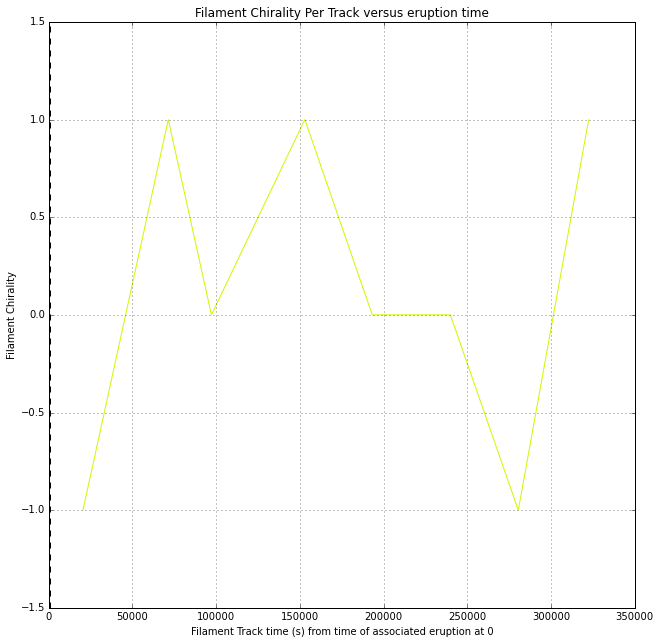

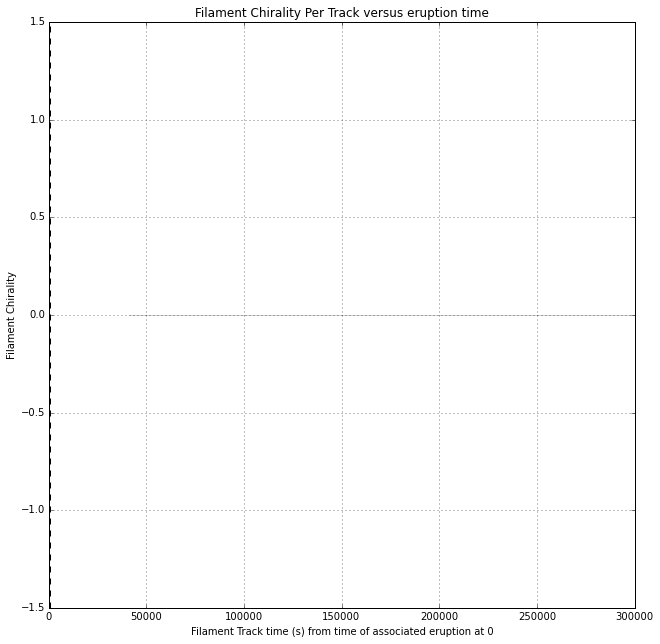

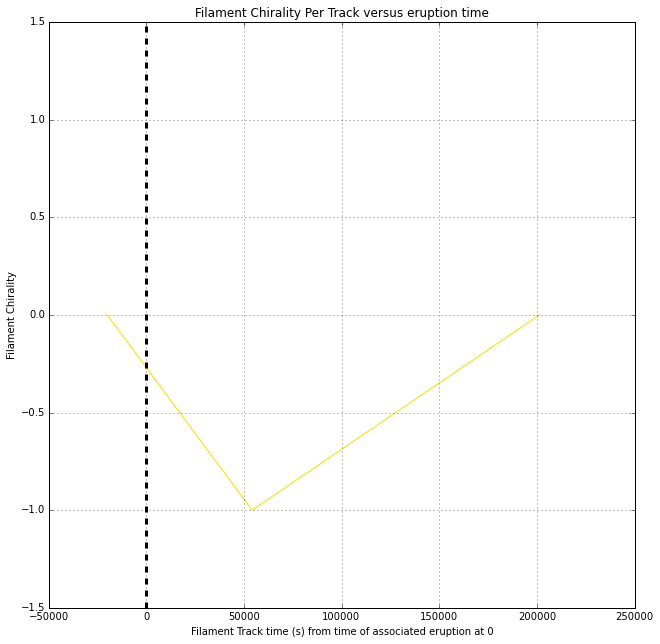

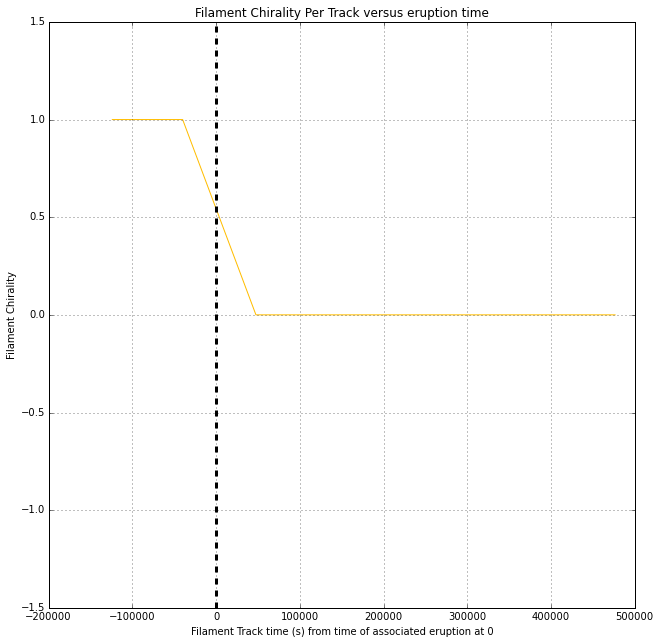

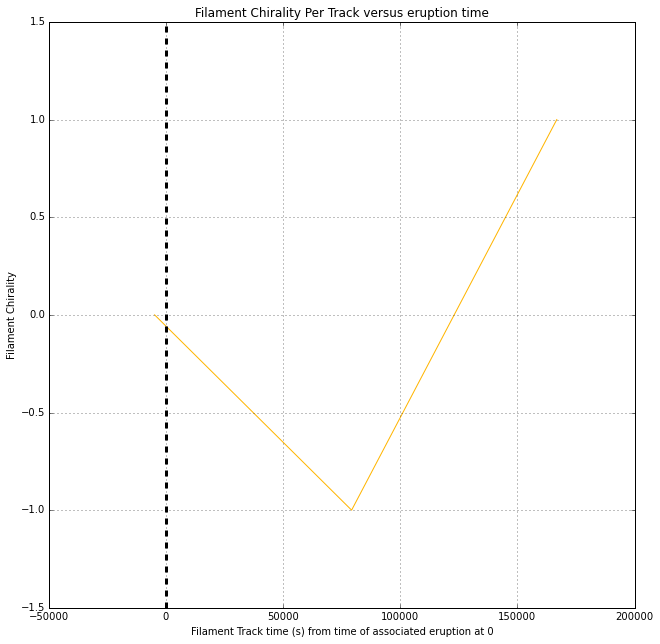

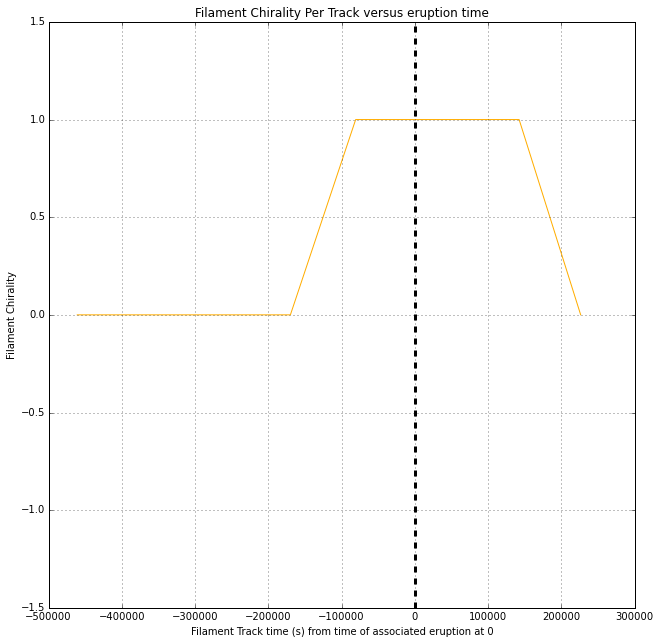

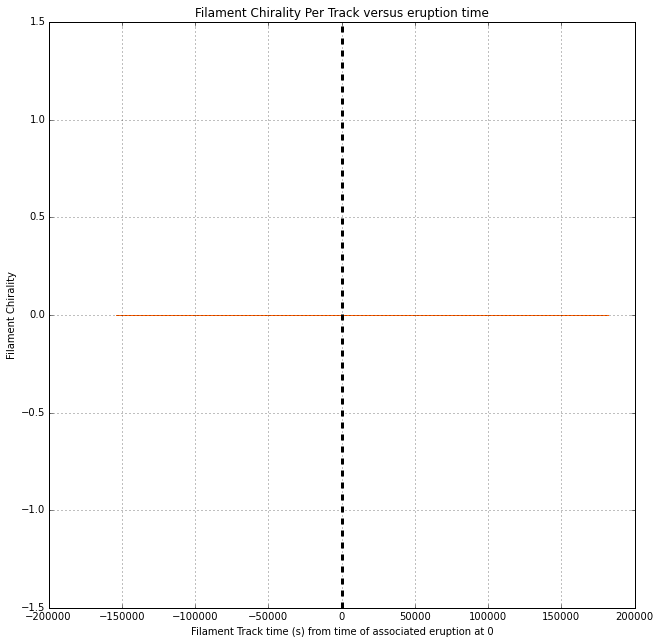

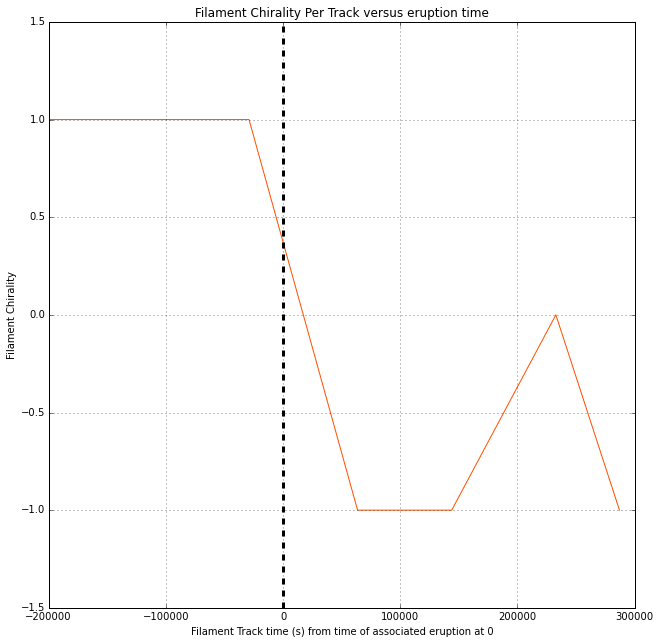

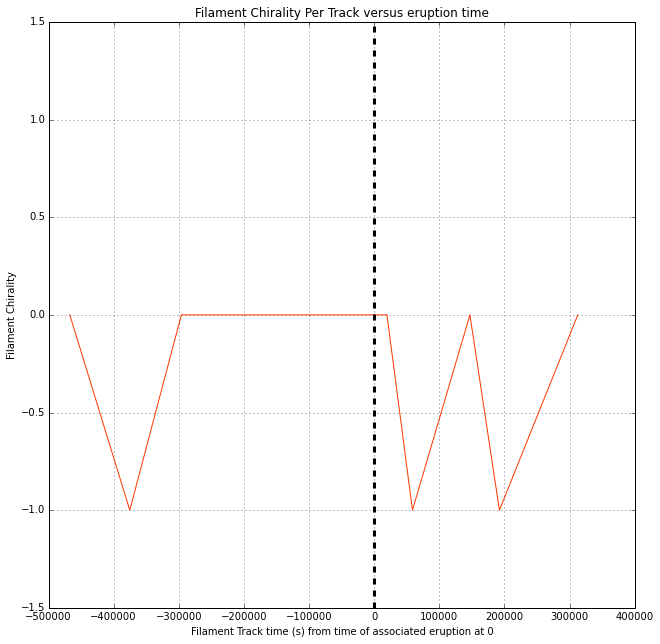

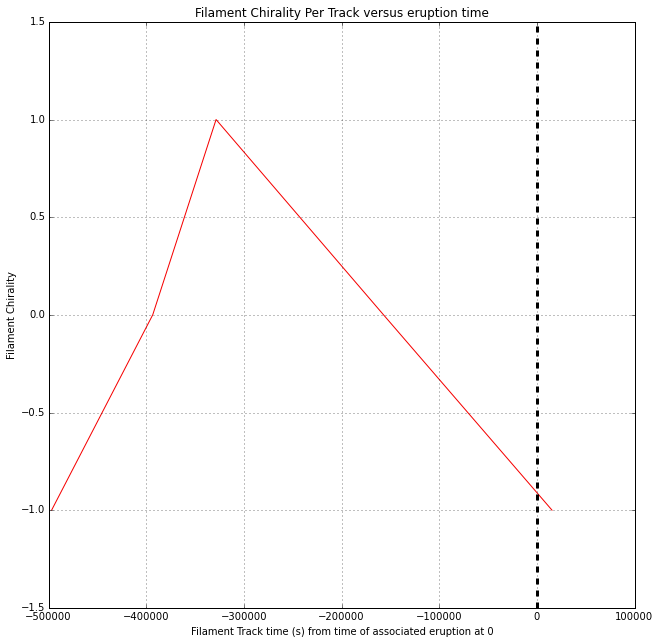

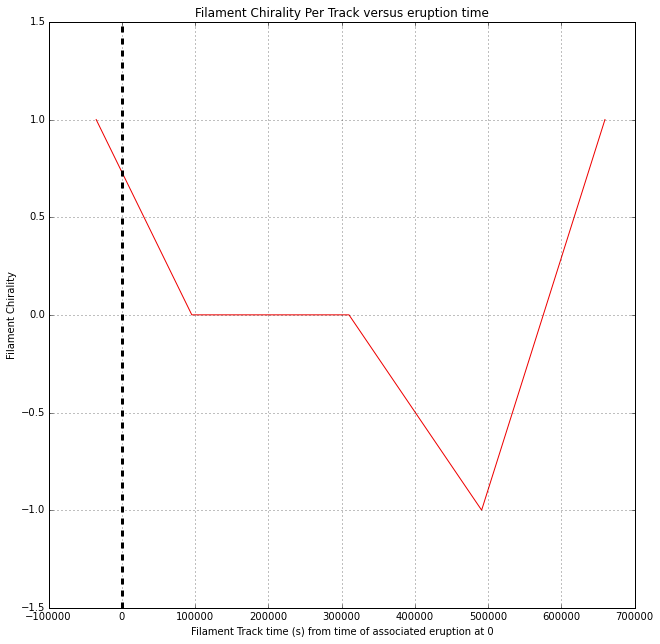

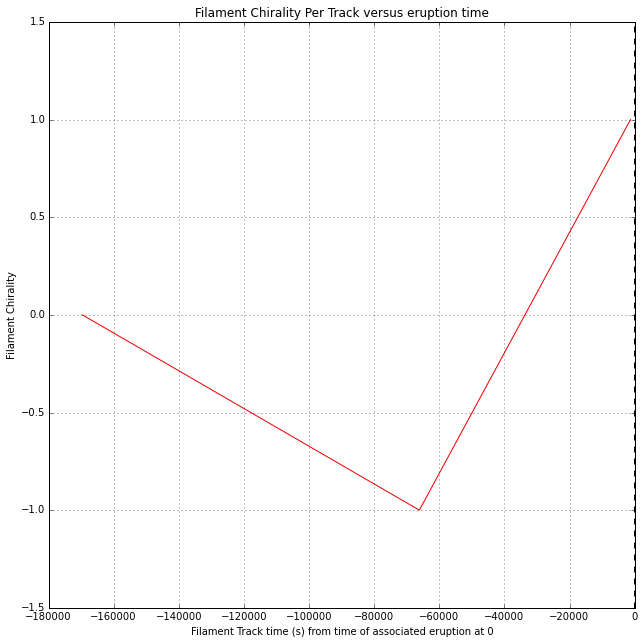

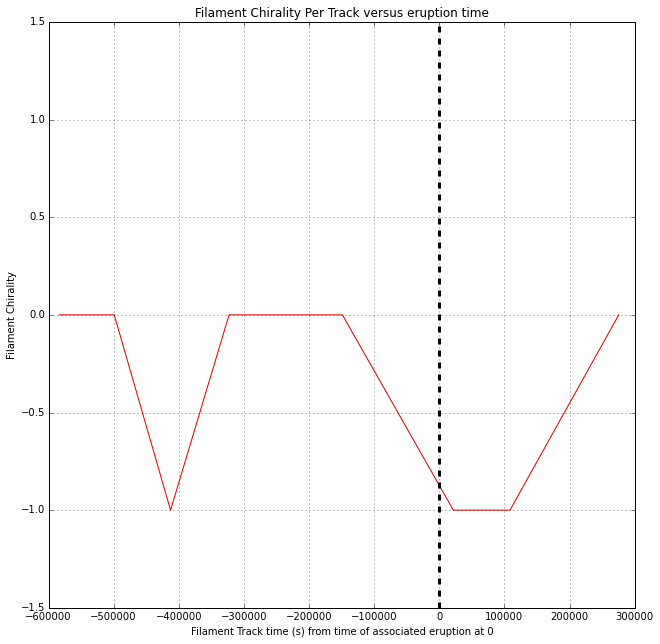

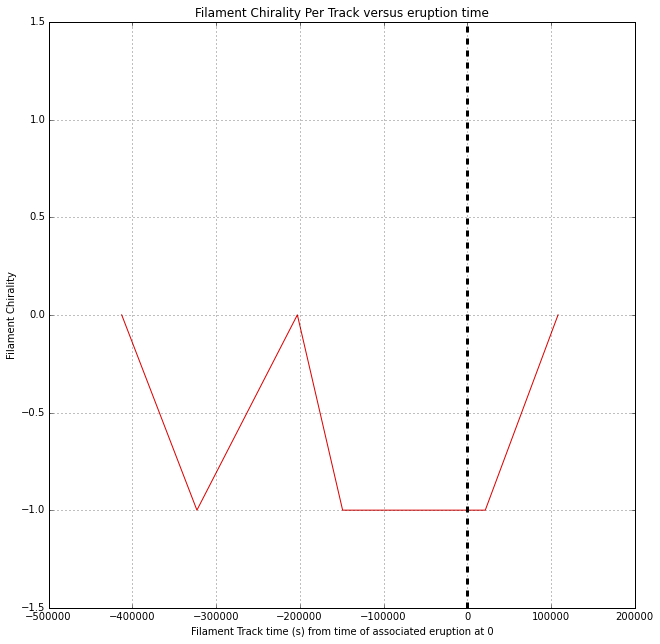

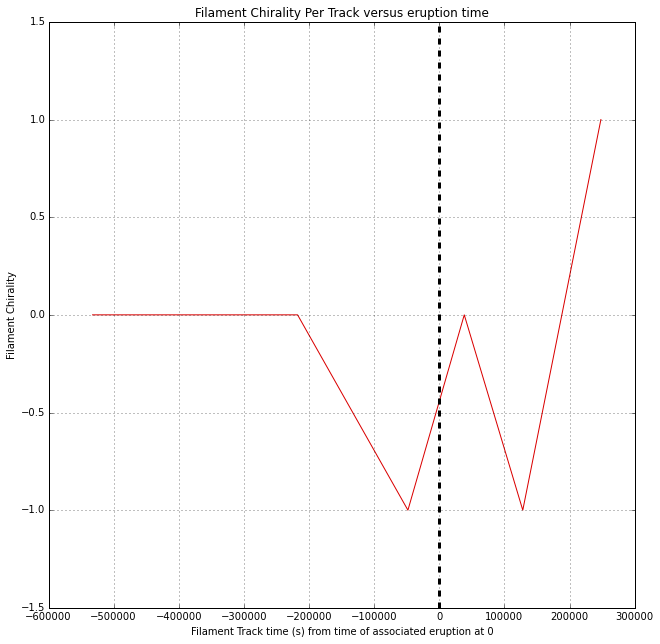

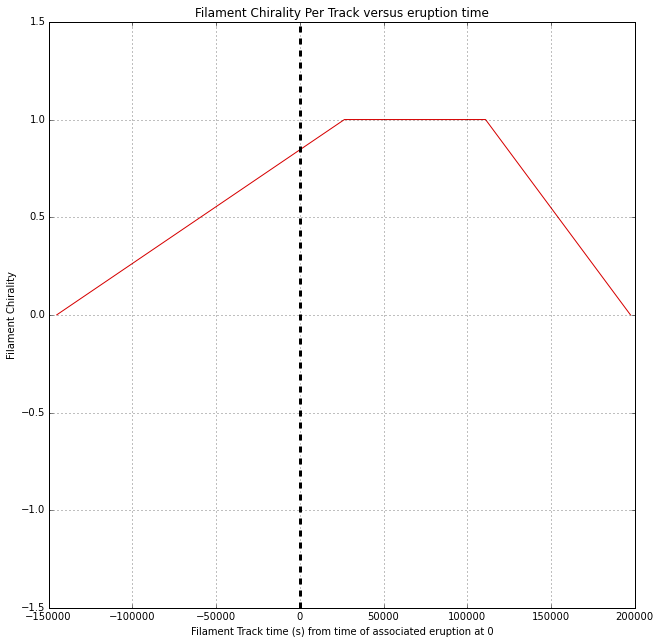

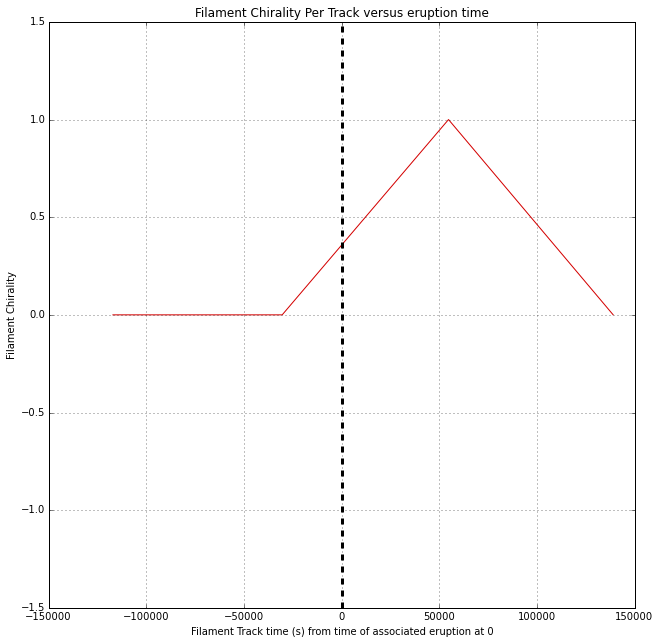

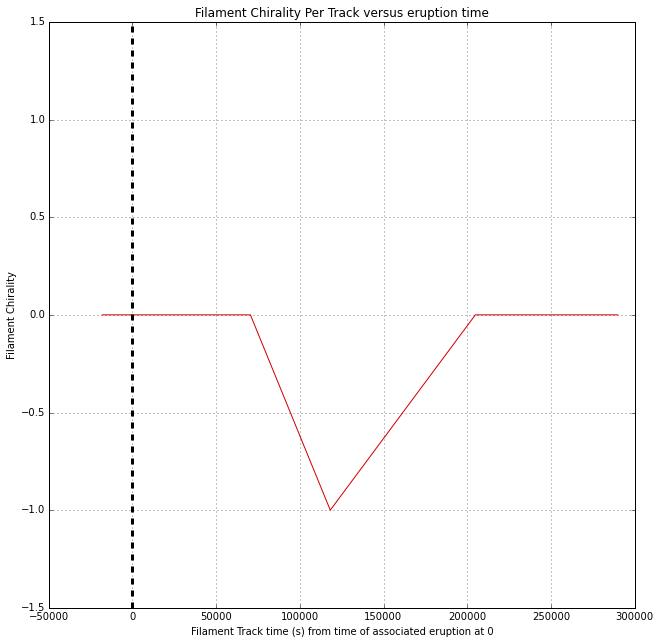

In [29]:
colorscale2=[]
norm = mpl.colors.Normalize(vmin=0, vmax=3500)
cmap = plt.get_cmap('nipy_spectral')
m = cm.ScalarMappable(norm=norm, cmap=cmap)
interest=[]
x=[]
y=[]
t=[]
all_tracks=np.unique(all_tracks)
for track in all_tracks:
    scale3=m.to_rgba(track)
    x=[] ### will be time data
    y=[] ## will be length data 
    r=[]
    t=[]
    interest=[]
    emp=[]
    for r in all_data:      #iterates through the data 
        if r[0] == track:  #finds the correct track
            if r not in interest:
                 interest.append(r)   #appends the data to a new list
    for k in range(0, len(interest)):
        t2= parse(interest[k][3])    ##eruption time
        t1=parse(interest[k][1])    #filament time
        t3=timedelta.total_seconds(t2-t1) #difference between the two in seconds
        t.append(int(t3))
        y.append(interest[k][5])
    plt.plot(t, y, '-', color=scale3)
    plt.axvline(0, linewidth=3, color='k', linestyle='--', label='Eruption')
    plt.title('Filament Chirality Per Track versus eruption time')
    plt.grid(True)
    plt.ylim(-1.5, 1.5)
    fig1 = plt.gcf()
    fig1.set_size_inches(10.5,10.5)
    plt.xlabel('Filament Track time (s) from time of associated eruption at 0')
    plt.ylabel('Filament Chirality')
    plt.show()

# Seperating tracks for north versus south (important for chirality, tilt) for 2012


In [18]:

xvals = [loads(elem).x for elem in working_data_2012['HPC_Center']]
working_data_2012['xcen'] = xvals
yvals = [loads(elem).y for elem in working_data_2012['HPC_Center']]
working_data_2012['ycen'] = yvals 

north_filaments_2012 = working_data_2012.groupby("Track No.").filter(lambda x: sum(x['ycen']) > 0)
south_filaments_2012 = working_data_2012.groupby("Track No.").filter(lambda x: sum(x['ycen']) <= 0)

south_months_2012=[]
north_months_2012=[]
south_groups_2012 = south_filaments_2012.groupby("Track No.")
north_groups_2012 = north_filaments_2012.groupby("Track No.")

for name, group in south_groups_2012:
    month = group['HEK_time'].apply(lambda x: dateutil.parser.parse(x).strftime('%m')) 
    unique_months, counts = np.unique(month, return_counts=True)
    south_months_2012.append(float(unique_months[np.argmax(counts)]))

for name, group in north_groups_2012:
    month = group['HEK_time'].apply(lambda x: dateutil.parser.parse(x).strftime('%m')) 
    unique_months, counts = np.unique(month, return_counts=True)
    north_months_2012.append(float(unique_months[np.argmax(counts)]))
print south_months_2012
print north_months_2012

[1.0, 3.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 7.0, 7.0, 7.0, 7.0, 8.0, 8.0, 8.0, 8.0, 8.0, 9.0, 9.0, 9.0, 10.0, 10.0, 10.0, 11.0, 11.0, 12.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 4.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 7.0, 7.0, 7.0, 7.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 9.0, 9.0, 9.0, 9.0, 9.0, 11.0, 12.0, 12.0]


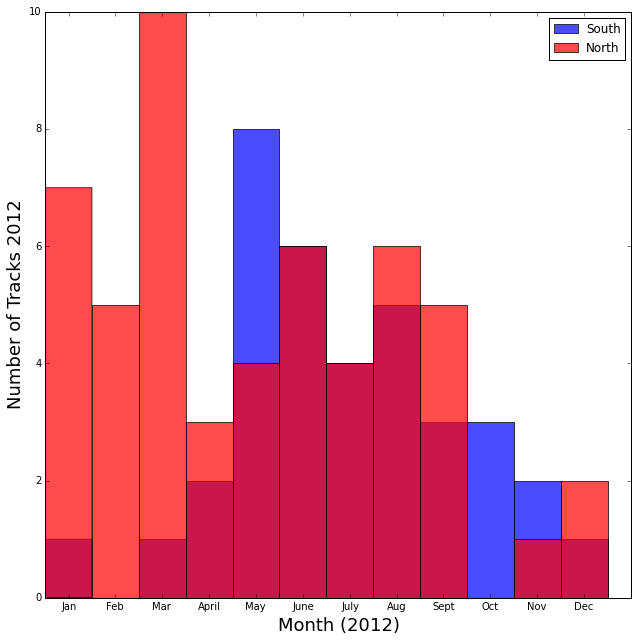

In [19]:
fig, ax=plt.subplots()
ticks = ['Jan','Feb', 'Mar','April','May','June','July','Aug','Sept','Oct','Nov','Dec']
bin_list = np.arange(1,14)
plt.xticks(bin_list)
ax.set_xticklabels(ticks)
bar1=plt.hist(south_months_2012,bins=bin_list, alpha=0.7,align='left',label='South')
bar2=plt.hist(north_months_2012,bins=bin_list, alpha=0.7,align='left',color='r',label='North')
plt.legend()
fig1 = plt.gcf()
fig1.set_size_inches(10.5,10.5)
plt.ylabel('Number of Tracks 2012',fontsize=18)
plt.xlabel('Month (2012)',fontsize=18)
plt.show()

In [32]:
xvals = [loads(elem).x for elem in working_data_oct_2013['HPC_Center']]
working_data_oct_2013['xcen'] = xvals
yvals = [loads(elem).y for elem in working_data_oct_2013['HPC_Center']]
working_data_oct_2013['ycen'] = yvals 

north_filaments_2013 = working_data_oct_2013.groupby("Track No.").filter(lambda x: sum(x['ycen']) > 0)
south_filaments_2013 = working_data_oct_2013.groupby("Track No.").filter(lambda x: sum(x['ycen']) <= 0)

south_months_2013=[]
north_months_2013=[]
south_groups_2013 = south_filaments_2013.groupby("Track No.")
north_groups_2013 = north_filaments_2013.groupby("Track No.")

#for name, group in south_groups_2012:
    #month = group['HEK_time'].apply(lambda x: dateutil.parser.parse(x).strftime('%m')) 
    #unique_months, counts = np.unique(month, return_counts=True)
    #south_months_2012.append(float(unique_months[np.argmax(counts)]))

#for name, group in north_groups_2012:
    #month = group['HEK_time'].apply(lambda x: dateutil.parser.parse(x).strftime('%m')) 
    #unique_months, counts = np.unique(month, return_counts=True)
    #north_months_2012.append(float(unique_months[np.argmax(counts)]))
#print south_months_2012
#print north_months_2012

In [40]:
north_trx_2013=north_filaments_2013['Track No.']
north_trx_2013=np.unique(north_trx_2013)